In [13]:
!pip uninstall ocean-lib -y

!pip install wheel
!pip install --pre ocean-lib

Found existing installation: ocean-lib 2.0.0a4
Uninstalling ocean-lib-2.0.0a4:
  Successfully uninstalled ocean-lib-2.0.0a4
  Using cached ocean_lib-2.0.0a4-py2.py3-none-any.whl (63 kB)


In [95]:
!pip install colorama networkx
!pip install pandas numpy requests prophet 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.1 MB/s eta 0:00:000:00:01m eta 0:00:01


In [288]:
# imports
import datetime
from datetime import timezone
import os
from pathlib import Path
import time
import math

import random
import pickle
import gc
from tqdm import tqdm

import brownie.network as b_network # accounts, connect, disconnect
from brownie.network.account import LocalAccount
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from web3.main import Web3

# from ocean_lib.example_config import ExampleConfig
from ocean_lib.ocean.ocean import Ocean
from ocean_lib.web3_internal.utils import connect_to_network# Create models

In [2]:
#Data Visualization Packages:
#Seaborn
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]
#Colorama
from colorama import Fore, Back, Style # For text colors
y_= Fore.CYAN
m_= Fore.WHITE

#NetworkX
import networkx as nx
import plotly.graph_objects as go #To construct network graphs

In [29]:
# fit a linear model (Open sourced Facebook's Prophet model: https://facebook.github.io/prophet/)
# As the data is subdaily, the model will fit daily seasonality
from prophet import Prophet

from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

In [176]:

# statistics and econometrics

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


In [ ]:
!pip install bokeh

In [171]:

from bokeh.plotting import figure, show
from bokeh.models import Span
from bokeh.io import output_notebook
from bokeh.models import Range1d
from bokeh.models import ColumnDataSource as cds
from bokeh.models import HoverTool
from bokeh.models import NumeralTickFormatter


In [43]:

from sklearn.multioutput import RegressorChain

In [4]:
ocean = create_ocean_instance()
alice_wallet = create_alice_wallet(ocean) #you're Alice


# helper functions: setup
def create_ocean_instance() -> Ocean:
    config = {'NETWORK_NAME': 'polygon', 'METADATA_CACHE_URI': 'https://v4.aquarius.oceanprotocol.com', 'PROVIDER_URL': 'https://v4.provider.polygon.oceanprotocol.com', 'DOWNLOADS_PATH': 'consume-downloads', 'BLOCK_CONFIRMATIONS': 1}#ExampleConfig.get_config("polygon")  # points to Polygon mainnet
    config["BLOCK_CONFIRMATIONS"] = 1  # faster
    print(config)
    b_network.connect("polygon-main")
    print(f"conneceted: {b_network.is_connected()}")
    print(f"active: {b_network.show_active()}")
    connect_to_network("polygon-main")
    ocean = Ocean(config)
    return ocean


def create_alice_wallet(ocean: Ocean) -> LocalAccount:
    config = ocean.config_dict
    alice_private_key = os.getenv('REMOTE_TEST_PRIVATE_KEY1')
    alice_wallet = b_network.accounts.add(alice_private_key)
    bal = Web3.fromWei(b_network.accounts.at(alice_wallet.address).balance(), 'ether')
    print(f"alice_wallet.address={alice_wallet.address}. bal={bal}")
    assert bal > 0, f"Alice needs MATIC"
    return alice_wallet


# helper functions: time
def to_unixtime(dt: datetime.datetime):
    # must account for timezone, otherwise it's off
    ut = dt.replace(tzinfo=timezone.utc).timestamp()
    dt2 = datetime.datetime.utcfromtimestamp(ut)  # to_datetime() approach
    assert dt2 == dt, f"dt: {dt}, dt2: {dt2}"
    return ut


def to_unixtimes(dts: list) -> list:
    return [to_unixtime(dt) for dt in dts]


def to_datetime(ut) -> datetime.datetime:
    dt = datetime.datetime.utcfromtimestamp(ut)
    ut2 = dt.replace(tzinfo=timezone.utc).timestamp()  # to_unixtime() approach
    assert ut2 == ut, f"ut: {ut}, ut2: {ut2}"
    return dt


def to_datetimes(uts: list) -> list:
    return [to_datetime(ut) for ut in uts]


def round_to_nearest_hour(dt: datetime.datetime) -> datetime.datetime:
    return (dt.replace(second=0, microsecond=0, minute=0, hour=dt.hour)
            + datetime.timedelta(hours=dt.minute//30))


def pretty_time(dt: datetime.datetime) -> str:
    return dt.strftime('%Y/%m/%d, %H:%M:%S')


def print_datetime_info(descr: str, uts: list):
    dts = to_datetimes(uts)
    print(descr + ":")
    print(f"  starts on: {pretty_time(dts[0])}")
    print(f"    ends on: {pretty_time(dts[-1])}")
    print(f"  {len(dts)} datapoints")
    print(f"  time interval between datapoints: {(dts[1]-dts[0])}")


def target_12h_unixtimes(start_dt: datetime.datetime) -> list:
    target_dts = [start_dt + datetime.timedelta(hours=h) for h in range(12)]
    target_uts = to_unixtimes(target_dts)
    return target_uts


# helper-functions: higher level
def load_from_ohlc_data(file_name: str) -> tuple:
    """Returns (list_of_unixtimes, list_of_close_prices)"""
    with open(file_name, "r") as file:
        data_str = file.read().rstrip().replace('"', '')
    x = eval(data_str)  # list of lists
    uts = [xi[0]/1000 for xi in x]
    vals = [xi[4] for xi in x]
    return (uts, vals)


def filter_to_target_uts(target_uts: list, unfiltered_uts: list, unfiltered_vals: list) -> list:
    """Return filtered_vals -- values at at the target timestamps"""
    filtered_vals = [None] * len(target_uts)
    for i, target_ut in enumerate(target_uts):
        time_diffs = np.abs(np.asarray(unfiltered_uts) - target_ut)
        tol_s = 1  # should always align within e.g. 1 second
        target_ut_s = pretty_time(to_datetime(target_ut))
        assert min(time_diffs) <= tol_s, \
            f"Unfiltered times is missing target time: {target_ut_s}"
        j = np.argmin(time_diffs)
        filtered_vals[i] = unfiltered_vals[j]
    return filtered_vals


# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))


def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_


# helpers: prediction performance
def calc_nmse(y, yhat) -> float:
    assert len(y) == len(yhat)
    mse_xy = np.sum(np.square(np.asarray(y) - np.asarray(yhat)))
    mse_x = np.sum(np.square(np.asarray(y)))
    nmse = mse_xy / mse_x
    return nmse


def plot_prices(cex_vals, pred_vals, last_x_hours):
    matplotlib.rcParams.update({'font.size': 22})
    x = [h for h in range(0, last_x_hours)]
    assert len(x) == len(cex_vals) == len(pred_vals)
    fig, ax = plt.subplots()
    ax.plot(x, cex_vals, '--', label="CEX values")
    ax.plot(x, pred_vals, '-', label="Pred. values")
    ax.legend(loc='lower right')
    plt.ylabel("ETH price")
    plt.xlabel("Hour")
    fig.set_size_inches(18, 18)
    plt.xticks(x)
    plt.show()

In [5]:
def triple_plot(x, title,c):
    fig, ax = plt.subplots(3,1,figsize=(10,20))
#     sns.displot(x, ax=ax[0],color=c, kind="kde")
#     sns.displot(x, ax=ax[0],color=c, kind="hist")
#     sns.histplot(data=x, ax=ax[0],color=c)
    sns.kdeplot(data=x, ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x=x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    sns.violinplot(x=x, ax=ax[2],color=c)
    ax[2].set(xlabel=None)
    ax[2].set_title('Violin plot')
    fig.suptitle(title, fontsize=30)
    plt.tight_layout(pad=3.0)
    plt.show()

In [168]:
# adapted from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python?scriptVersionId=50985180&cellId=80
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

In [ ]:


from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))



In [6]:
import ccxt
import pandas as pd
import numpy as np
import requests

cex_x = ccxt.binance().fetch_ohlcv('ETH/USDT', '1h')

# create a Data Frame with two columns [date,eth-prices] with dates given in intervals of 1-hour
import pandas as pd
data = pd.DataFrame(cex_x, columns=['date', 'open', 'max', 'min', 'close', 'volume'])
data['date'] = pd.to_datetime(data['date'],unit='ms')

# Divide the data in training and testing set. Because the data has temporal structure, we split the data in two blocks, vs. selecting randomly.
# 90% of the data is used for training and 10 is used for testing
train_rate = 0.9
n = data.shape[0]
ntrain = int(np.floor(n*train_rate))
train_data = data.iloc[0:ntrain,:]
test_data = data.iloc[ntrain:,:]

# Create feature vectors
# - Define how many samples in the past are used to predict future values. 
# - This also defines the number of smaples to be predicted in the future.
max_lag = 12 

# Create feature vectors with 12 columns, each representing a time-lag from the current time point
# - That is: x(t-1), x(t-2)...x(t-12) for close and open values (different features could be grouped using the same logic)
full_train_close = pd.concat([train_data['close'].shift(i) for i in range(0,max_lag)],axis=1).dropna().values
full_train_open = pd.concat([train_data['open'].shift(i) for i in range(0,max_lag)],axis=1).dropna().values
# targets are multivariate, with the values of eth from 1 - 12 hours ahead of the curent time
y_train = full_train_close[max_lag:,:]
# train set is lagged with respect to the targets
x_train = np.concatenate((full_train_close[0:-max_lag,:],full_train_open[0:-max_lag,:]),axis=1)

# Repeat the feature vector creation as above for the test set
full_test_close = pd.concat([test_data['close'].shift(i) for i in range(0,max_lag)],axis=1).dropna().values
full_test_open = pd.concat([test_data['open'].shift(i) for i in range(0,max_lag)],axis=1).dropna().values
y_test = full_test_close[max_lag:,:]
x_test = np.concatenate((full_test_close[0:-max_lag,:],full_test_open[0:-max_lag,:]),axis=1)

In [50]:
# Create models
from sklearn.multioutput import RegressorChain
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Input, Dense
import numpy as np
import matplotlib.pyplot as plt

# regression using a base estimator and RegressionChain
def fit_and_predict_reg(base_model,x_train,y_train,x_test,y_test):
    chain = RegressorChain(base_estimator=base_model).fit(x_train, y_train)  
    yhat_test = chain.predict(x_test)
    return calc_nmse(y_test,yhat_test), yhat_test

# Neural network using Keras, 2 hidden layers with RELU activations, output layer with linear activations 
def fit_andpredict_fcnn(x_train,y_train,x_test,y_test):
    inputs = Input(shape=(x_train.shape[1],))
    x = Dense(128,activation='relu')(inputs)
    x = Dense(64,activation='relu')(x)
    outputs = Dense(12,activation='linear')(x)
    model = Model(inputs=inputs,outputs=outputs)
    # set compiling parameters
    model.compile( optimizer="adam", loss='mean_absolute_percentage_error',metrics=[])
    # Fit model
    model.fit(x_train,y_train,batch_size=100, epochs=500, validation_split=0.1, verbose=0)
    # predict
    yhat_test = model.predict(x_test)
    return calc_nmse(y_test,yhat_test), yhat_test

# multi-output linear regression
from sklearn.linear_model import LinearRegression 
linreg = LinearRegression()
linreg_error,yhat_test_lin = fit_and_predict_reg(linreg,x_train,y_train,x_test,y_test)

# multi-output random forest regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
rfr = RandomForestRegressor(max_depth=10)
rfr_error,yhat_test_rfr = fit_and_predict_reg(rfr,x_train,y_train,x_test,y_test)

# multi-output support vector machines
from sklearn.svm import SVR
svr = SVR(kernel='rbf', C=1000, epsilon=.1)
svr_error,yhat_test_svr = fit_and_predict_reg(svr,x_train,y_train,x_test,y_test)

# Dense NN
dnn_error,yhat_test_dnn = fit_andpredict_fcnn(x_train,y_train,x_test,y_test)




1/1 [==============================] - 0s 20ms/step


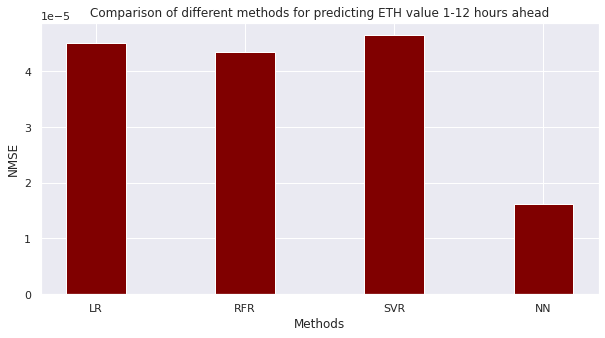

In [52]:
# Plot results

info = {'LR':linreg_error, 'RFR':rfr_error, 'SVR':svr_error,'NN':dnn_error}
methods = list(info.keys())
values = list(info.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(methods, values, color ='maroon', width = 0.4)
 
plt.xlabel("Methods")
plt.ylabel("NMSE")
plt.title("Comparison of different methods for predicting ETH value 1-12 hours ahead")
plt.show()

In [72]:
actual_close = [x[0] for x in y_test]
actual_yhat_test_lin = [x[0] for x in yhat_test_lin]
actual_yhat_test_rfr = [x[0] for x in yhat_test_rfr]
actual_yhat_test_svr = [x[0] for x in yhat_test_svr]
actual_yhat_test_dnn = [x[0] for x in yhat_test_dnn]
viz = [actual_close,actual_yhat_test_lin,actual_yhat_test_rfr,actual_yhat_test_svr,actual_yhat_test_dnn]

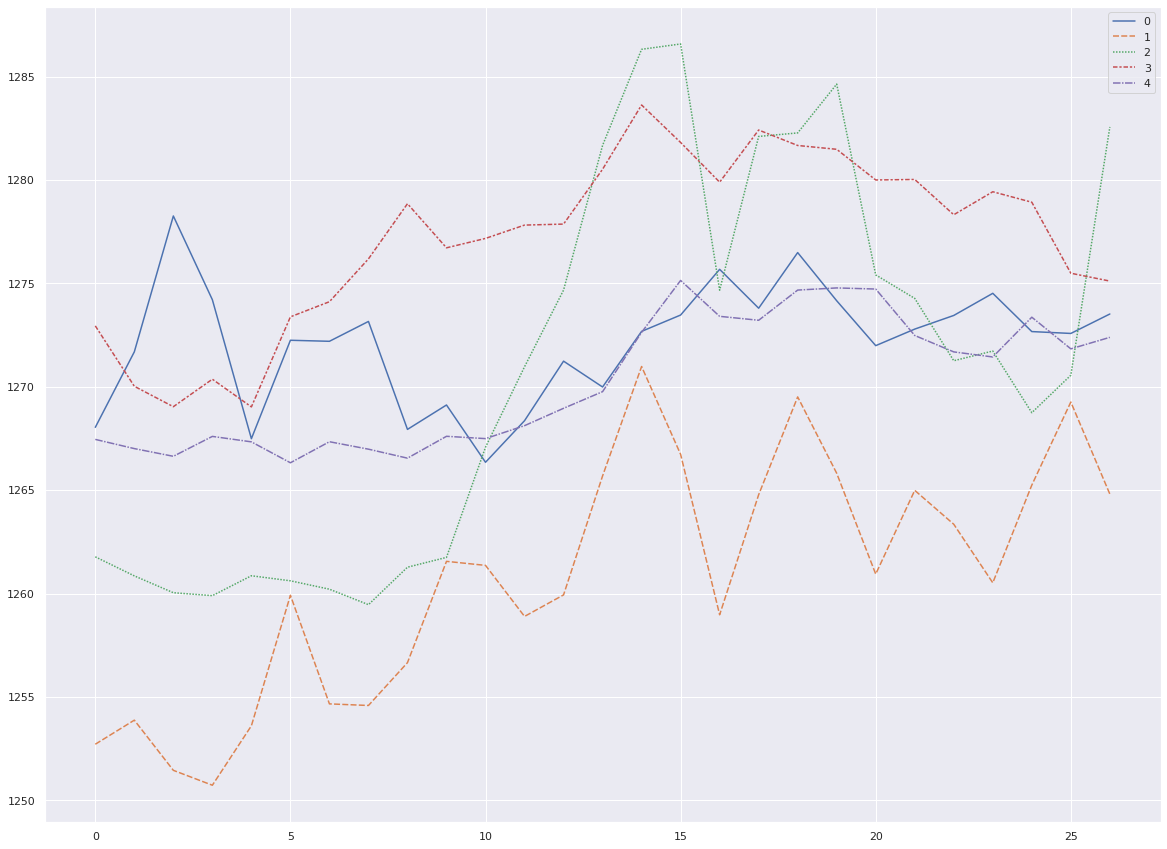

In [73]:
fig, ax = plt.subplots(1,1,figsize=(20,15))
sns.lineplot(data=viz, ax=ax,legend="full")
# sns.lineplot(data=actual_yhat_test_lin, ax=ax,legend="full")
# sns.lineplot(data=actual_yhat_test_rfr, ax=ax,legend="full")
# sns.lineplot(data=actual_yhat_test_svr, ax=ax,legend="full")
# sns.lineplot(data=actual_yhat_test_dnn, ax=ax,legend="full")
plt.legend()
plt.show()

## Try prophet

In [441]:
import ccxt # can try predicting from the minute data?
ex = ccxt.binance()
from_ts = ex.parse8601('2022-08-21 00:00:00') #'2022-05-21 00:00:00'
ohlcv_list = []
ohlcv = ex.fetch_ohlcv('ETH/USDT', '1h', since=from_ts, limit=1000)
# print(ohlcv)
ohlcv_list.extend(ohlcv)
# print(ohlcv_list)
while(True):
    from_ts = ohlcv_list[-1][0]
#     print("=" * 50)
#     print(ohlcv_list[:-5:-1])
#     print(from_ts)
    new_ohlcv = ex.fetch_ohlcv('ETH/USDT', '5m', since=from_ts, limit=1000)
#     print(f"len :{len(new_ohlcv)}")
#     print(new_ohlcv[-5:-1])
    ohlcv_list.extend(new_ohlcv)
#     print(ohlcv_list[-5:-1])
    if(len(new_ohlcv) < 1000):
        break
# cex_x = ex.fetch_ohlcv('ETH/USDT', '1h')
# print(cex_x)
cex_x = ohlcv_list
# print(cex_x)

allcex_uts = [xi[0]/1000 for xi in cex_x] # timestamps
allcex_vals = [xi[4] for xi in cex_x] # ETH prices

# # Extracts dates and ether price values
print_datetime_info("CEX data info", allcex_uts)

# Transform timestamps to dates
dts = to_datetimes(allcex_uts)


# create a Data Frame with two columns [date,eth-prices] with dates given in intervals of 1-hour
import pandas as pd
data = pd.DataFrame({"ds": dts, "y": allcex_vals})


CEX data info:
  starts on: 2022/08/21, 00:00:00
    ends on: 2022/12/11, 22:55:00
  21564 datapoints
  time interval between datapoints: 1:00:00


In [344]:
data.head()

ds        y
0 2022-08-21 00:00:00  1576.79
1 2022-08-21 01:00:00  1594.49
2 2022-08-21 02:00:00  1594.90
3 2022-08-21 03:00:00  1585.57
4 2022-08-21 04:00:00  1583.42

In [233]:
cex_x

[[1653091200000, 1959.08, 1973.95, 1956.14, 1963.41, 14232.7649],
 [1653094800000, 1963.41, 1965.41, 1937.36, 1951.93, 19711.081],
 [1653098400000, 1951.92, 1962.57, 1944.29, 1959.4, 8416.9029],
 [1653102000000, 1959.39, 1969.95, 1949.66, 1967.75, 9089.28],
 [1653105600000, 1967.74, 1969.43, 1962.0, 1965.17, 6704.3441],
 [1653109200000, 1965.18, 1969.51, 1961.23, 1966.94, 10879.6461],
 [1653112800000, 1966.94, 1974.1, 1961.99, 1972.08, 9272.1019],
 [1653116400000, 1972.08, 1986.57, 1965.21, 1978.63, 12482.2416],
 [1653120000000, 1978.63, 1988.48, 1976.85, 1978.79, 9136.2071],
 [1653123600000, 1978.78, 1979.49, 1966.97, 1973.41, 7427.7638],
 [1653127200000, 1973.41, 1978.79, 1965.77, 1970.84, 8310.4719],
 [1653130800000, 1970.85, 1972.8, 1956.58, 1970.46, 8887.3141],
 [1653134400000, 1970.47, 1975.76, 1961.8, 1970.29, 8088.048],
 [1653138000000, 1970.3, 1977.0, 1964.77, 1969.37, 6990.3691],
 [1653141600000, 1969.37, 1983.25, 1959.18, 1978.0, 13851.9768],
 [1653145200000, 1977.99, 1985.4

In [200]:
# Let's see if prophet is good enuf for many different weeks and months
weeks = [g for n, g in data.groupby(pd.Grouper(key='ds',freq='W'))]
months = [g for n, g in data.groupby(pd.Grouper(key='ds',freq='M'))]

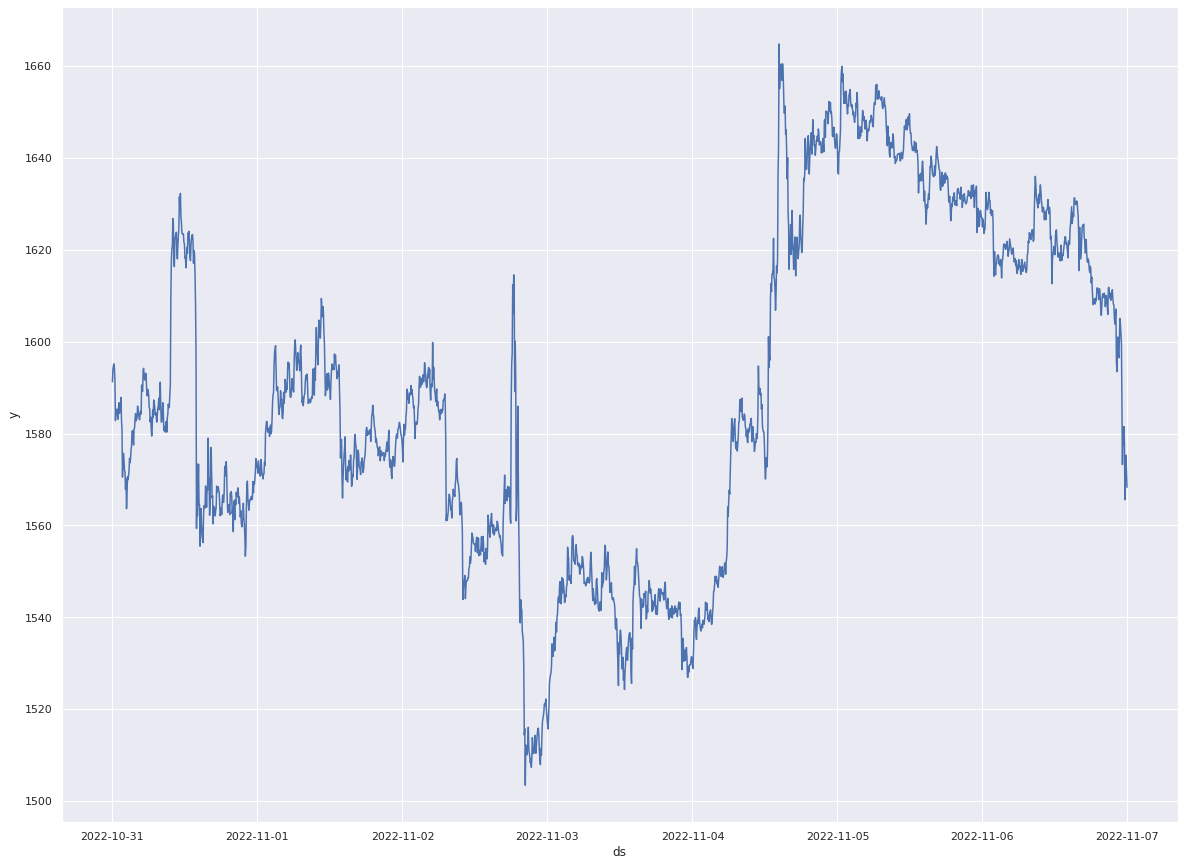

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


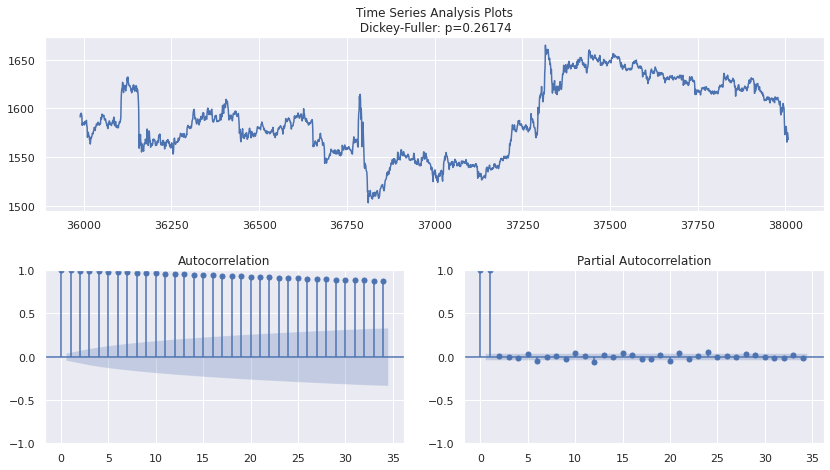

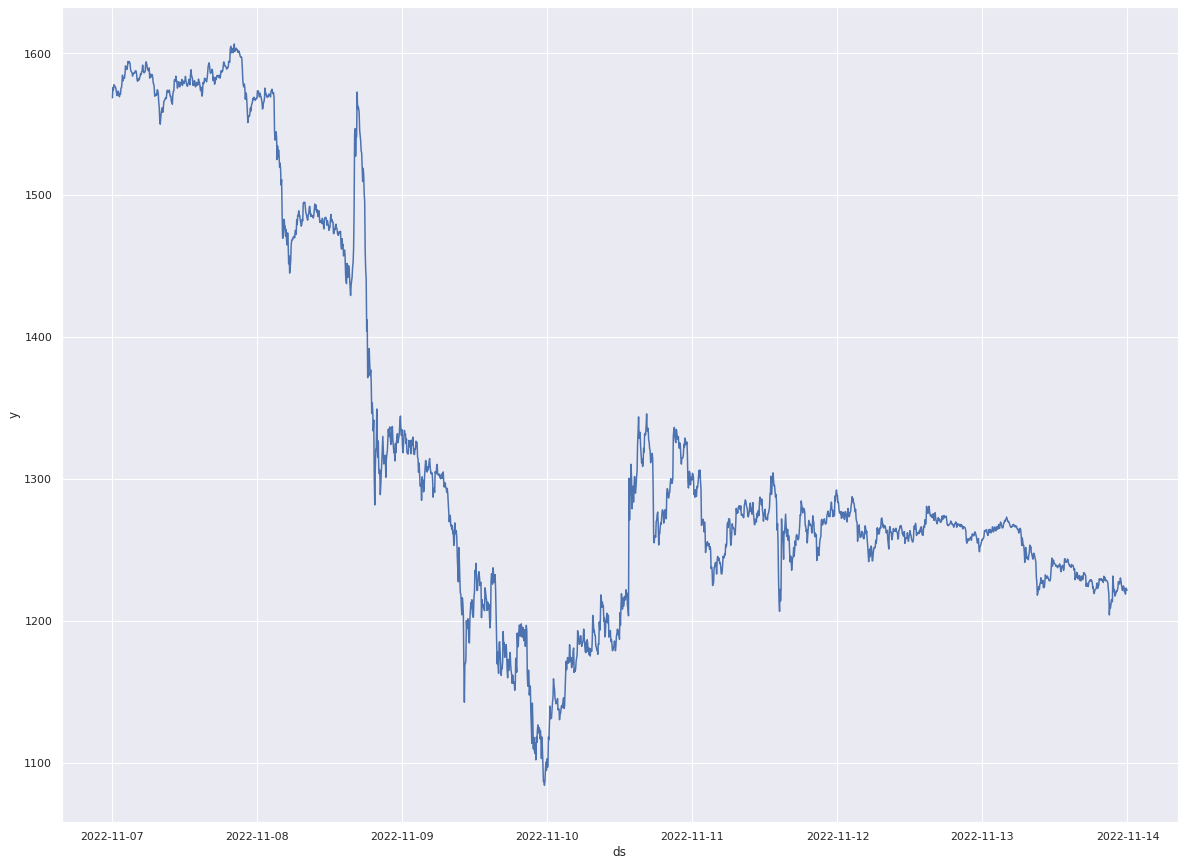

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


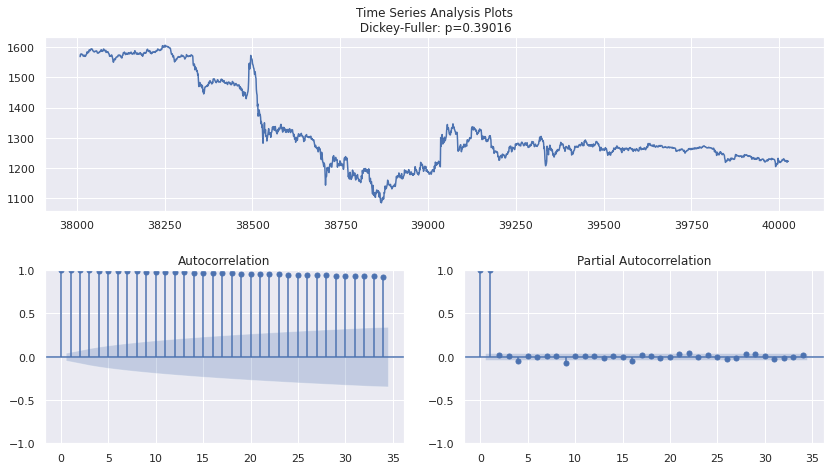

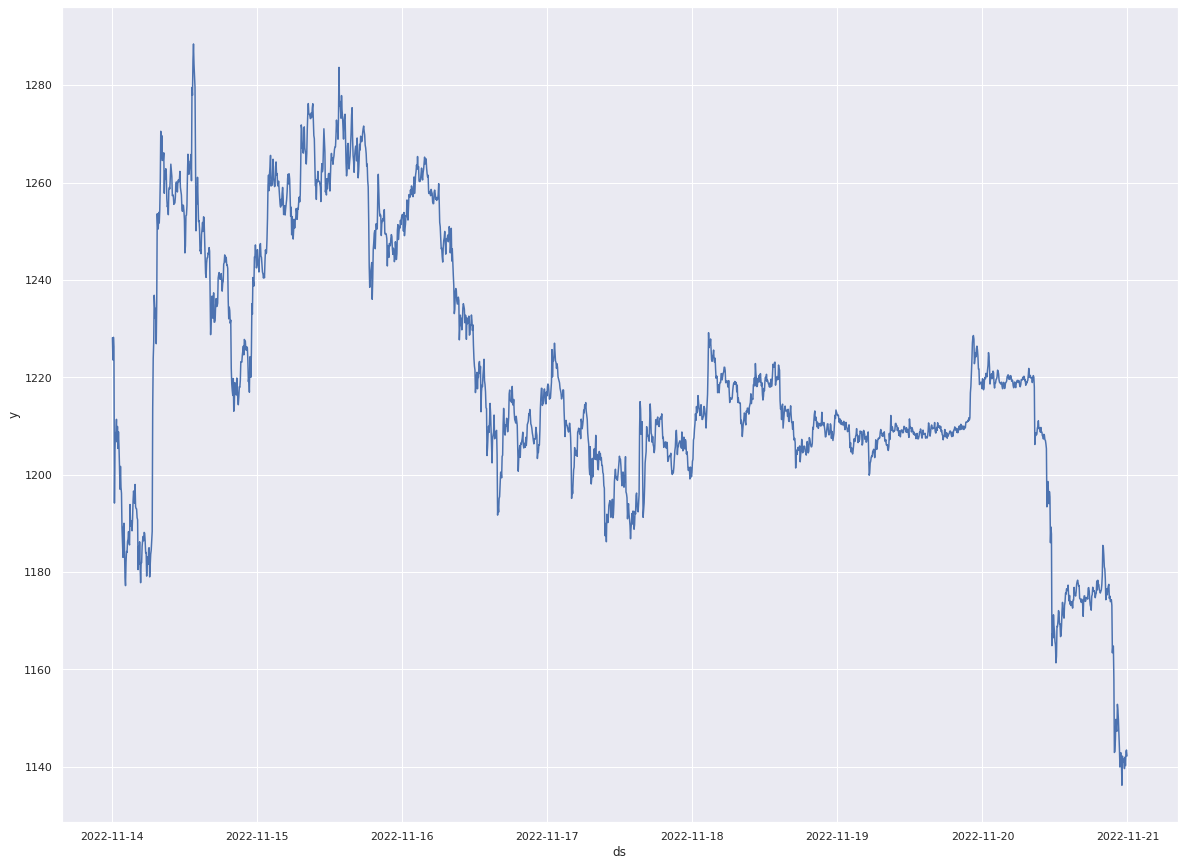

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


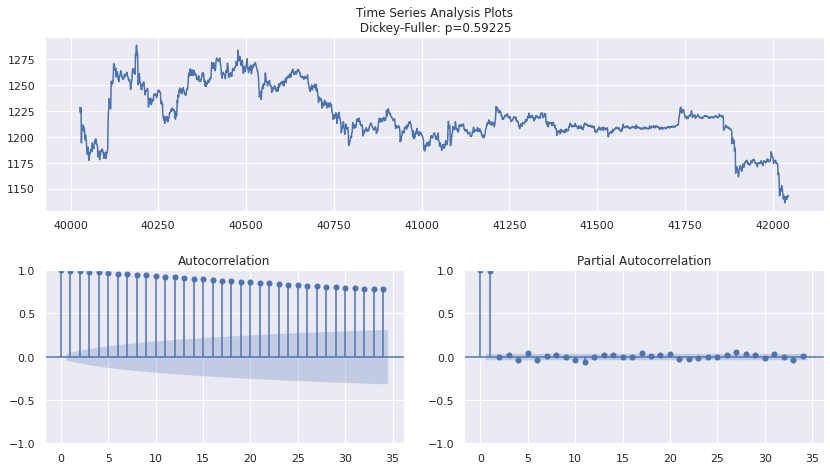

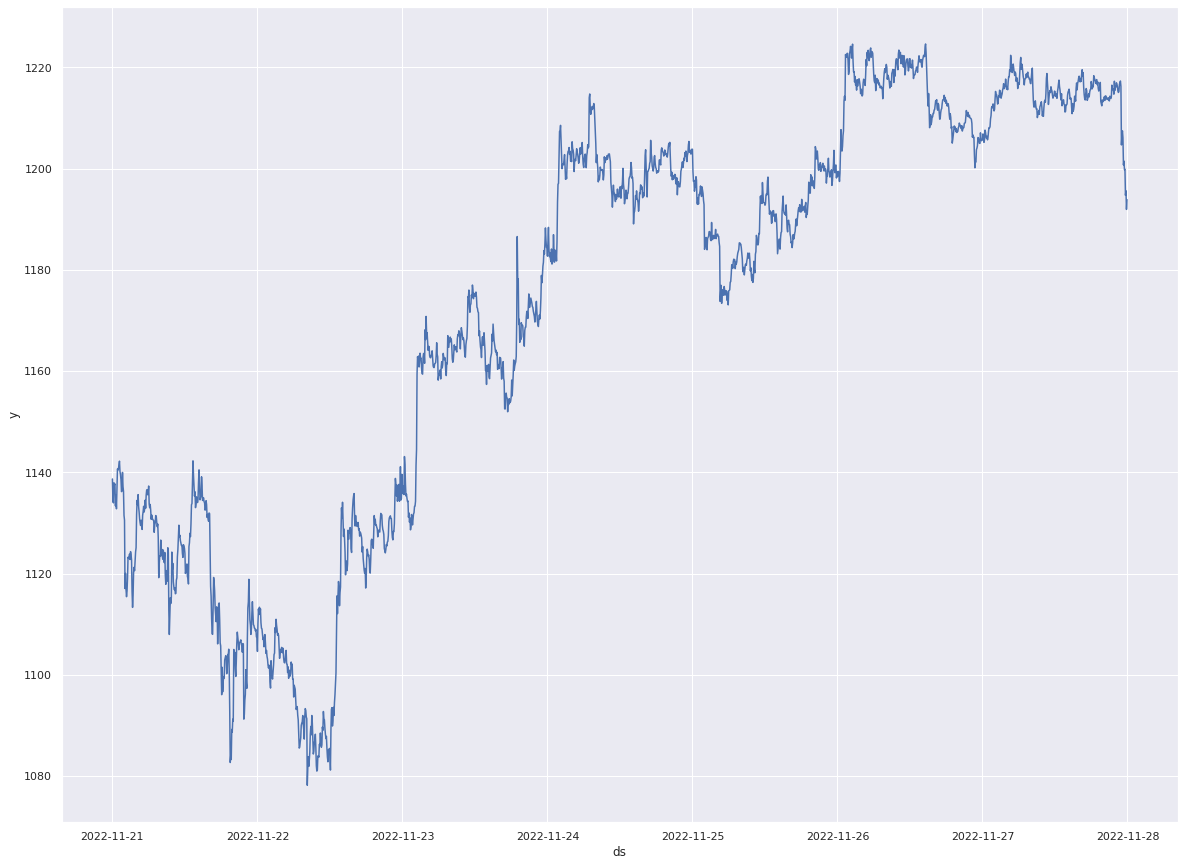

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


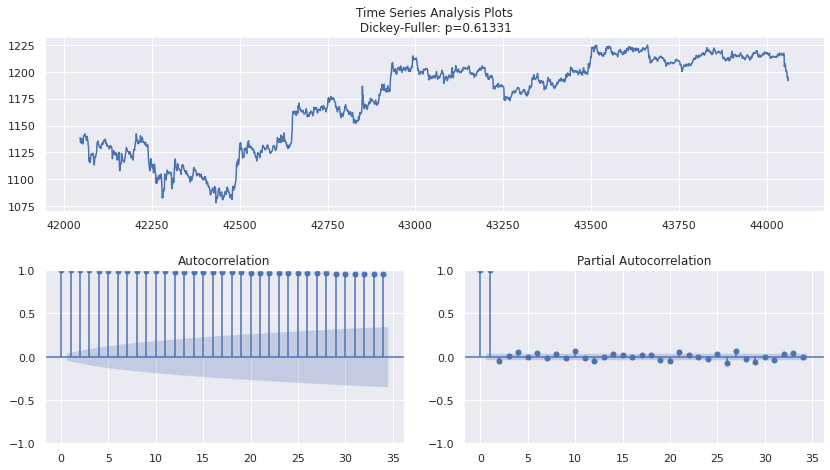

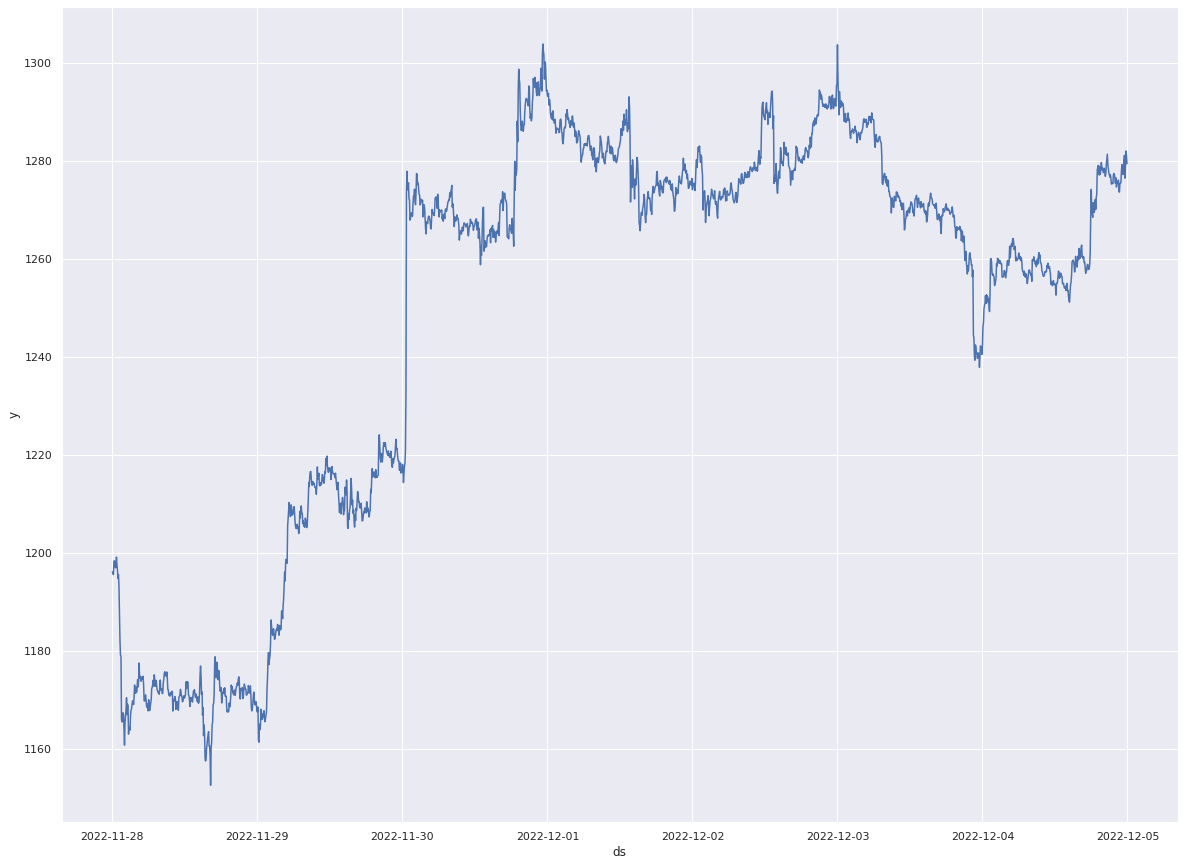

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


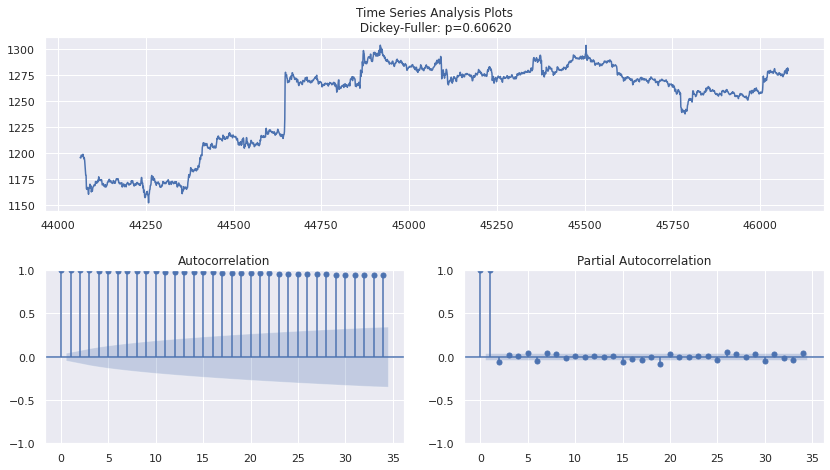

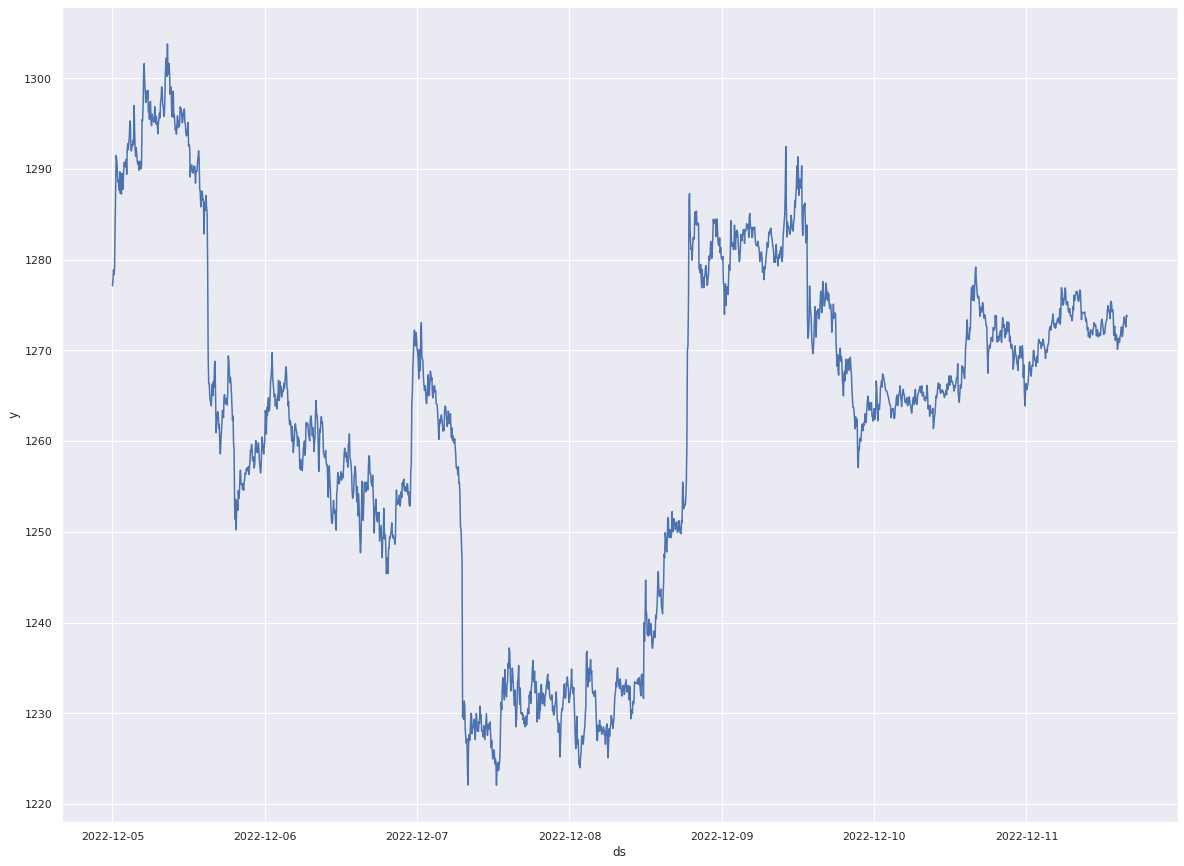

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


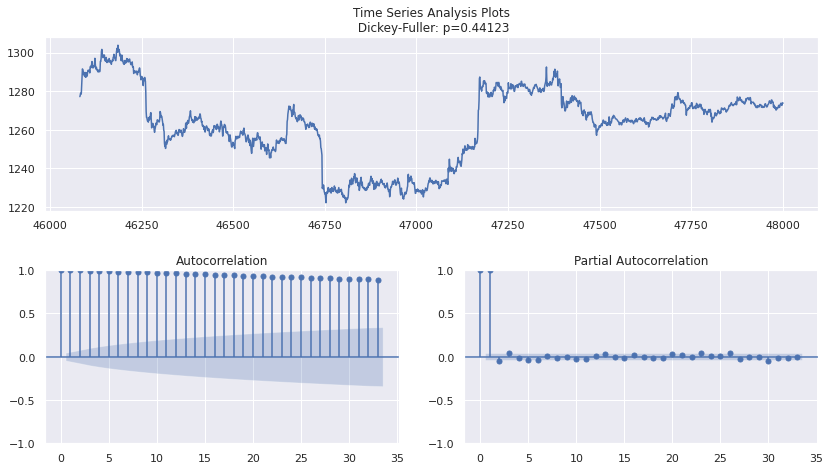

In [214]:

for i in range(len(weeks)-6, len(weeks)):
#     print(w)
    fig, ax = plt.subplots(1,1,figsize=(20,15))
    w = weeks[i]
    sns.lineplot(data=w, x="ds",y="y", ax=ax)
    
    plt.show()
    tsplot(w['y'])

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/1xfa0nrr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/kabvfos7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25781', 'data', 'file=/tmp/tmpmu0vbl24/1xfa0nrr.json', 'init=/tmp/tmpmu0vbl24/kabvfos7.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modellnz7xuko/prophet_model-20221212065216.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:52:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
0

20
NMSE = 1.9368453966344352e-05


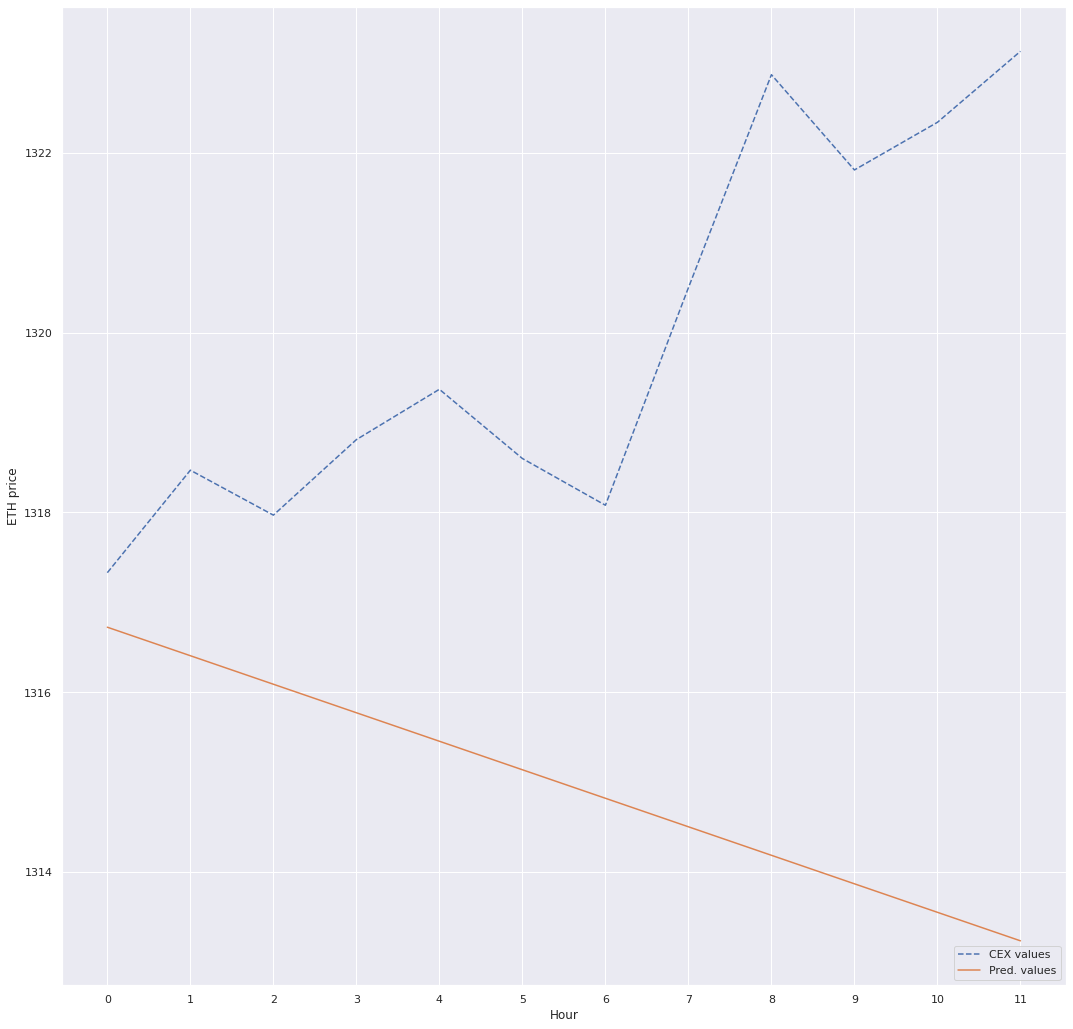

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/ri_kidra.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/zp5tjkeq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9360', 'data', 'file=/tmp/tmpmu0vbl24/ri_kidra.json', 'init=/tmp/tmpmu0vbl24/zp5tjkeq.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelz7kv2ykf/prophet_model-20221212065216.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:52:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06

21
NMSE = 5.198027714836065e-05


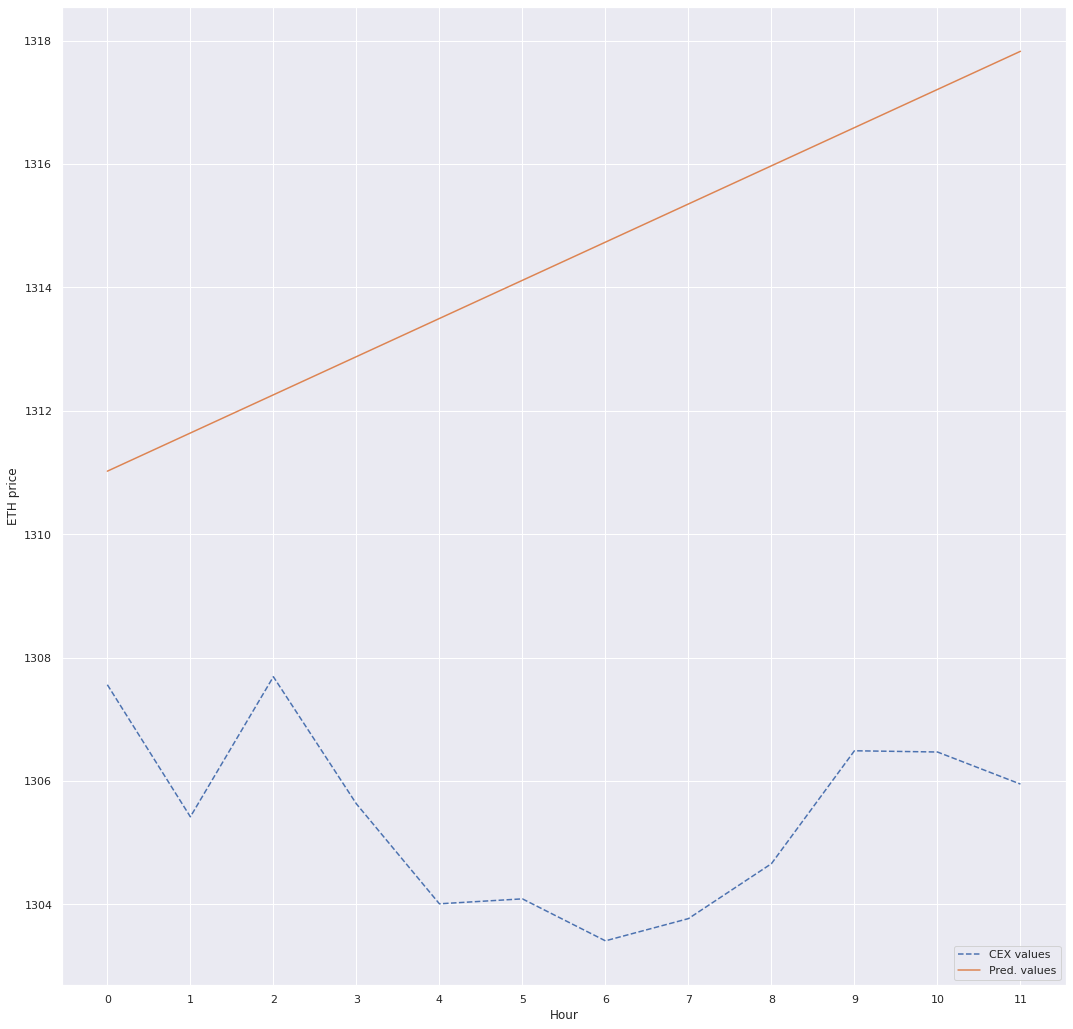

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/iqvk1q_q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/tv39diau.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57776', 'data', 'file=/tmp/tmpmu0vbl24/iqvk1q_q.json', 'init=/tmp/tmpmu0vbl24/tv39diau.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model6ld3vbq7/prophet_model-20221212065216.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:52:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
0

22
NMSE = 0.00028513508657205123


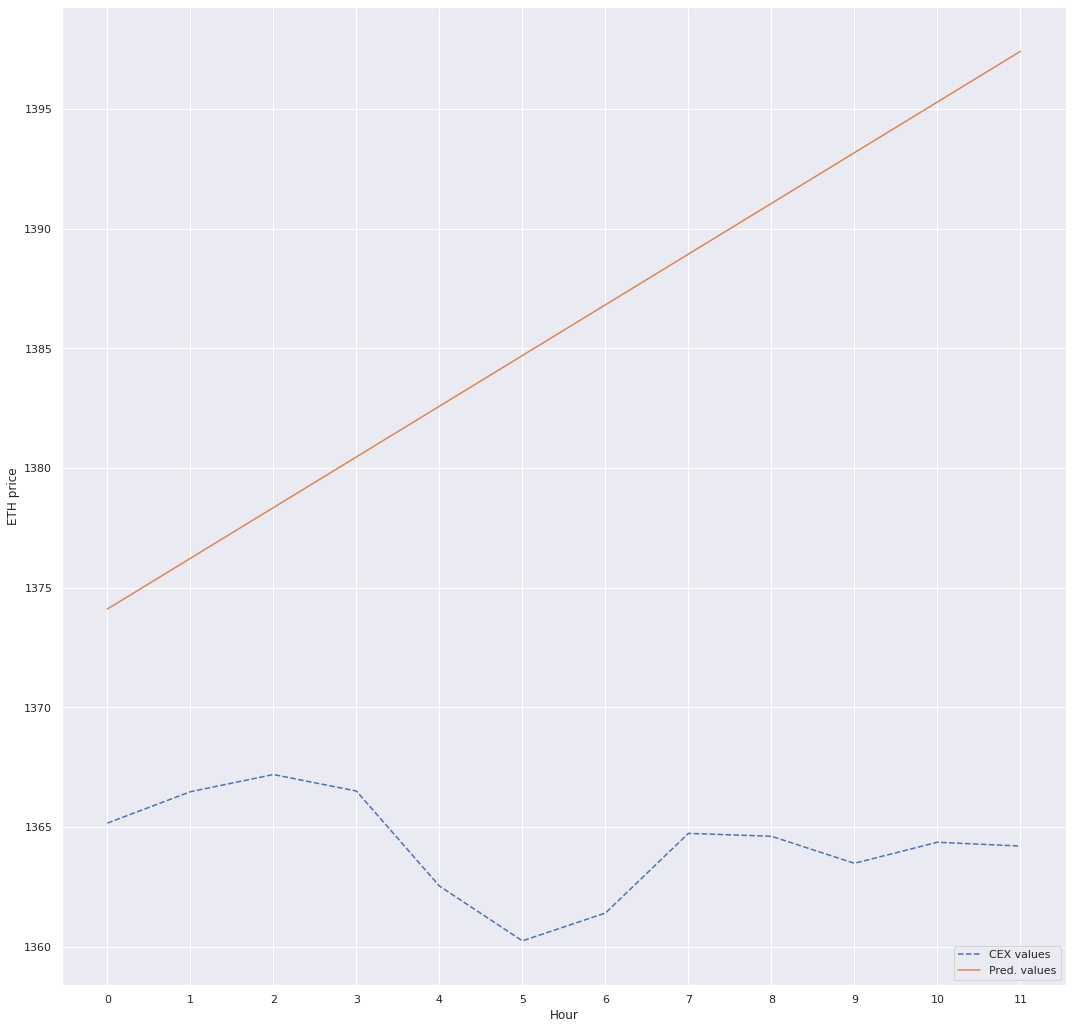

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/leo6wkkb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/uxnk6pix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67175', 'data', 'file=/tmp/tmpmu0vbl24/leo6wkkb.json', 'init=/tmp/tmpmu0vbl24/uxnk6pix.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelbbbzmjlw/prophet_model-20221212065216.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:52:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
0

23
NMSE = 4.581196112804919e-06


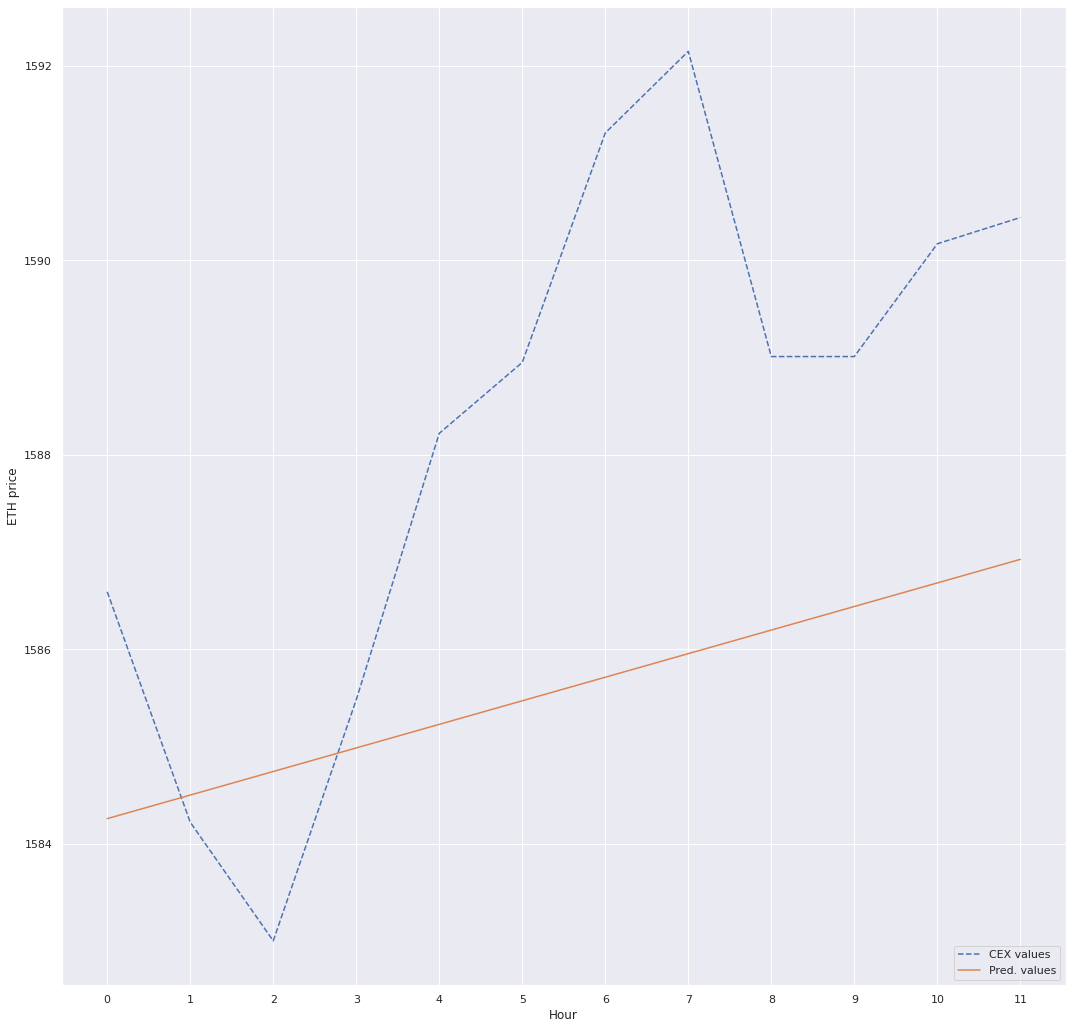

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/9wostx3u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/2mp5ik4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50344', 'data', 'file=/tmp/tmpmu0vbl24/9wostx3u.json', 'init=/tmp/tmpmu0vbl24/2mp5ik4e.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelgyoido25/prophet_model-20221212065217.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:52:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
0

24
NMSE = 0.0003810325653449041


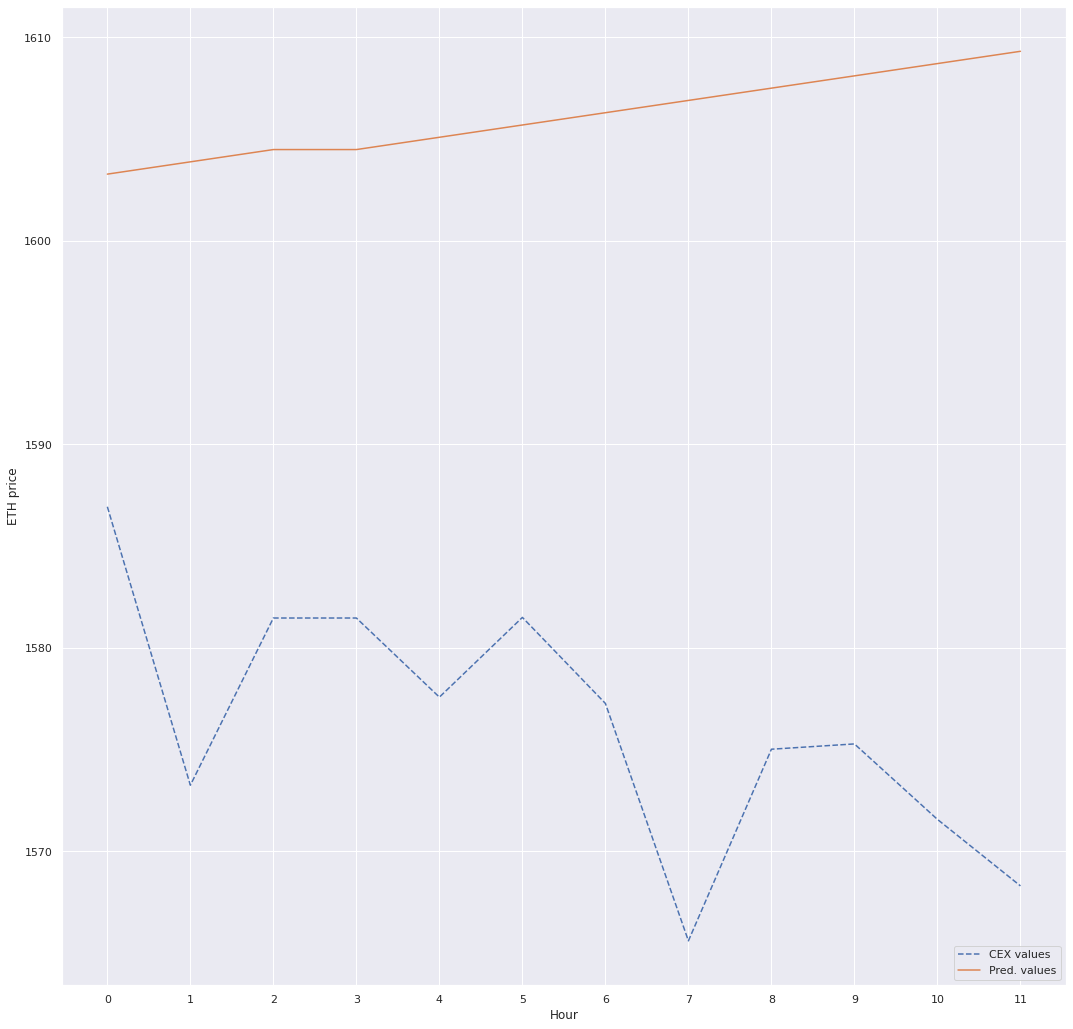

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/swuz1ouh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/khjkr81g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97430', 'data', 'file=/tmp/tmpmu0vbl24/swuz1ouh.json', 'init=/tmp/tmpmu0vbl24/khjkr81g.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelfq7fkkc_/prophet_model-20221212065217.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:52:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
0

25
NMSE = 0.00014024295311885945


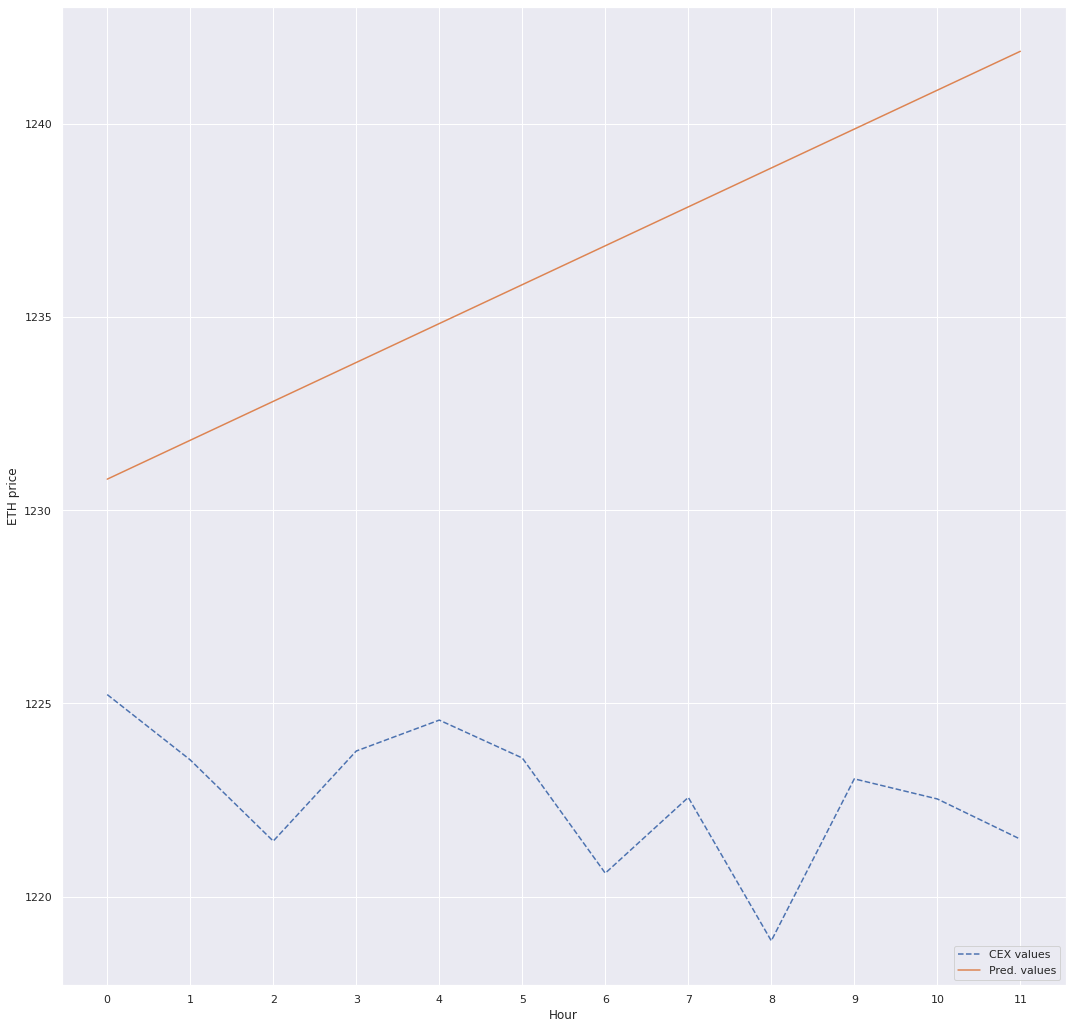

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/59ndj5by.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/zh2zab10.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88109', 'data', 'file=/tmp/tmpmu0vbl24/59ndj5by.json', 'init=/tmp/tmpmu0vbl24/zh2zab10.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model_qfvfbpi/prophet_model-20221212065217.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:52:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
0

26
NMSE = 8.6146463183912e-06


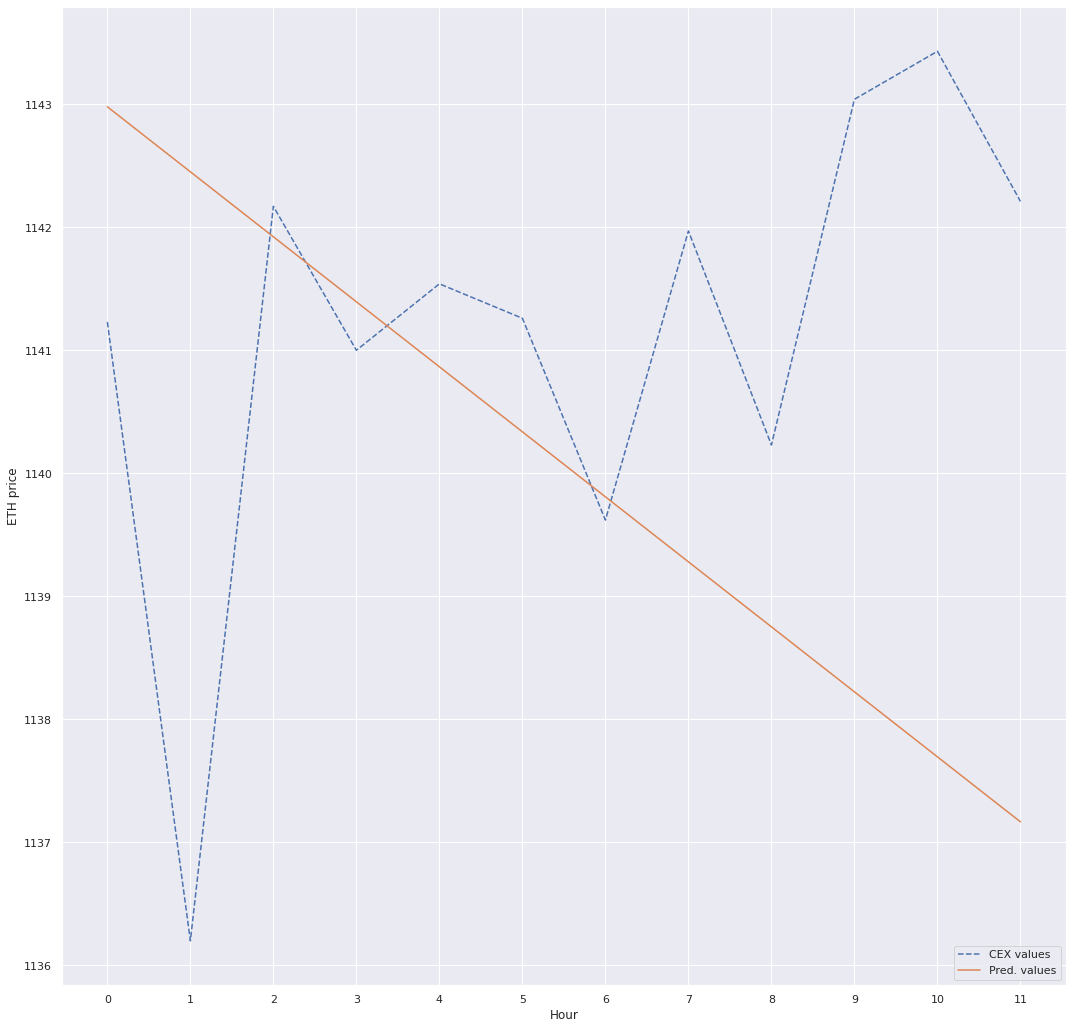

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/mk0nrnzw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/rgn6ztv4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15658', 'data', 'file=/tmp/tmpmu0vbl24/mk0nrnzw.json', 'init=/tmp/tmpmu0vbl24/rgn6ztv4.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelggp81r1h/prophet_model-20221212065217.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:52:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
0

27
NMSE = 0.00020511346700133876


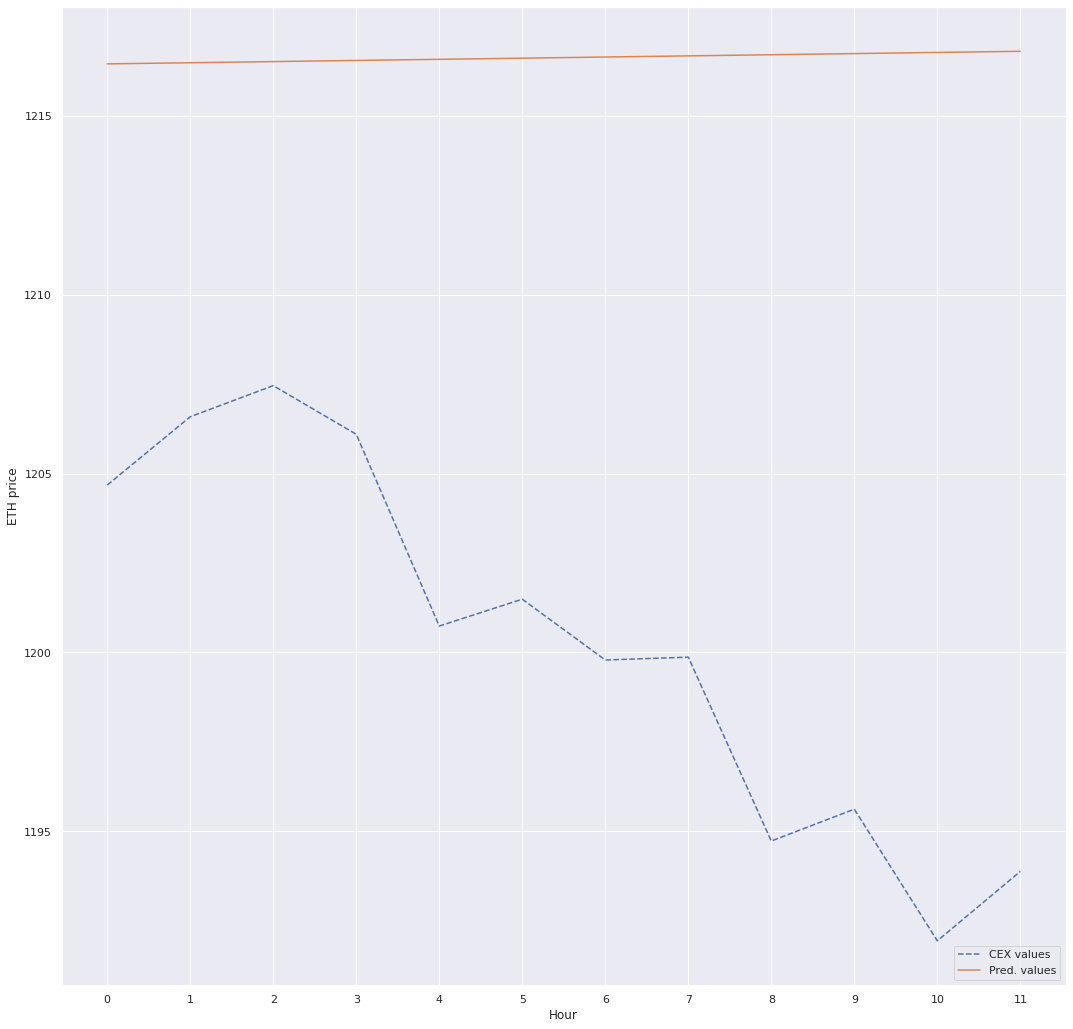

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/6c117yh7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/go144x7p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23399', 'data', 'file=/tmp/tmpmu0vbl24/6c117yh7.json', 'init=/tmp/tmpmu0vbl24/go144x7p.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelws1w9u36/prophet_model-20221212065218.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:52:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
0

28
NMSE = 1.4989608300717672e-05


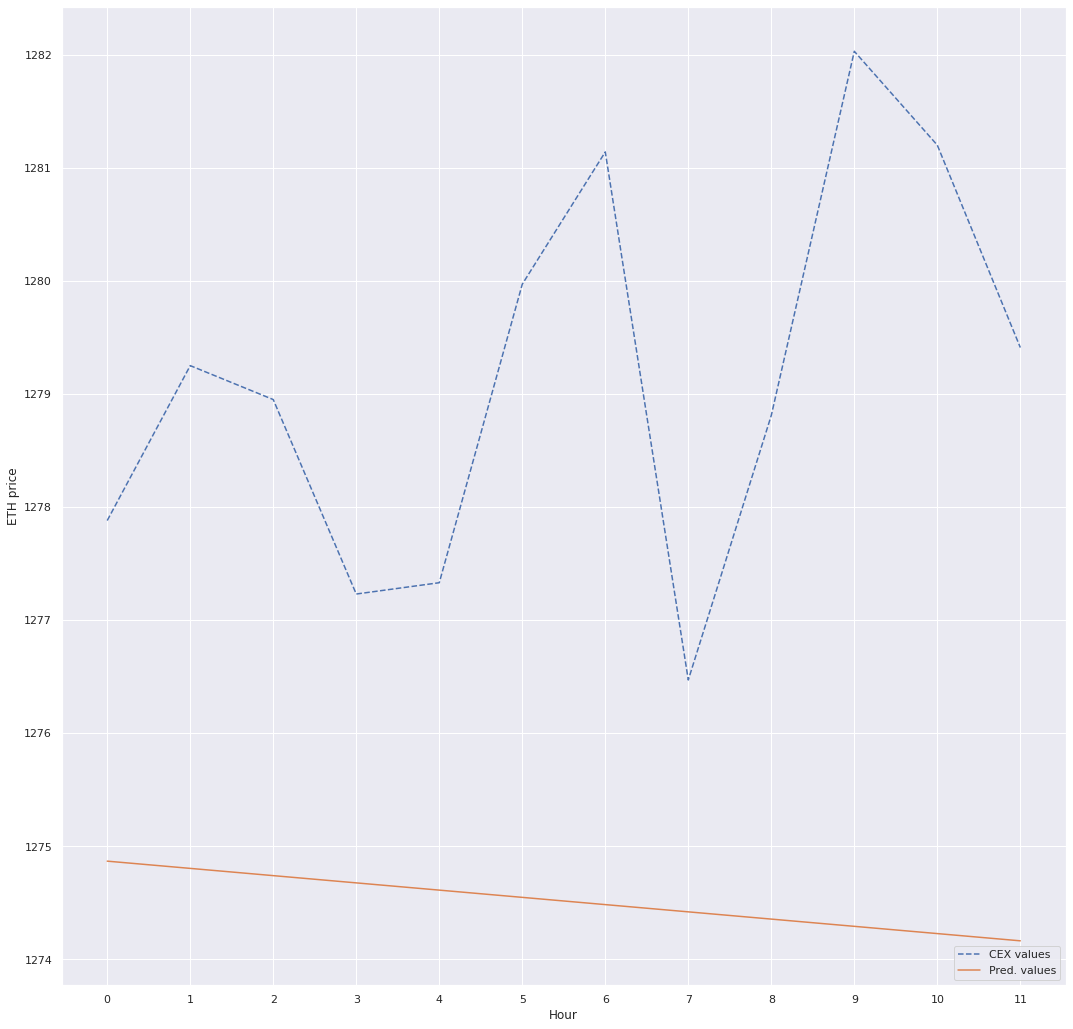

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/eq2jk7as.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/_bwcpp3t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64921', 'data', 'file=/tmp/tmpmu0vbl24/eq2jk7as.json', 'init=/tmp/tmpmu0vbl24/_bwcpp3t.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model1p26h1vg/prophet_model-20221212065218.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:52:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
0

29
NMSE = 7.916896712411224e-07


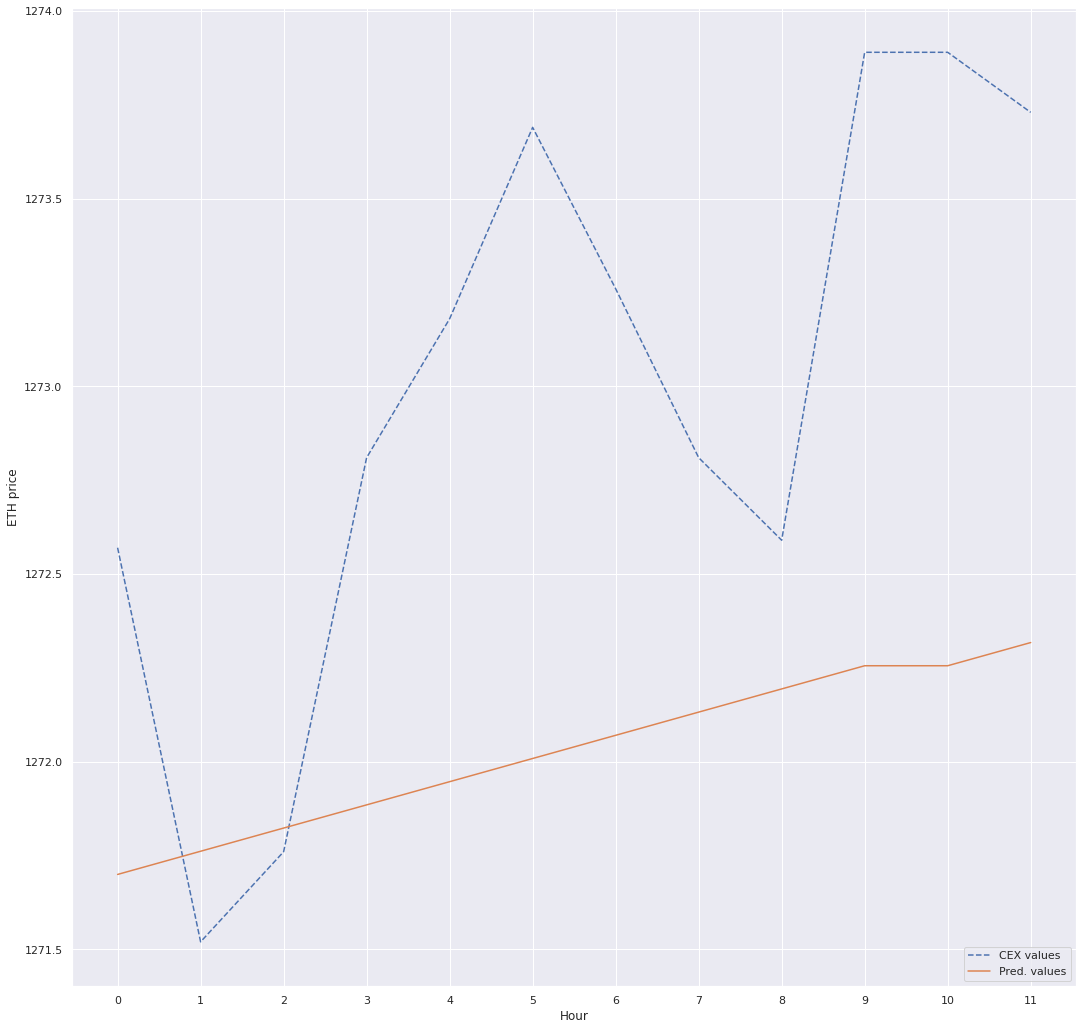

mean weeks nsme: 0.00011118499435550135


In [419]:

start_hour = 24 * 2
NSME_list = []

for i in range(len(weeks)-10, len(weeks)):
    print(i)
    w = weeks[i] 
    last_x_hours = 12
    # use the last 12 hours of testing set, all the previous data is used as training
    train_data = w.iloc[-last_x_hours-start_hour:-last_x_hours,:]
    test_data = w.iloc[-last_x_hours:,:]
    model = Prophet()  #weekly_seasonality=True,  # daily_seasonality=True
    model.fit(train_data)
    #Predict ETH values over the range of the test set
    forecast = model.predict(pd.DataFrame({"ds":test_data.ds}))
    pred_vals_test = forecast.set_index('ds')['yhat'][-last_x_hours:].to_numpy()
    # now, we have predicted and actual values. Let's find error, and plot!
    cex_vals = test_data.y
    nmse = calc_nmse(cex_vals, pred_vals_test)
    print(f"NMSE = {nmse}")
    NSME_list.append(nmse)
    plot_prices(cex_vals, pred_vals_test,last_x_hours)
    
print("=" * 10)
print(f"mean weeks nsme: {np.mean(NSME_list)}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/6u48jtef.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/7m71obhi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33706', 'data', 'file=/tmp/tmpmu0vbl24/6u48jtef.json', 'init=/tmp/tmpmu0vbl24/7m71obhi.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelrca7pkbk/prophet_model-20221212024101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:41:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:41:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 4.7956439340408935e-05


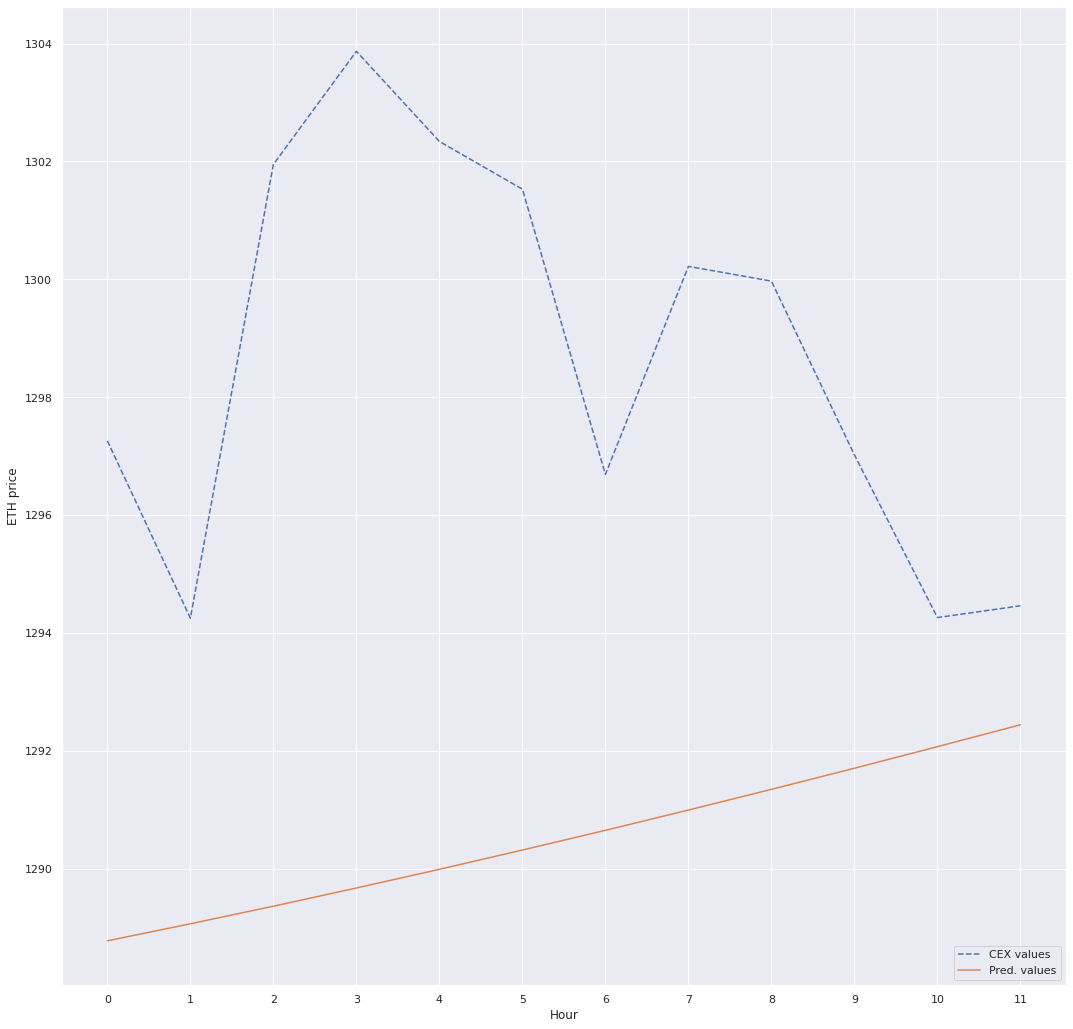

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/911ixrk0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/wkkxclbm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44476', 'data', 'file=/tmp/tmpmu0vbl24/911ixrk0.json', 'init=/tmp/tmpmu0vbl24/wkkxclbm.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model1cz_yyp6/prophet_model-20221212024104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:41:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:41:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 5.573581888816463e-06


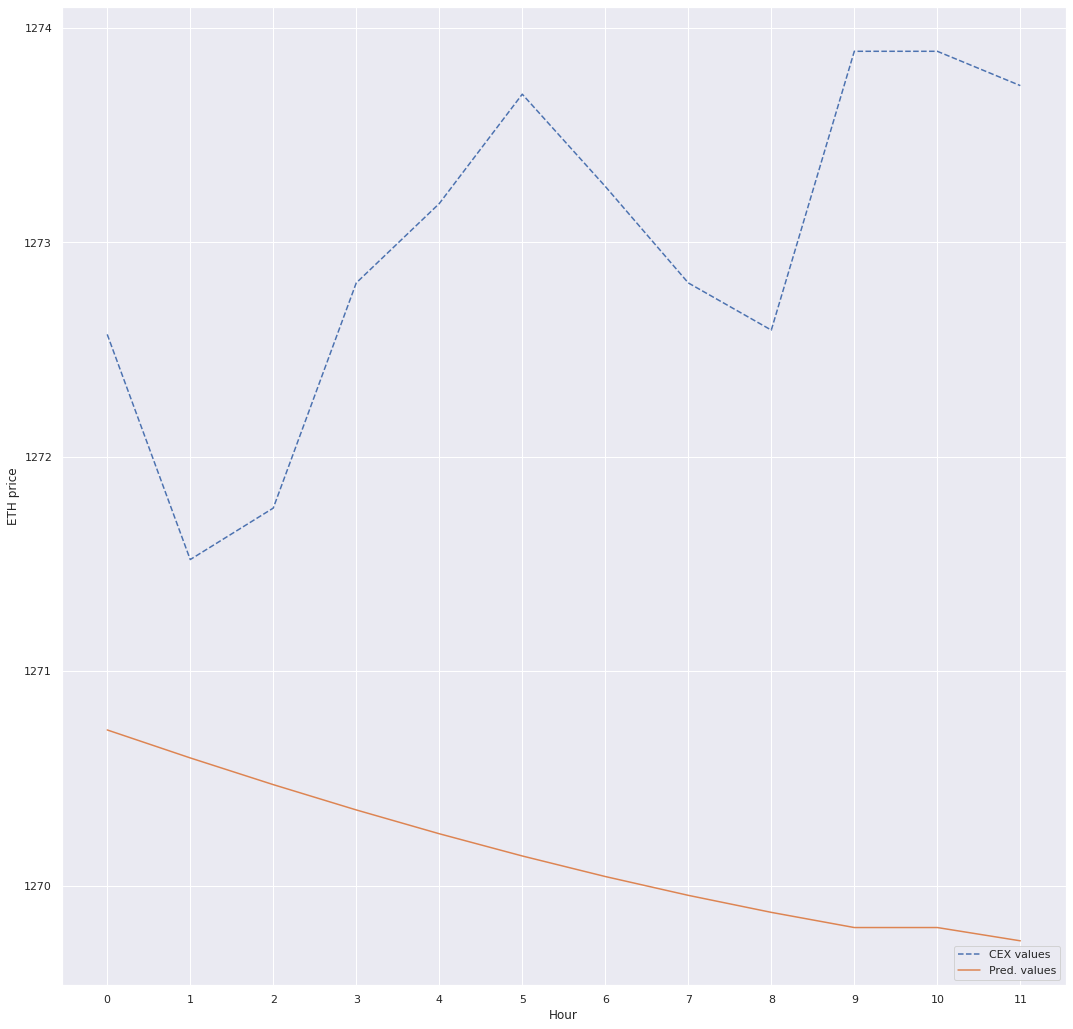

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/yengtb8t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/nccm_1f_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13576', 'data', 'file=/tmp/tmpmu0vbl24/yengtb8t.json', 'init=/tmp/tmpmu0vbl24/nccm_1f_.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelvmqf07eq/prophet_model-20221212024105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:41:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:41:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 0.0017056489420687038


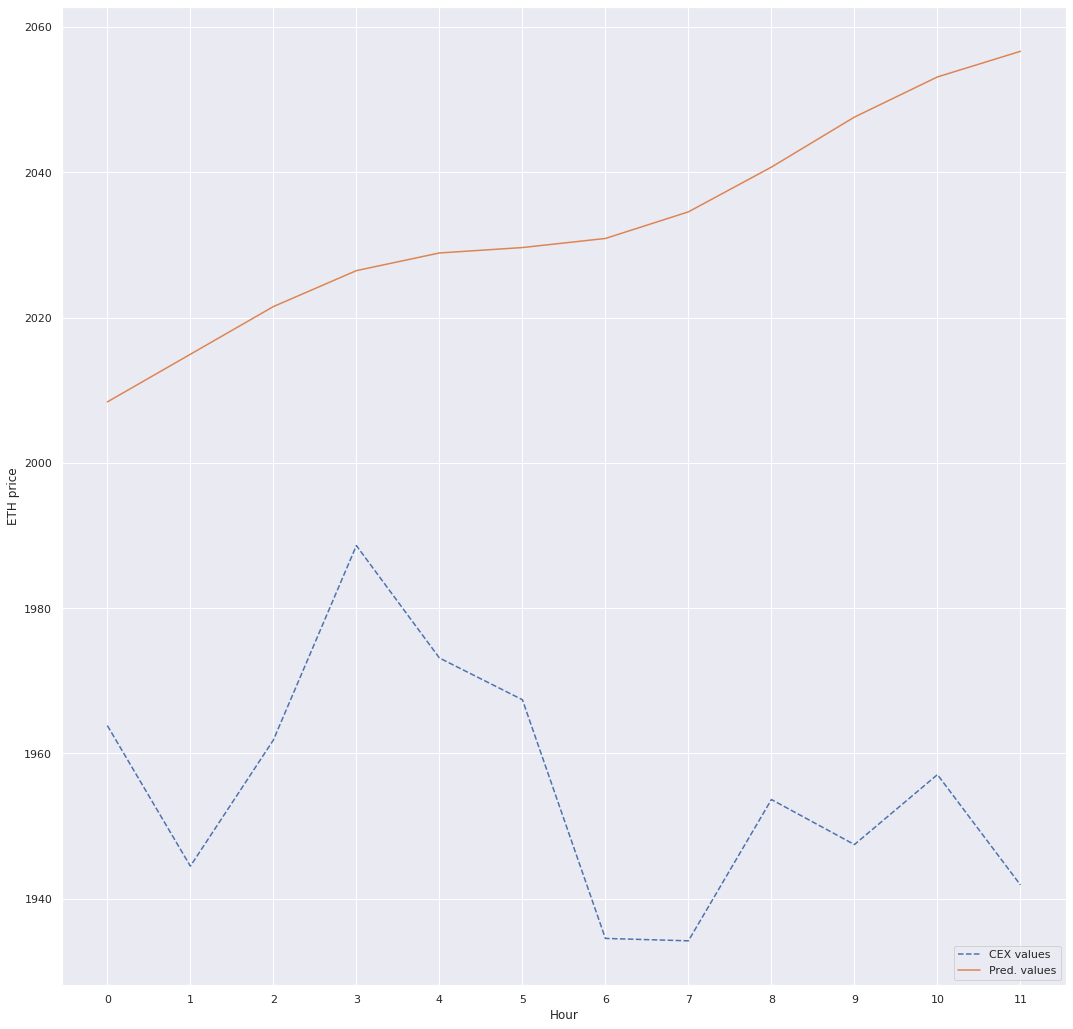

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/t3_oazbk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/_j5ji8o3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38243', 'data', 'file=/tmp/tmpmu0vbl24/t3_oazbk.json', 'init=/tmp/tmpmu0vbl24/_j5ji8o3.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelo0tqlgnz/prophet_model-20221212024106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:41:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:41:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 0.006391070926750876


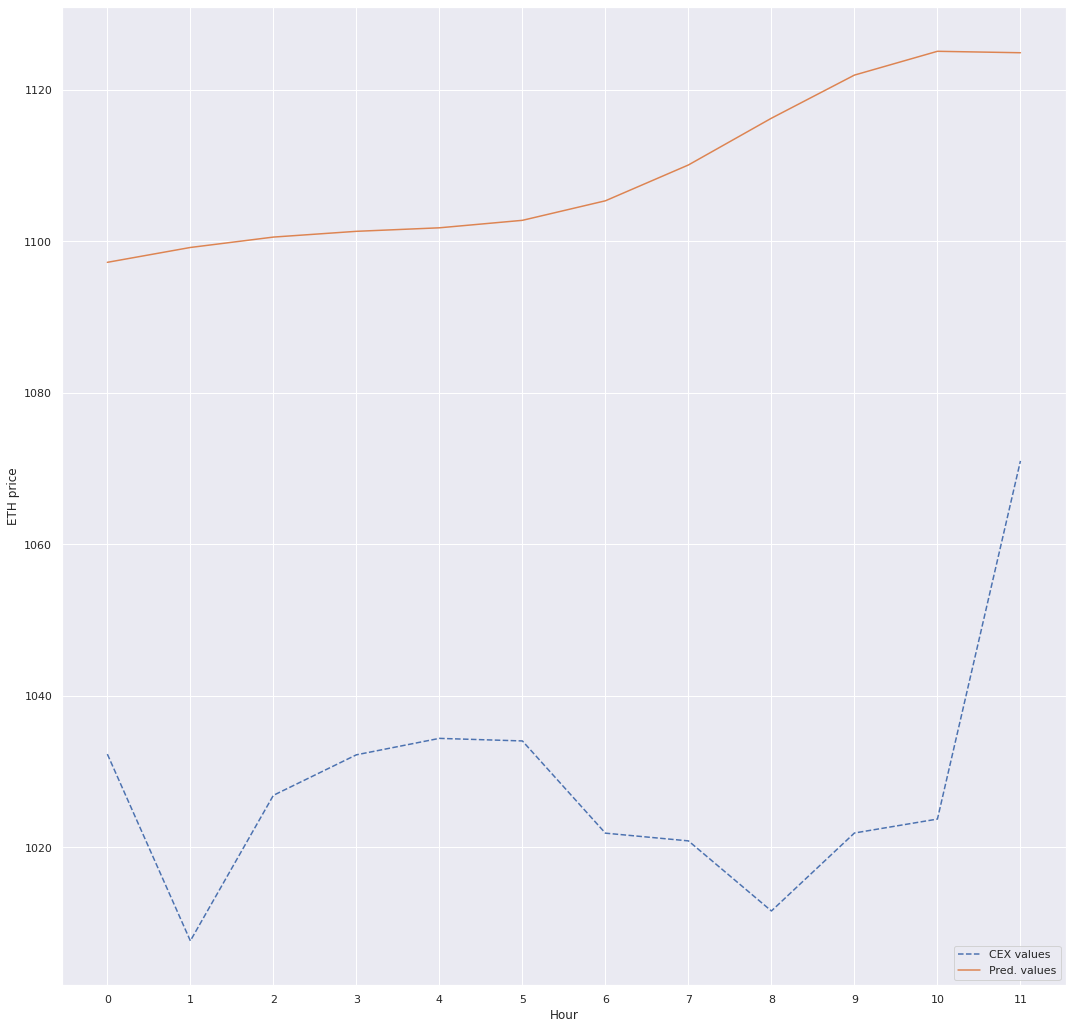

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/857q1xpo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/cxelv7x3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10314', 'data', 'file=/tmp/tmpmu0vbl24/857q1xpo.json', 'init=/tmp/tmpmu0vbl24/cxelv7x3.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelsskkeoj2/prophet_model-20221212024106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:41:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:41:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 0.00026719236751571857


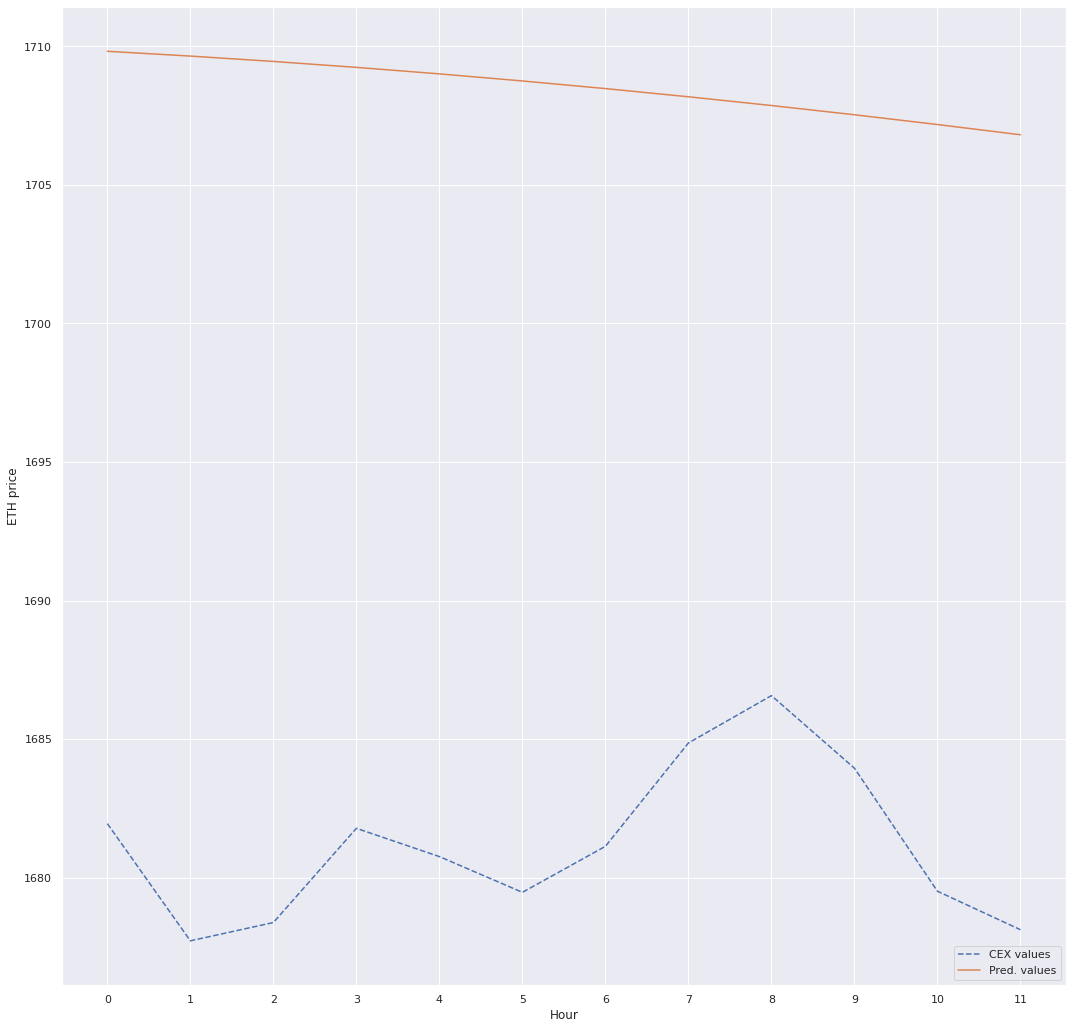

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/9xm_yhhm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/vlijklr6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88252', 'data', 'file=/tmp/tmpmu0vbl24/9xm_yhhm.json', 'init=/tmp/tmpmu0vbl24/vlijklr6.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelns2rphpt/prophet_model-20221212024110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:41:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:41:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 0.00021470138799732215


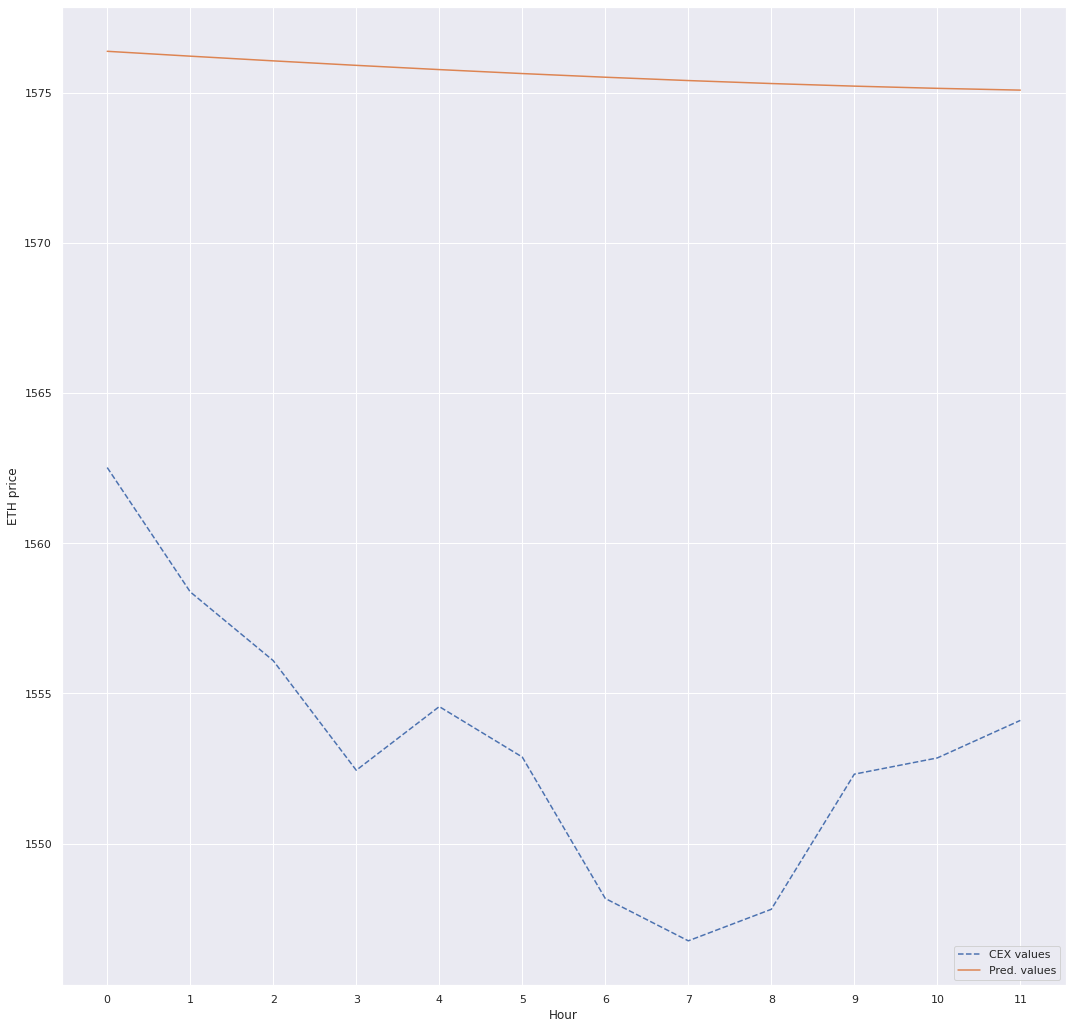

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/6f8z2dxr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/ns637vle.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74105', 'data', 'file=/tmp/tmpmu0vbl24/6f8z2dxr.json', 'init=/tmp/tmpmu0vbl24/ns637vle.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model_2ih10hl/prophet_model-20221212024113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:41:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:41:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 0.0002064471643293748


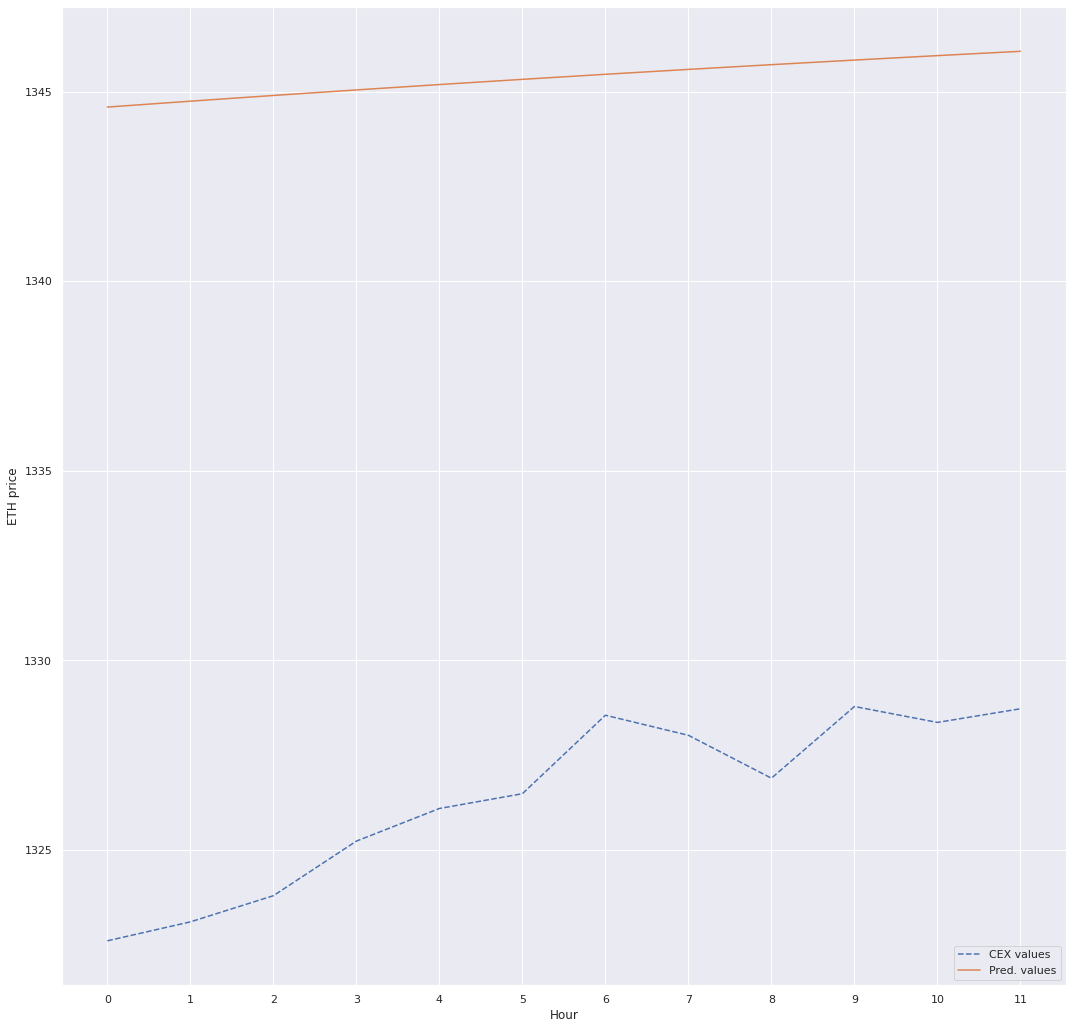

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/xve4ue25.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/f7ypibzk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43455', 'data', 'file=/tmp/tmpmu0vbl24/xve4ue25.json', 'init=/tmp/tmpmu0vbl24/f7ypibzk.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelatsyygve/prophet_model-20221212024116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:41:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:41:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 1.4500990054348417e-05


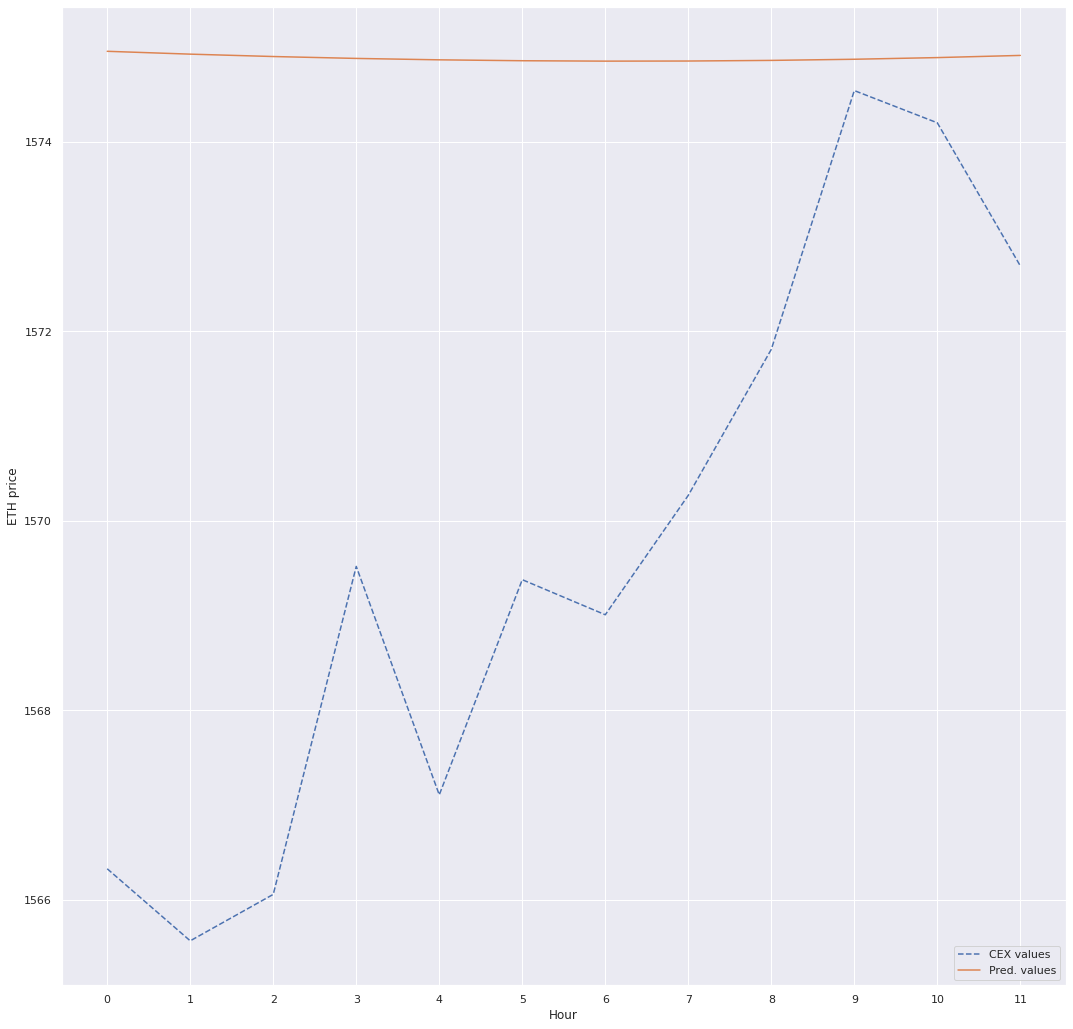

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/wr7mp4oa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/frj8xio4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45226', 'data', 'file=/tmp/tmpmu0vbl24/wr7mp4oa.json', 'init=/tmp/tmpmu0vbl24/frj8xio4.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelq7znzbth/prophet_model-20221212024119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:41:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:41:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 4.7956439340408935e-05


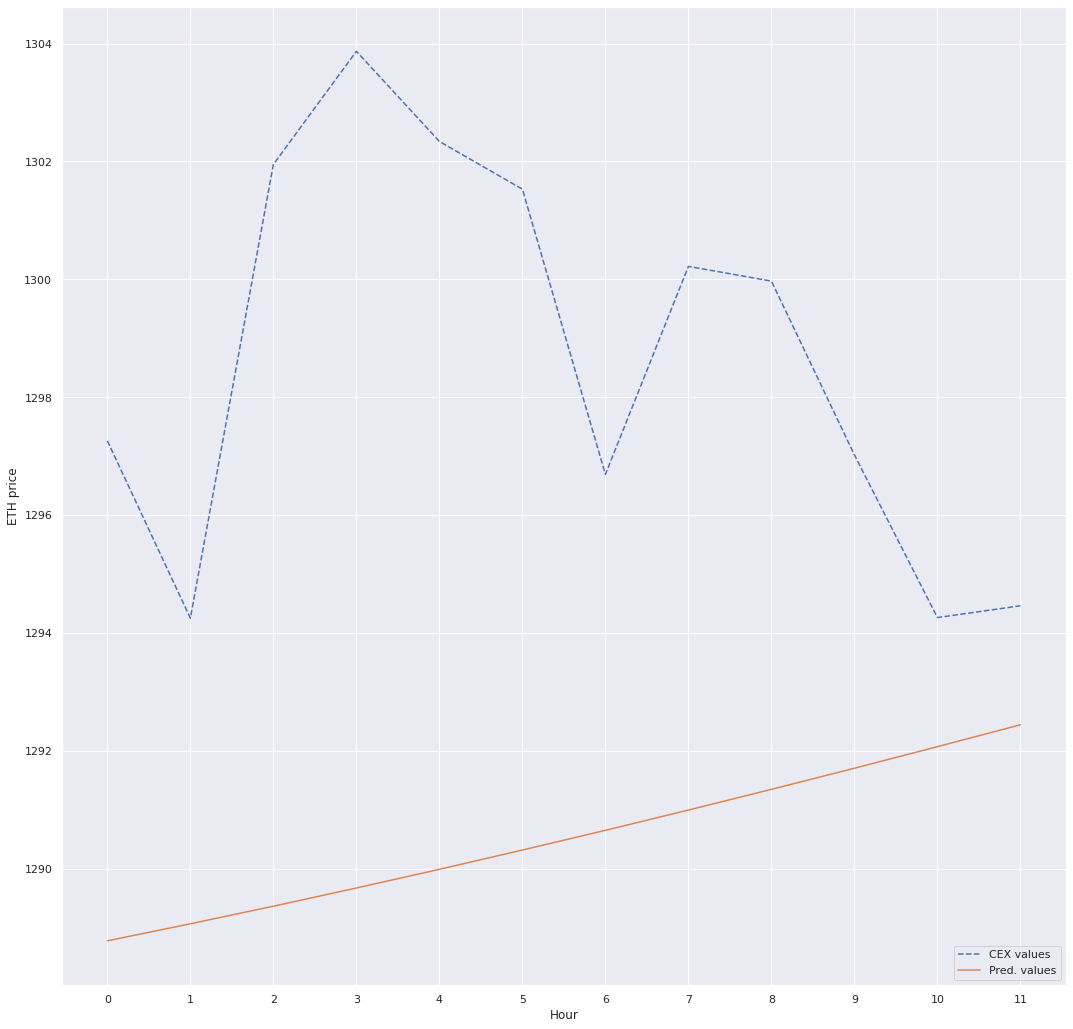

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/w0zeui8c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/wzdm2gaf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84435', 'data', 'file=/tmp/tmpmu0vbl24/w0zeui8c.json', 'init=/tmp/tmpmu0vbl24/wzdm2gaf.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelw5kyo5z2/prophet_model-20221212024122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:41:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:41:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 5.573581888816463e-06


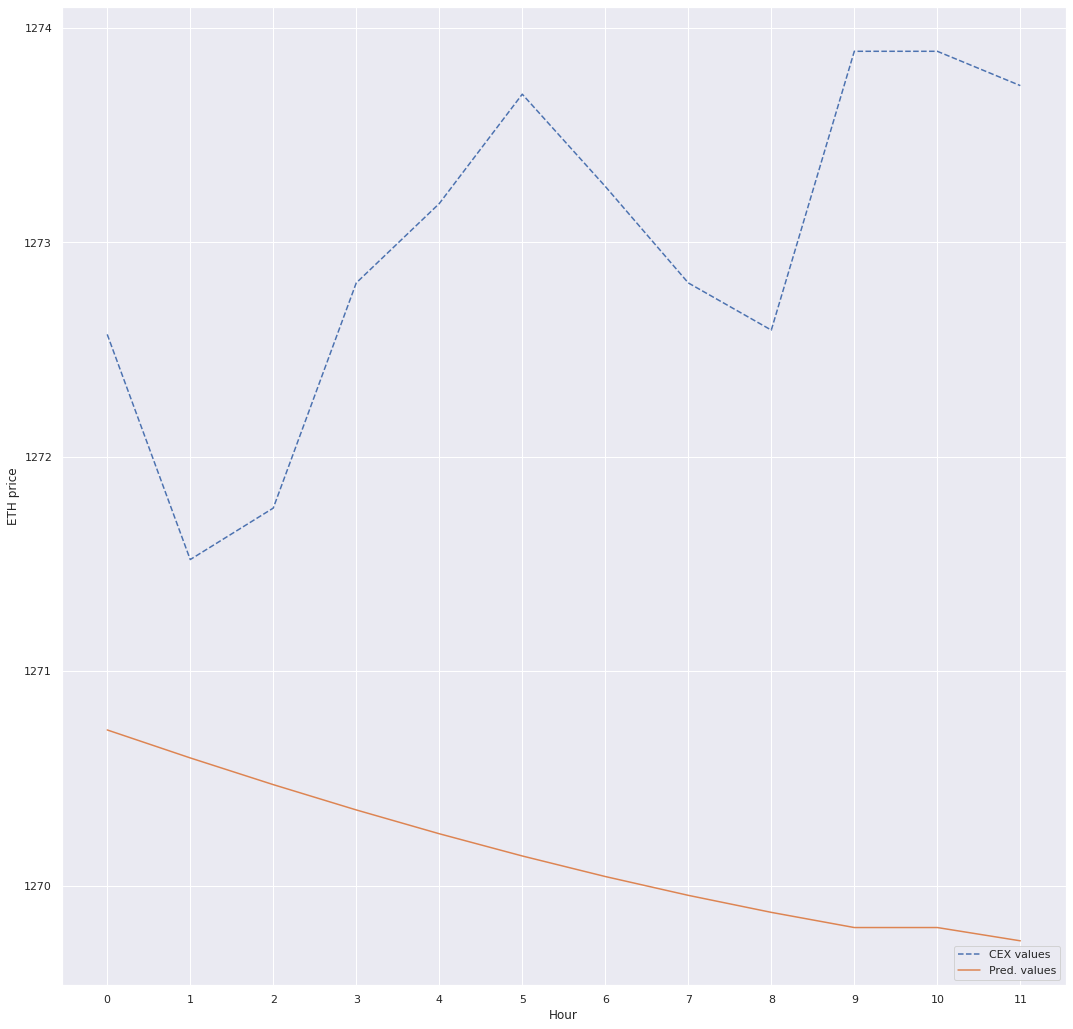

mean months nsme: 0.0008906621821174797


In [208]:
NSME_list = []

for i in range(len(months)-10, len(months)):
    w = months[i] 
    last_x_hours = 12
    # use the last 12 hours of testing set, all the previous data is used as training
    train_data = w.iloc[:-last_x_hours,:]
    test_data = w.iloc[-last_x_hours:,:]
    model = Prophet(daily_seasonality=True)  #weekly_seasonality=True,  # daily_seasonality=True
    model.fit(train_data)
    #Predict ETH values over the range of the test set
    forecast = model.predict(pd.DataFrame({"ds":test_data.ds}))
    pred_vals_test = forecast.set_index('ds')['yhat'][-last_x_hours:].to_numpy()
    # now, we have predicted and actual values. Let's find error, and plot!
    cex_vals = test_data.y
    nmse = calc_nmse(cex_vals, pred_vals_test)
    print(f"NMSE = {nmse}")
    NSME_list.append(nmse)
    plot_prices(cex_vals, pred_vals_test,last_x_hours)
    
print("=" * 10)
print(f"mean months nsme: {np.mean(NSME_list)}")

In [126]:
data.iloc[-1000:].reset_index()['y']

0      1231.57
1      1231.83
2      1232.67
3      1233.12
4      1234.88
        ...   
995    1272.86
996    1272.79
997    1271.62
998    1271.62
999    1272.30
Name: y, Length: 1000, dtype: float64

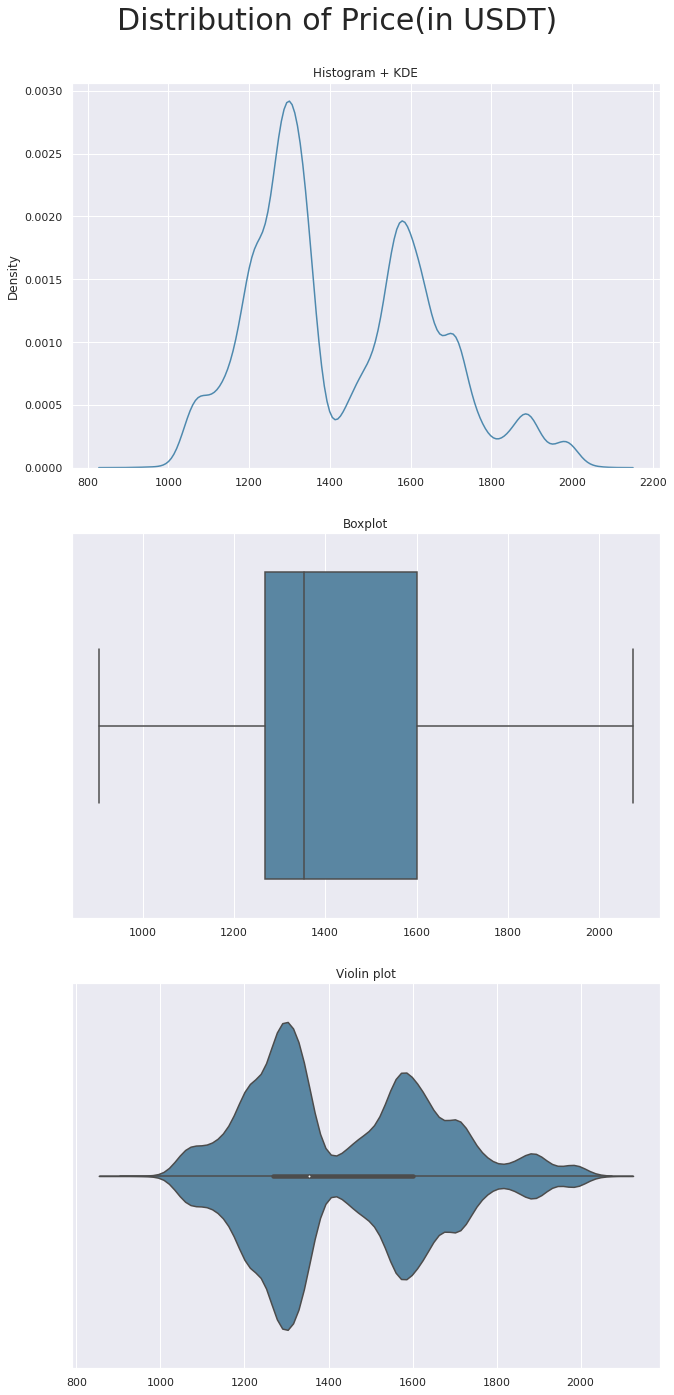

In [10]:
triple_plot(data.reset_index()['y'],'Distribution of Price(in USDT)',custom_colors[0])

In [345]:
# export retrieved data to prevent rate limiting issues
fp = "binance_data_21_8_22.csv"
data.to_csv(fp,index=False)
test_data = pd.read_csv(fp)
test_data.head()

ds        y
0  2022-08-21 00:00:00  1576.79
1  2022-08-21 01:00:00  1594.49
2  2022-08-21 02:00:00  1594.90
3  2022-08-21 03:00:00  1585.57
4  2022-08-21 04:00:00  1583.42

In [442]:

# Best one so far perhaps
num_weeks = 5
last_x_hours = 12
start_hour = 24 * 7 * num_weeks


# use the last 12 hours of testing set, all the previous data is used as training
train_data = data.iloc[-last_x_hours-start_hour:-last_x_hours,:]
test_data = data.iloc[-last_x_hours:,:]


In [443]:
model = Prophet()  #weekly_seasonality=True,  # daily_seasonality=True
model.fit(train_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/eopl_po8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/c5kpb_cz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49727', 'data', 'file=/tmp/tmpmu0vbl24/eopl_po8.json', 'init=/tmp/tmpmu0vbl24/c5kpb_cz.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model7l_b97wm/prophet_model-20221212065841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:58:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:58:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [444]:
#Observe ETH Predictions over train set
forecast = model.predict(pd.DataFrame({"ds":train_data.ds}))
pred_vals_train = forecast.set_index('ds')['yhat'].to_numpy()


pred_vals_train: 840 840
NMSE = 2.1465239009812097e-06


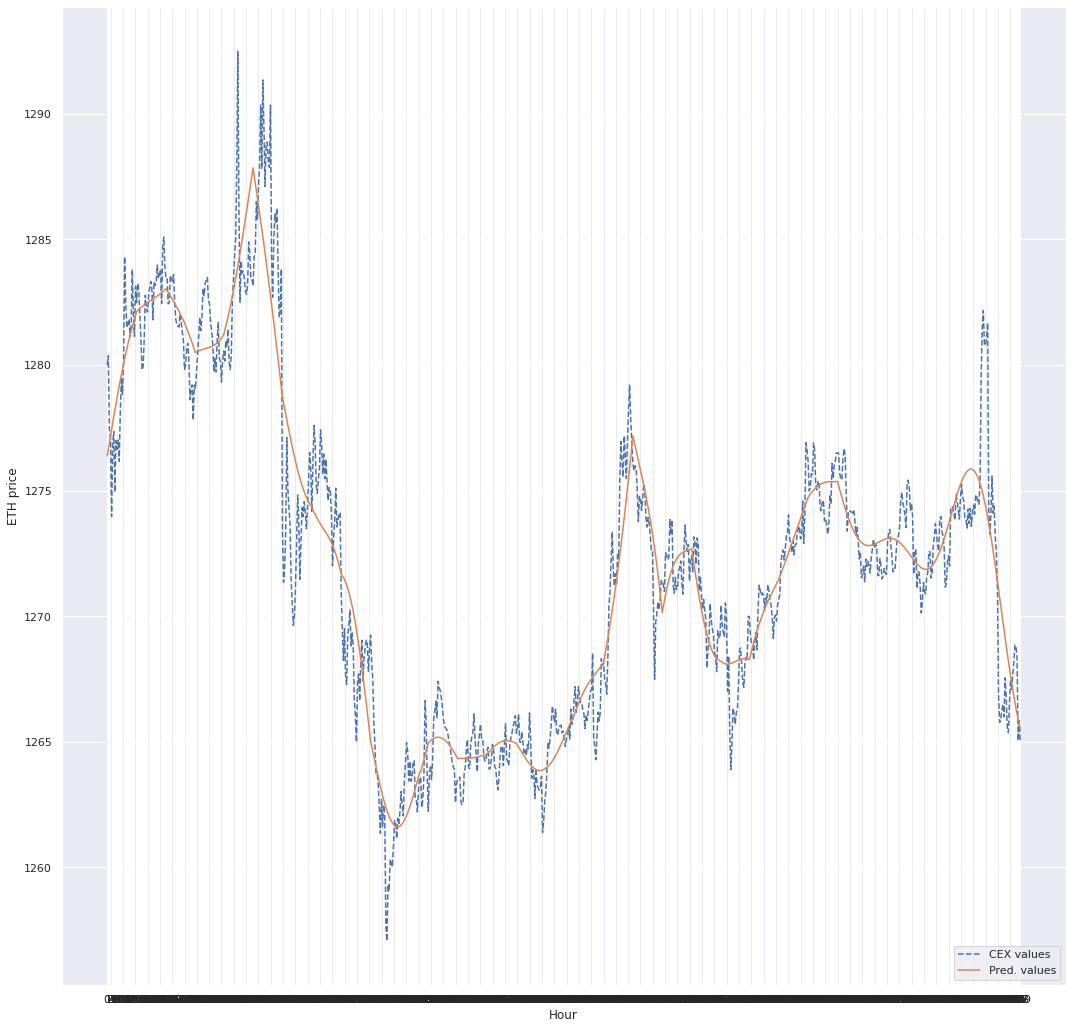

In [445]:
cex_vals = train_data.y
print(f"pred_vals_train: {len(pred_vals_train)} {len(cex_vals)}")
nmse = calc_nmse(cex_vals, pred_vals_train)
print(f"NMSE = {nmse}")
plot_prices(cex_vals, pred_vals_train,len(pred_vals_train))

In [446]:
#Predict ETH values over the range of the test set
forecast = model.predict(pd.DataFrame({"ds":test_data.ds}))
pred_vals_test = forecast.set_index('ds')['yhat'][-last_x_hours:].to_numpy()

NMSE = 1.9925833628492536e-06


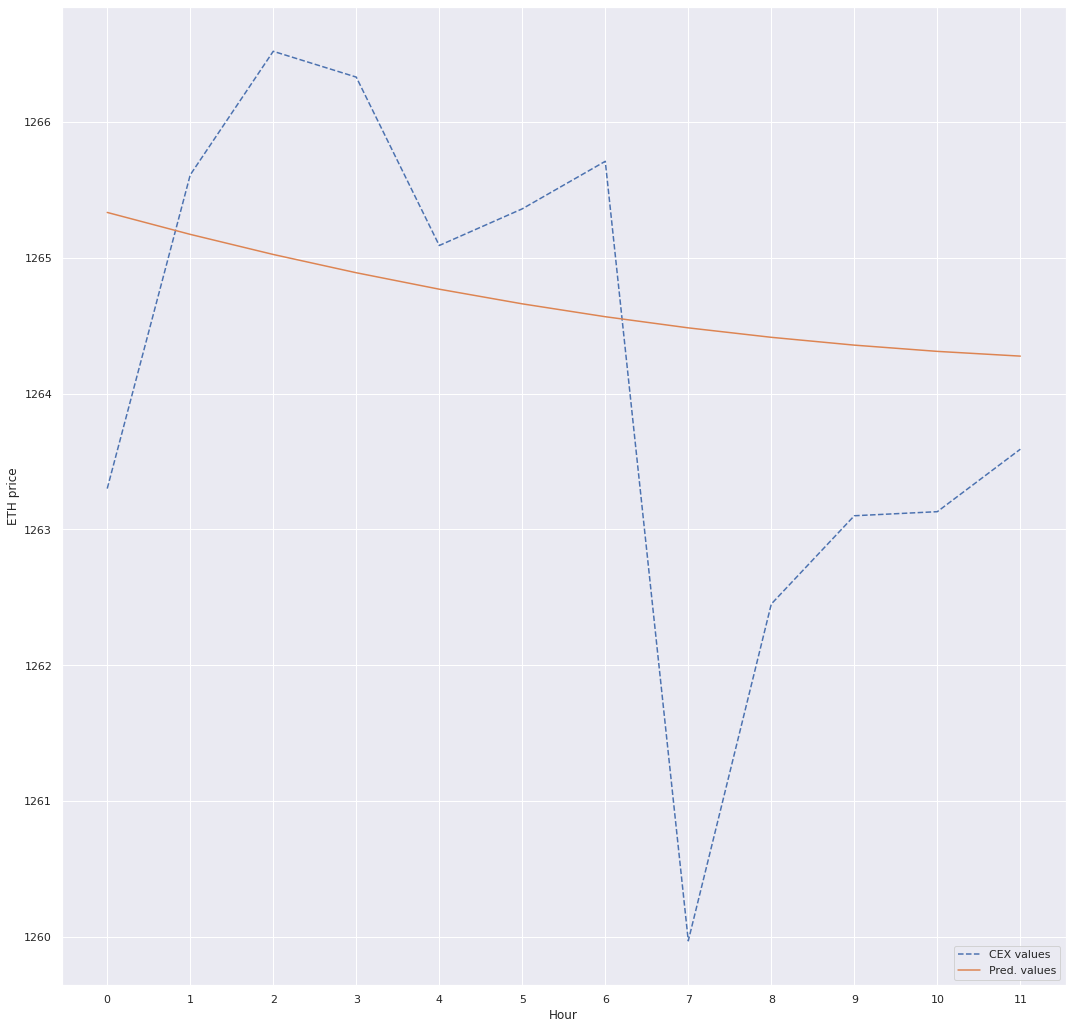

In [447]:
# now, we have predicted and actual values. Let's find error, and plot!
cex_vals = test_data.y
nmse = calc_nmse(cex_vals, pred_vals_test)
print(f"NMSE = {nmse}")
plot_prices(cex_vals, pred_vals_test,last_x_hours)

In [448]:
# fit model with all the available data
model = Prophet()
model.fit(data)

# generate dates for prediction (12 hours ahead of the latest datapoint in the data time)
future_dates = model.make_future_dataframe(periods=13, freq="h", include_history=False)

# predcit eth values on future_dates
forecast = model.predict(future_dates)
pred_vals = forecast.set_index('ds')['yhat'].to_numpy()


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/1jp720e3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/2e5jt9lh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13523', 'data', 'file=/tmp/tmpmu0vbl24/1jp720e3.json', 'init=/tmp/tmpmu0vbl24/2e5jt9lh.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelj4jmp684/prophet_model-20221212065854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:58:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:59:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [449]:
future_dates

ds
0  2022-12-11 23:55:00
1  2022-12-12 00:55:00
2  2022-12-12 01:55:00
3  2022-12-12 02:55:00
4  2022-12-12 03:55:00
5  2022-12-12 04:55:00
6  2022-12-12 05:55:00
7  2022-12-12 06:55:00
8  2022-12-12 07:55:00
9  2022-12-12 08:55:00
10 2022-12-12 09:55:00
11 2022-12-12 10:55:00
12 2022-12-12 11:55:00

<AxesSubplot: >

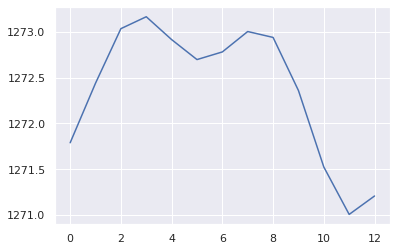

In [450]:
sns.lineplot(pred_vals)

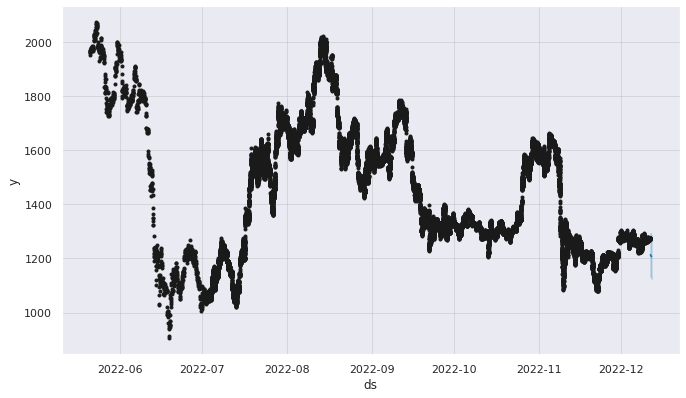

In [27]:
fig1 = model.plot(forecast)

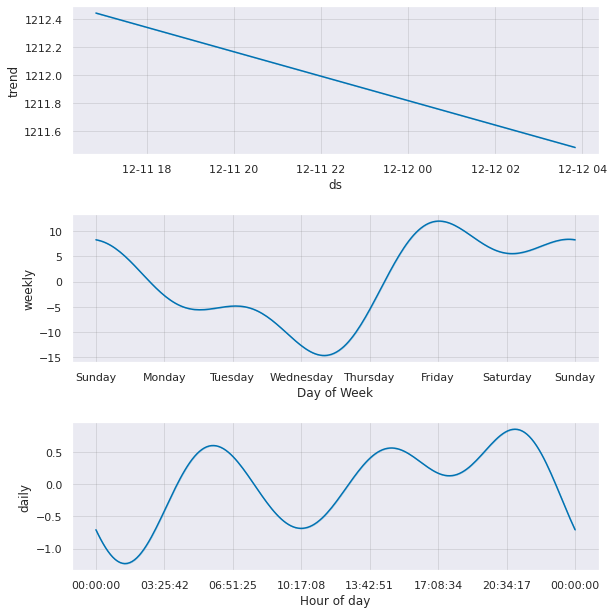

In [26]:
fig1 = model.plot_components(forecast)

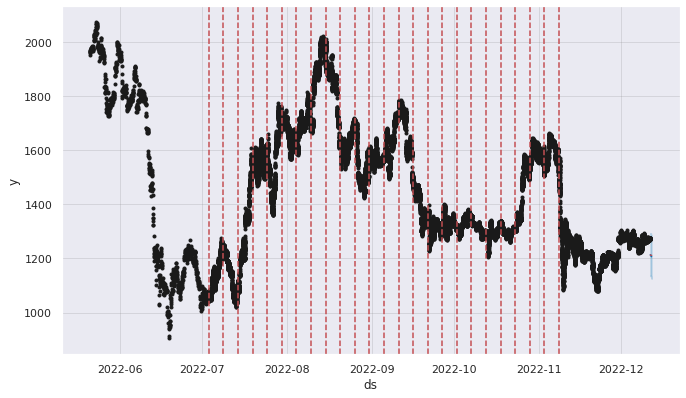

In [92]:


fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)



## Try mutiple regressors

In [454]:
num_lags = 2
multiplier = 24
multi_prop_data = pd.concat([data['y'].shift(i).rename(f"{i * multiplier}_shift") for i in range(0,num_lags)],axis=1).dropna()#.values

In [455]:
multi_prop_data.rename(columns={"0_shift":"y"},inplace=True)

In [456]:
multi_prop_data["ds"] = data["ds"]

In [457]:
num_weeks = 1# 5 results in overfit
last_x_hours = 12
start_hour = math.ceil(24 * 7 * num_weeks)


# use the last 12 hours of testing set, all the previous data is used as training
multi_train_data = multi_prop_data.iloc[-last_x_hours-start_hour:-last_x_hours,:]
multi_test_data = multi_prop_data.iloc[-last_x_hours:,:]


In [458]:
# Instantitae new prophet model
pro_regressor= Prophet(weekly_seasonality=True)
for i in range(1,num_lags):
    pro_regressor.add_regressor(f"{i * multiplier}_shift")

In [459]:
pro_regressor.fit(multi_train_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/vdvrdrt3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/5e_ln4np.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54683', 'data', 'file=/tmp/tmpmu0vbl24/vdvrdrt3.json', 'init=/tmp/tmpmu0vbl24/5e_ln4np.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelzioqas24/prophet_model-20221212070506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:05:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:05:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [460]:
#Observe ETH Predictions over train set
forecast = pro_regressor.predict(multi_train_data)
pred_vals_train = forecast.set_index('ds')['yhat'].to_numpy()


pred_vals_train: 168 168
NMSE = 4.74647313072324e-07


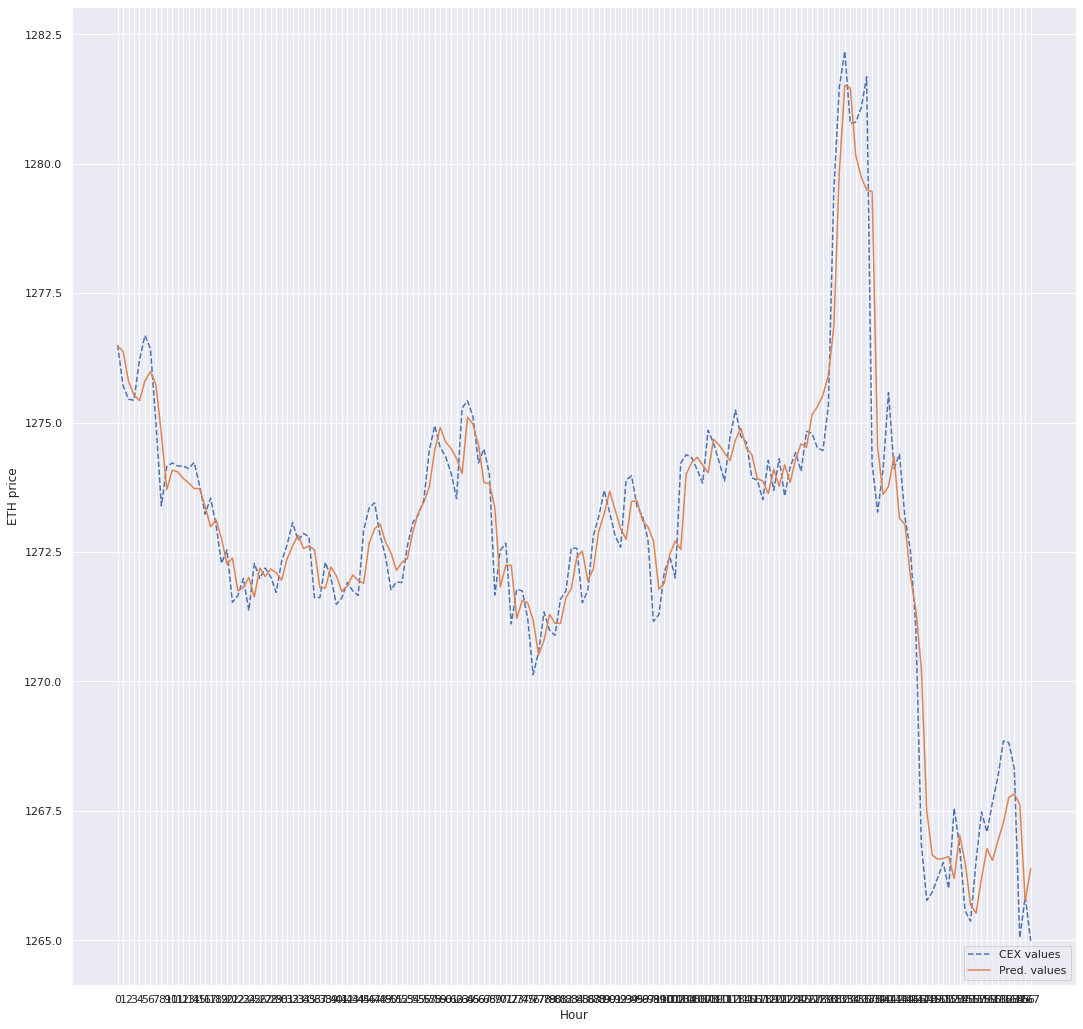

In [461]:
cex_vals = multi_train_data.y
print(f"pred_vals_train: {len(pred_vals_train)} {len(cex_vals)}")
nmse = calc_nmse(cex_vals, pred_vals_train)
print(f"NMSE = {nmse}")
plot_prices(cex_vals, pred_vals_train,len(pred_vals_train))

In [462]:
#Predict ETH values over the range of the test set
forecast = pro_regressor.predict(multi_test_data)
pred_vals_test = forecast.set_index('ds')['yhat'][-last_x_hours:].to_numpy()

NMSE = 7.551564940949744e-06


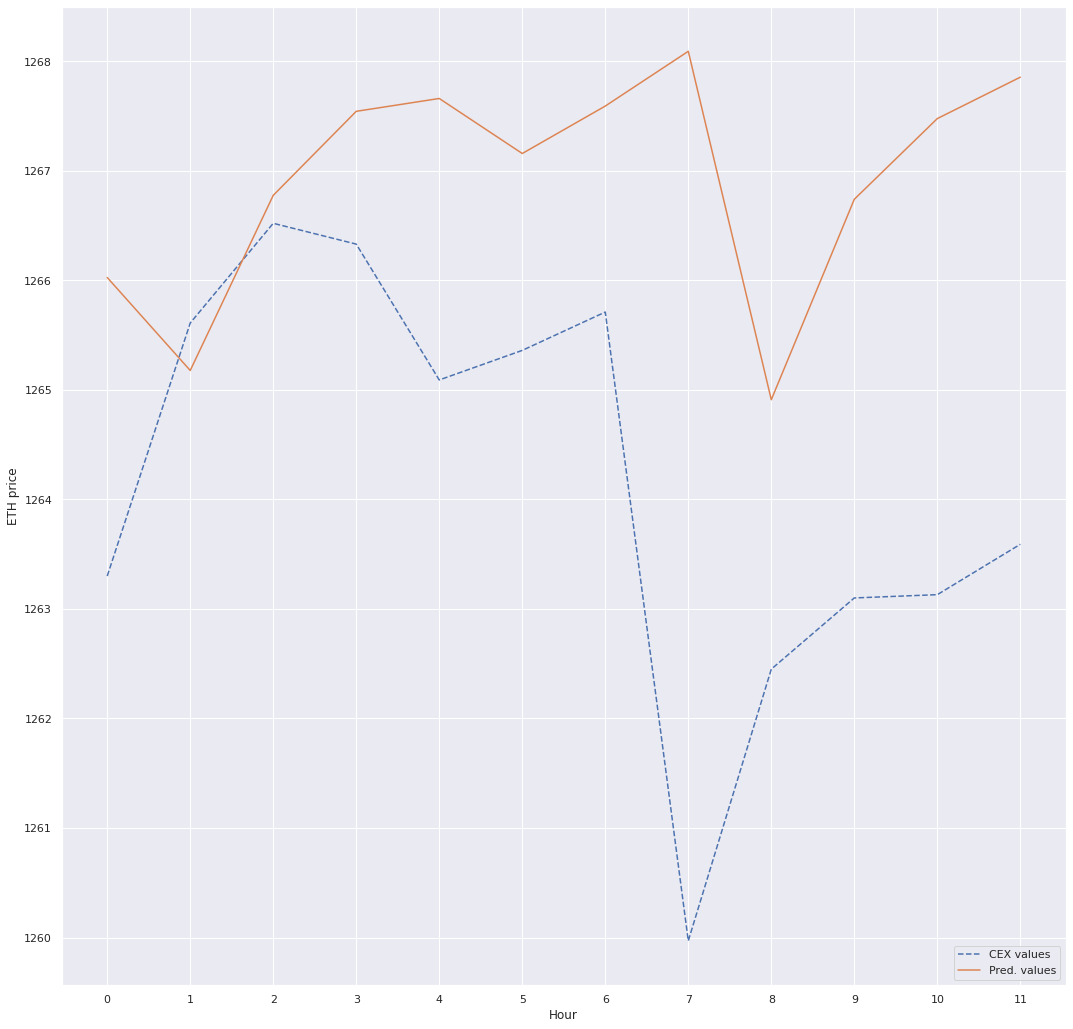

In [463]:
# now, we have predicted and actual values. Let's find error, and plot!
cex_vals = multi_test_data.y
nmse = calc_nmse(cex_vals, pred_vals_test)
print(f"NMSE = {nmse}")
plot_prices(cex_vals, pred_vals_test,last_x_hours)

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


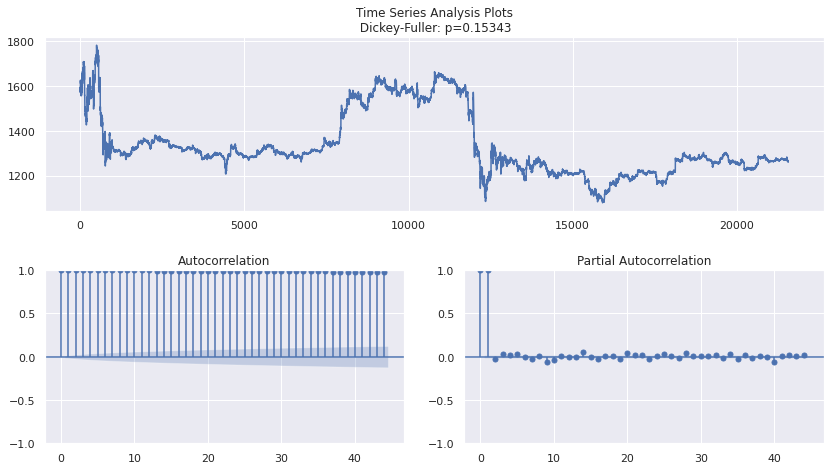

In [464]:
tsplot(data['y'])
# shows that whatever data i trained it on, it was highly auto correlated. So including the lags may have caused significant issues

In [465]:
multi_prop_weeks = [g for n, g in multi_prop_data.groupby(pd.Grouper(key='ds',freq='W'))]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/abtne03t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/i9a34c9h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76359', 'data', 'file=/tmp/tmpmu0vbl24/abtne03t.json', 'init=/tmp/tmpmu0vbl24/i9a34c9h.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelkdrm_v92/prophet_model-20221212070519.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:05:19 - cmdstanpy - IN

2
NMSE = 8.537747187437561e-05


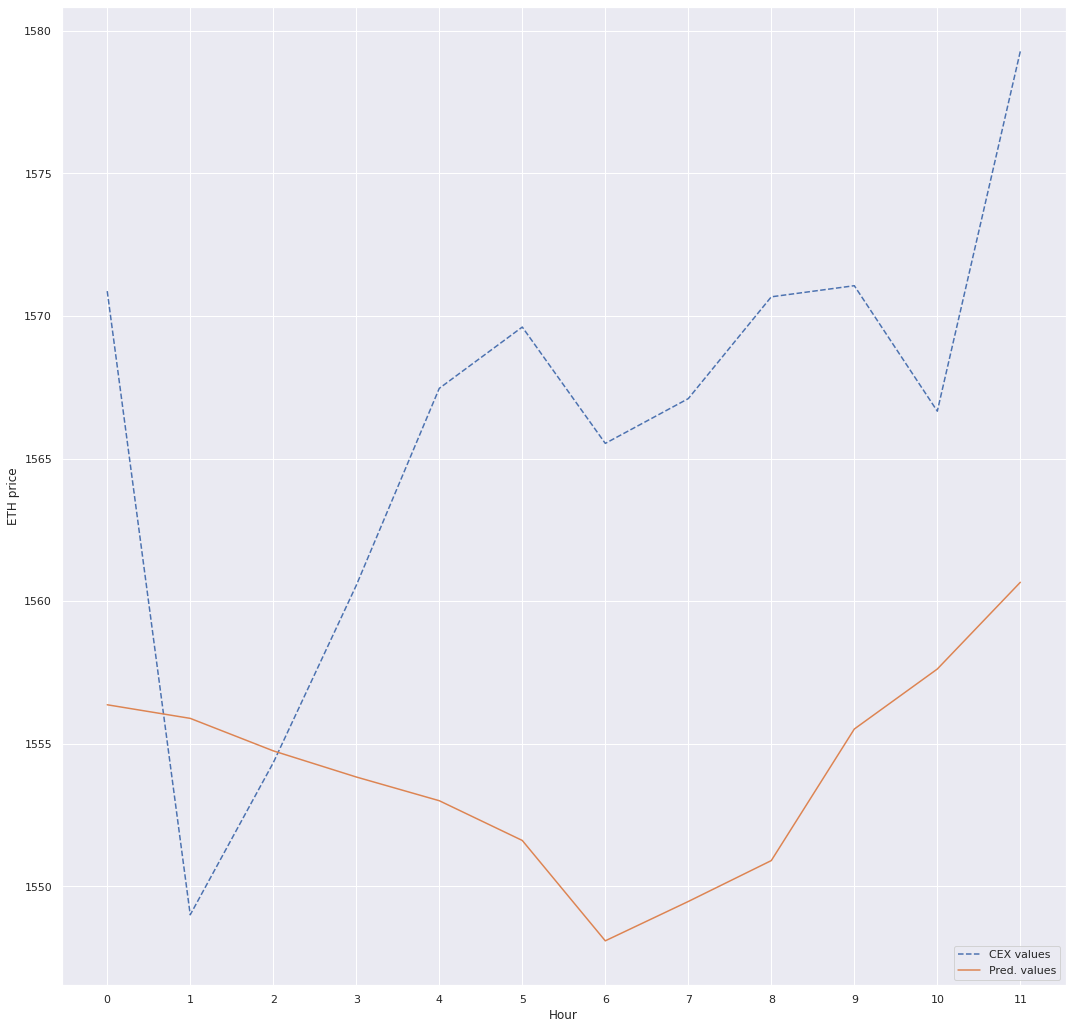

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/66orz8es.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/1n1ia65s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71228', 'data', 'file=/tmp/tmpmu0vbl24/66orz8es.json', 'init=/tmp/tmpmu0vbl24/1n1ia65s.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model2nvqv07r/prophet_model-20221212070519.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:05:19 - cmdstanpy - IN

3
NMSE = 4.425790766897186e-05


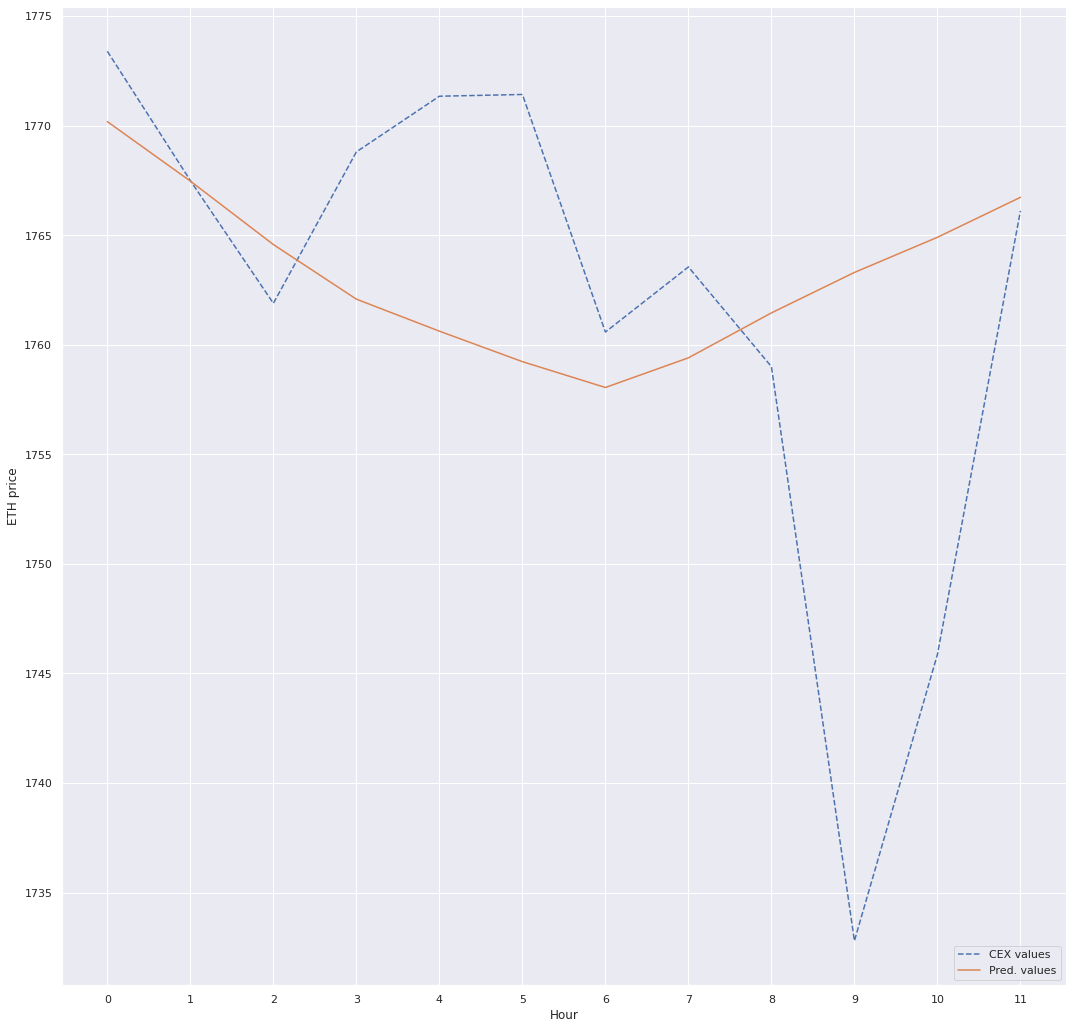

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/by2dpaj9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/ipqbsxge.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39138', 'data', 'file=/tmp/tmpmu0vbl24/by2dpaj9.json', 'init=/tmp/tmpmu0vbl24/ipqbsxge.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelzc2py6ei/prophet_model-20221212070519.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:05:19 - cmdstanpy - IN

4
NMSE = 0.002509953377581161


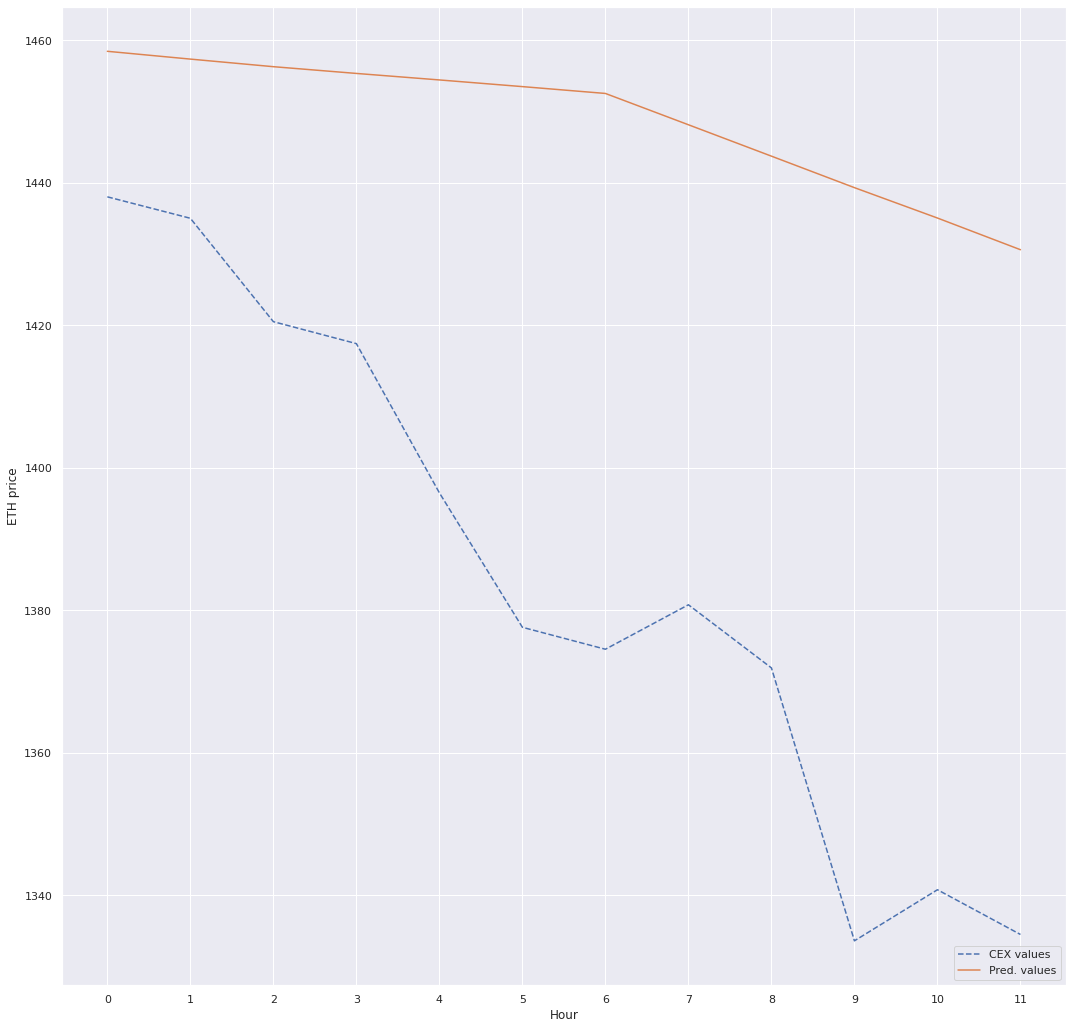

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/9i1qhg4h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/ri92z6_y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38656', 'data', 'file=/tmp/tmpmu0vbl24/9i1qhg4h.json', 'init=/tmp/tmpmu0vbl24/ri92z6_y.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelphh4ytyt/prophet_model-20221212070519.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:05:19 - cmdstanpy - IN

5
NMSE = 0.0004624323462041833


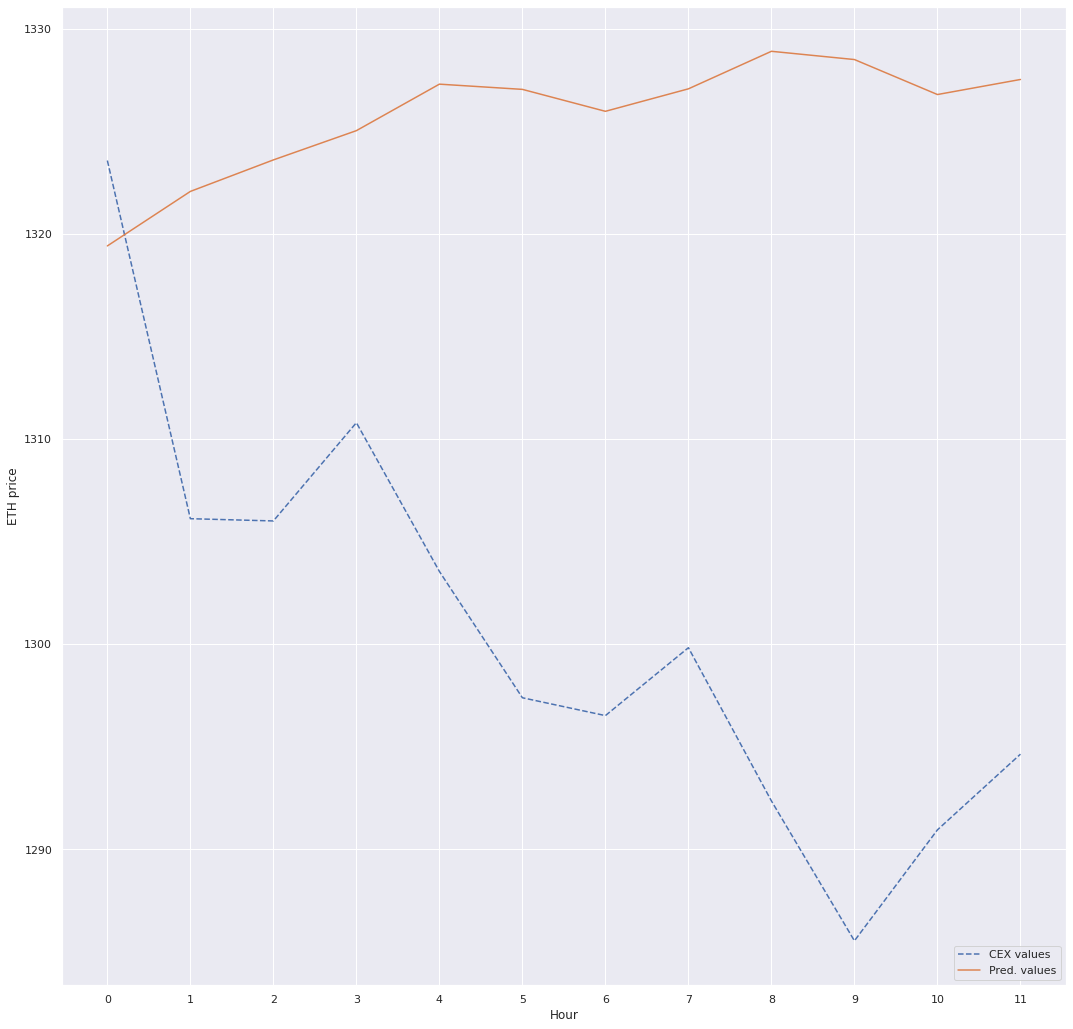

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/t1jpzvlr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/_zrwh72_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41834', 'data', 'file=/tmp/tmpmu0vbl24/t1jpzvlr.json', 'init=/tmp/tmpmu0vbl24/_zrwh72_.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelwuiivv4j/prophet_model-20221212070520.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:05:20 - cmdstanpy - IN

6
NMSE = 0.00024024962232043265


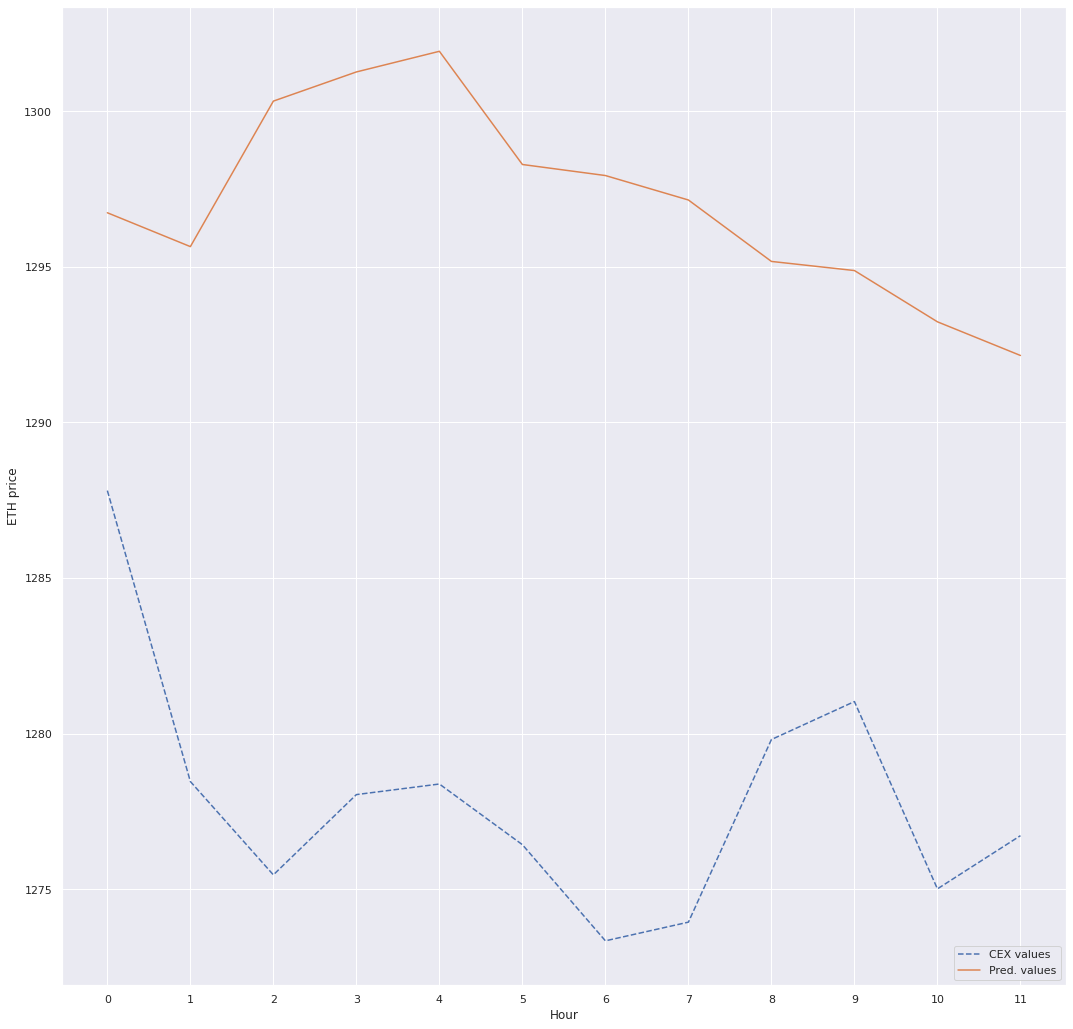

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/psryrrpj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/s9l9vajs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23970', 'data', 'file=/tmp/tmpmu0vbl24/psryrrpj.json', 'init=/tmp/tmpmu0vbl24/s9l9vajs.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelcypk4rdd/prophet_model-20221212070520.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:05:20 - cmdstanpy - IN

7
NMSE = 5.7347948172885975e-06


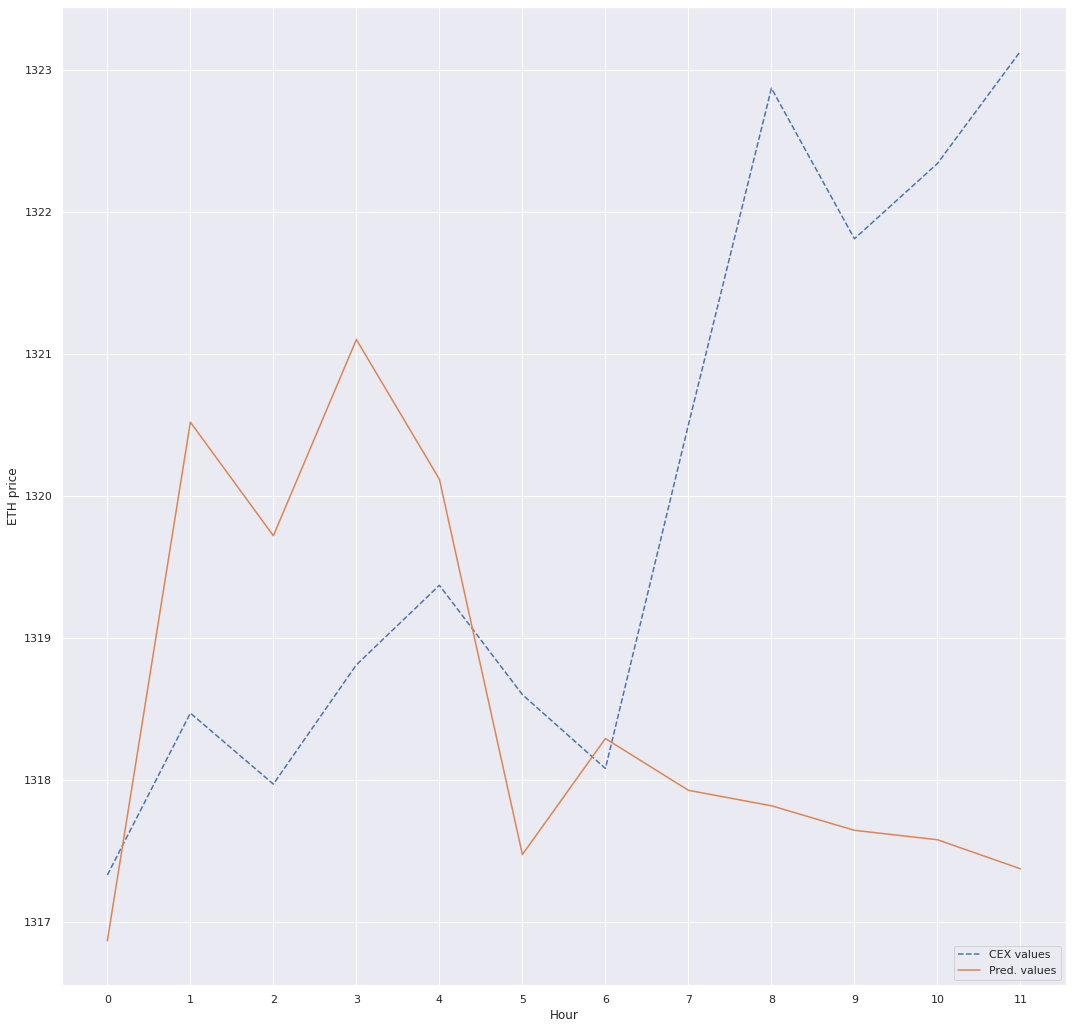

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/kjpm2_67.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/cp028cg3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=551', 'data', 'file=/tmp/tmpmu0vbl24/kjpm2_67.json', 'init=/tmp/tmpmu0vbl24/cp028cg3.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelb9y91xfe/prophet_model-20221212070520.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:05:20 - cmdstanpy - INFO

8
NMSE = 7.5883333472330185e-06


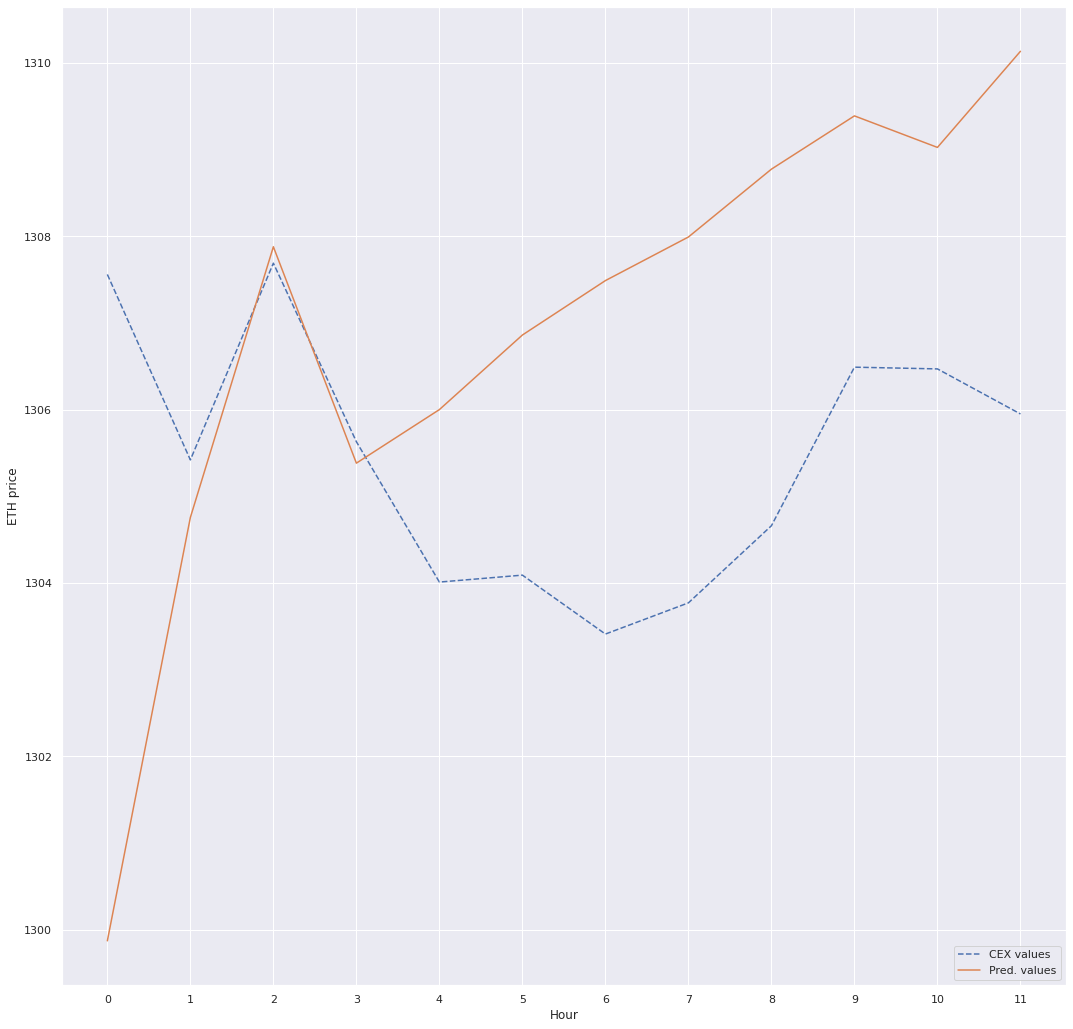

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/x_5hvknj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/j9xo3tjo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38209', 'data', 'file=/tmp/tmpmu0vbl24/x_5hvknj.json', 'init=/tmp/tmpmu0vbl24/j9xo3tjo.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelueh55ish/prophet_model-20221212070520.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:05:20 - cmdstanpy - IN

9
NMSE = 5.191833429837395e-05


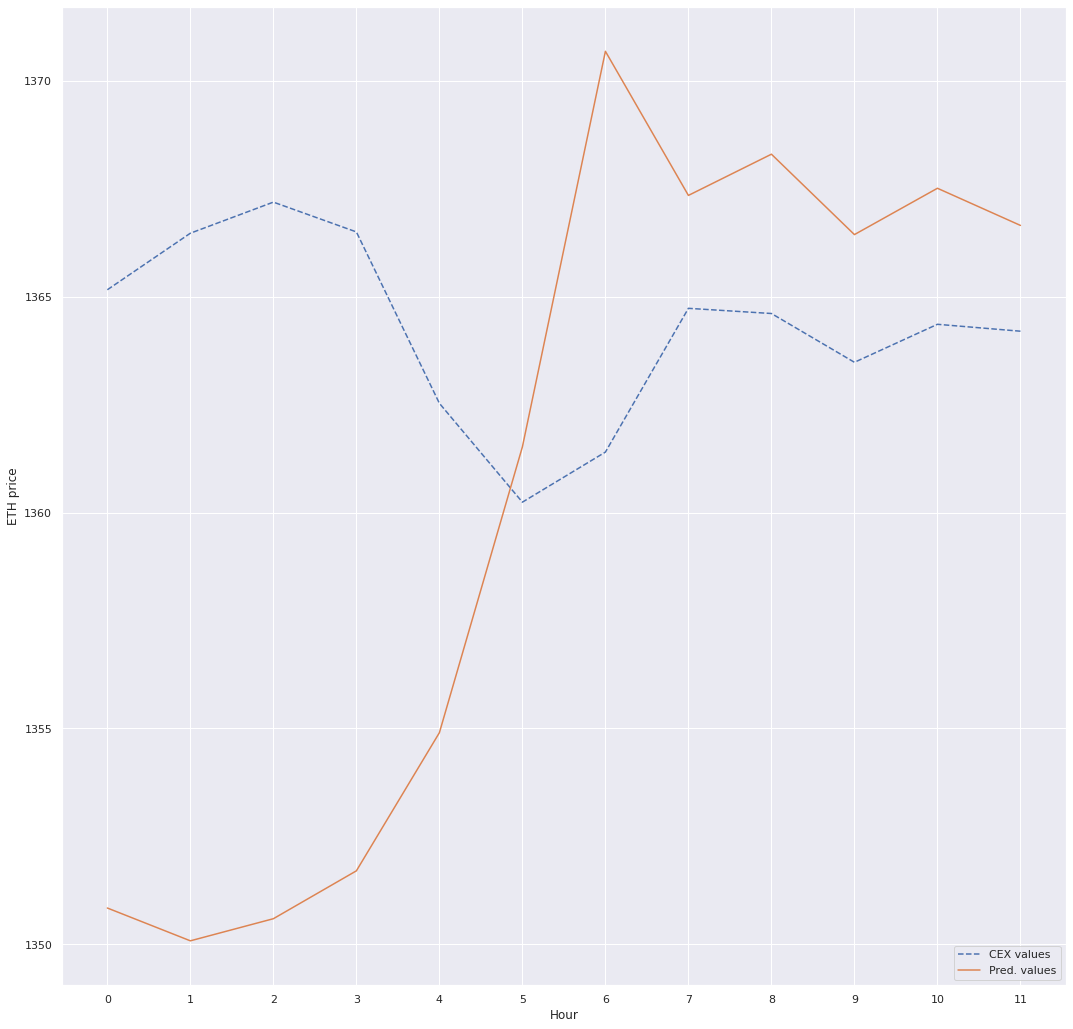

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/7wl3si94.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/y9zjjvdz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76193', 'data', 'file=/tmp/tmpmu0vbl24/7wl3si94.json', 'init=/tmp/tmpmu0vbl24/y9zjjvdz.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelu65g1xsp/prophet_model-20221212070520.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:05:20 - cmdstanpy - IN

10
NMSE = 1.7027035747319386e-05


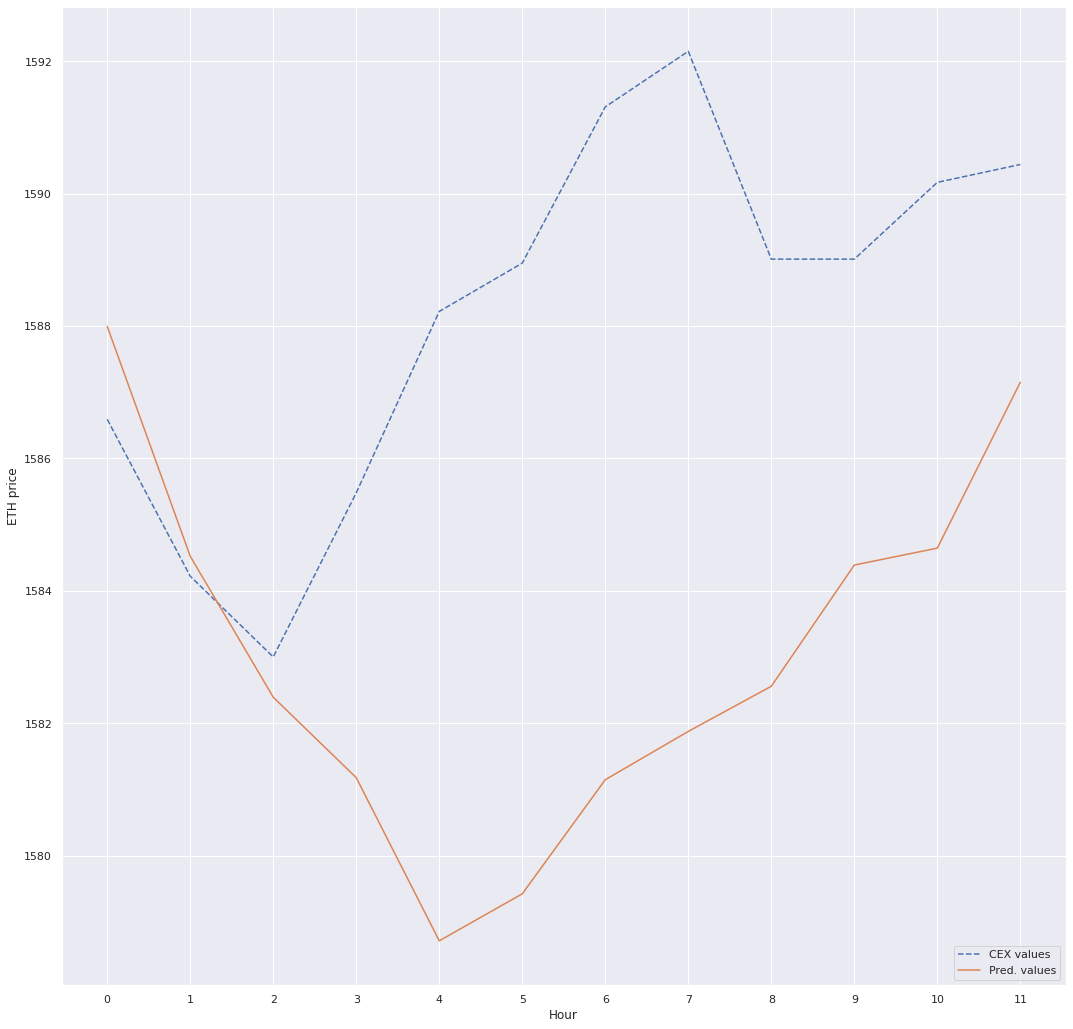

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/ky_nvabf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/v6ewvgb5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76406', 'data', 'file=/tmp/tmpmu0vbl24/ky_nvabf.json', 'init=/tmp/tmpmu0vbl24/v6ewvgb5.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelfptj2yc4/prophet_model-20221212070521.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:05:21 - cmdstanpy - IN

11
NMSE = 0.00023434509153775544


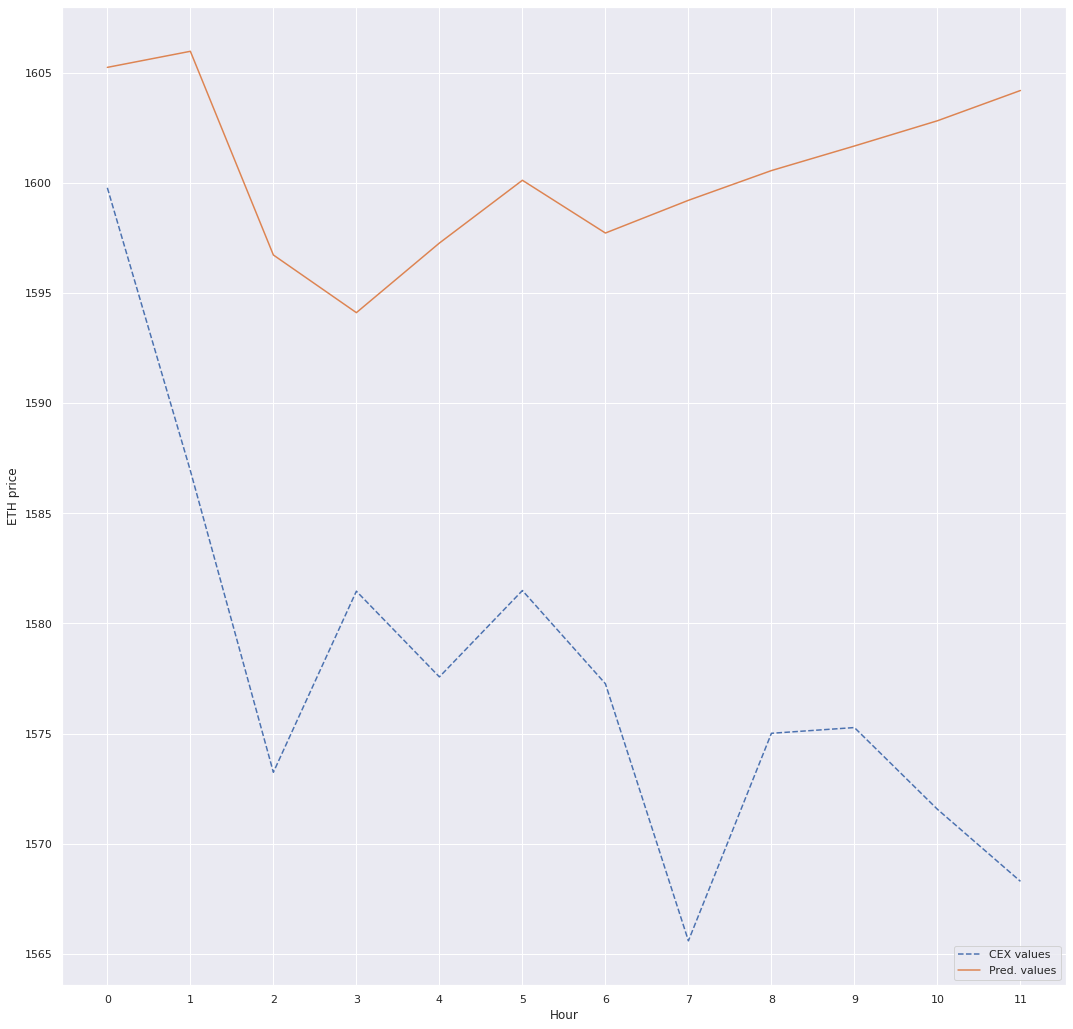

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/gc2c4f_y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/jq9mq5e3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61081', 'data', 'file=/tmp/tmpmu0vbl24/gc2c4f_y.json', 'init=/tmp/tmpmu0vbl24/jq9mq5e3.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelxeiv4vim/prophet_model-20221212070521.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:05:21 - cmdstanpy - IN

12
NMSE = 1.785076091023081e-05


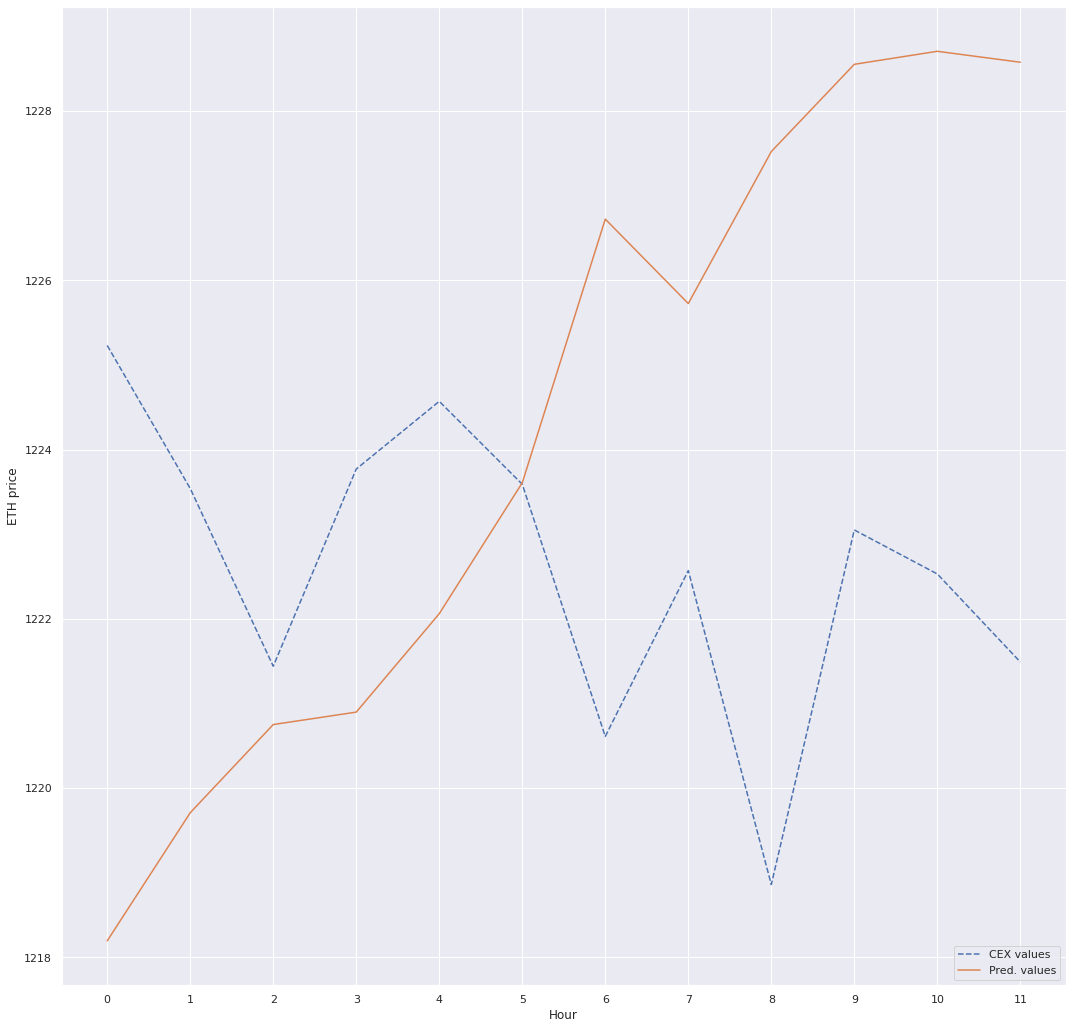

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/_tb7zbsb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/bmh_ykr1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19325', 'data', 'file=/tmp/tmpmu0vbl24/_tb7zbsb.json', 'init=/tmp/tmpmu0vbl24/bmh_ykr1.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modeliqjlwp6p/prophet_model-20221212070521.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:05:21 - cmdstanpy - IN

13
NMSE = 3.5925528549053265e-05


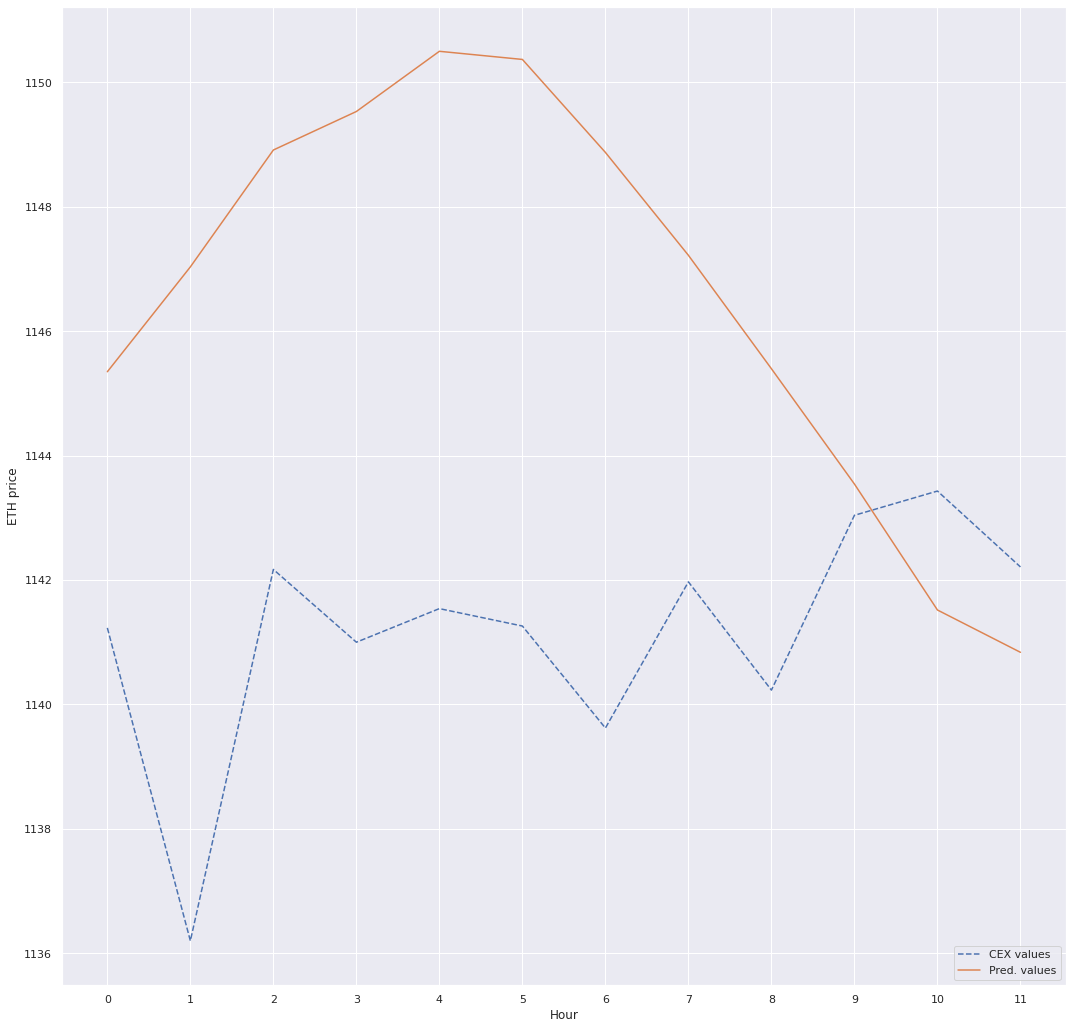

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/wxiktr4a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/j2vam__d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15557', 'data', 'file=/tmp/tmpmu0vbl24/wxiktr4a.json', 'init=/tmp/tmpmu0vbl24/j2vam__d.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model_9j9v8li/prophet_model-20221212070522.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:05:22 - cmdstanpy - IN

14
NMSE = 0.00019685345973487813


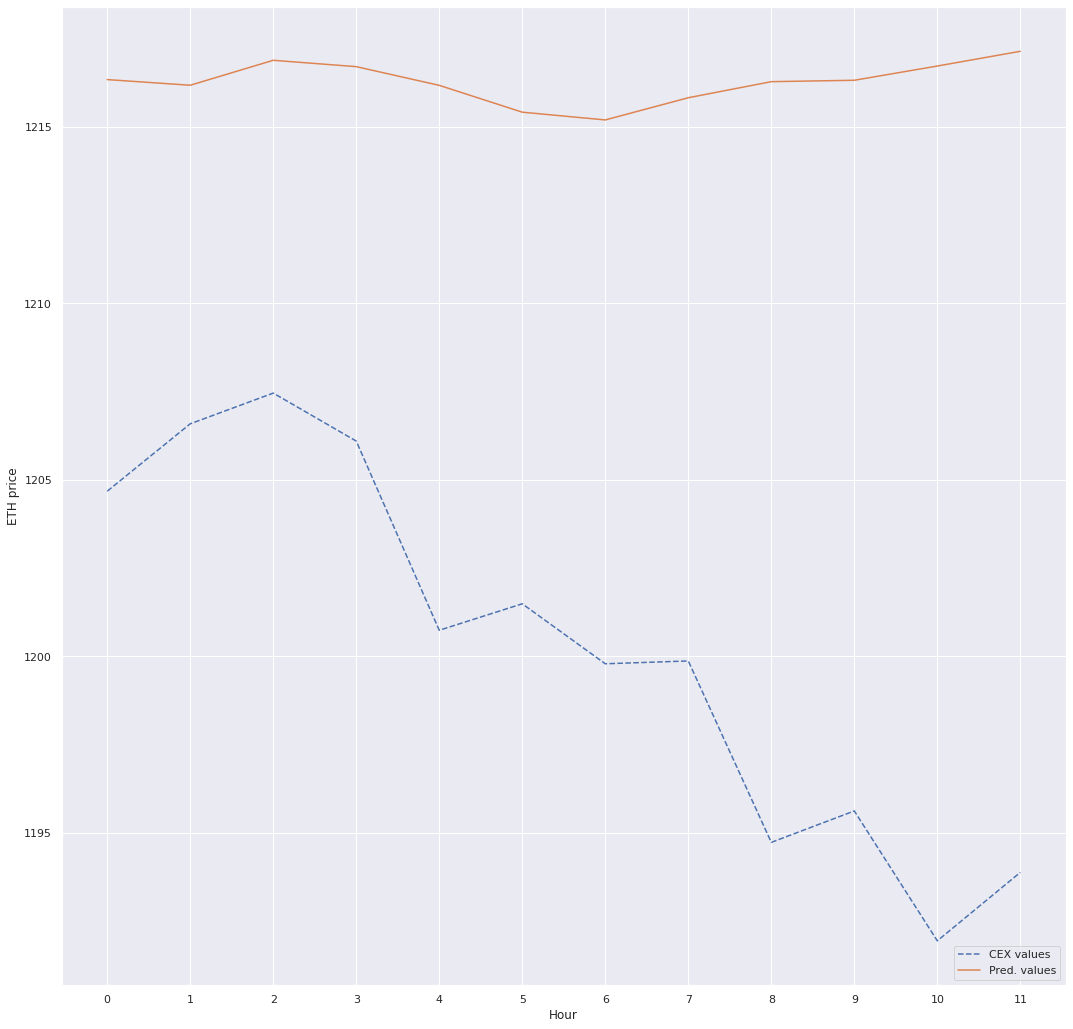

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/rwxkoesp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/2yn35vfp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40459', 'data', 'file=/tmp/tmpmu0vbl24/rwxkoesp.json', 'init=/tmp/tmpmu0vbl24/2yn35vfp.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model4p_h_s94/prophet_model-20221212070522.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:05:22 - cmdstanpy - IN

15
NMSE = 1.11030217937814e-05


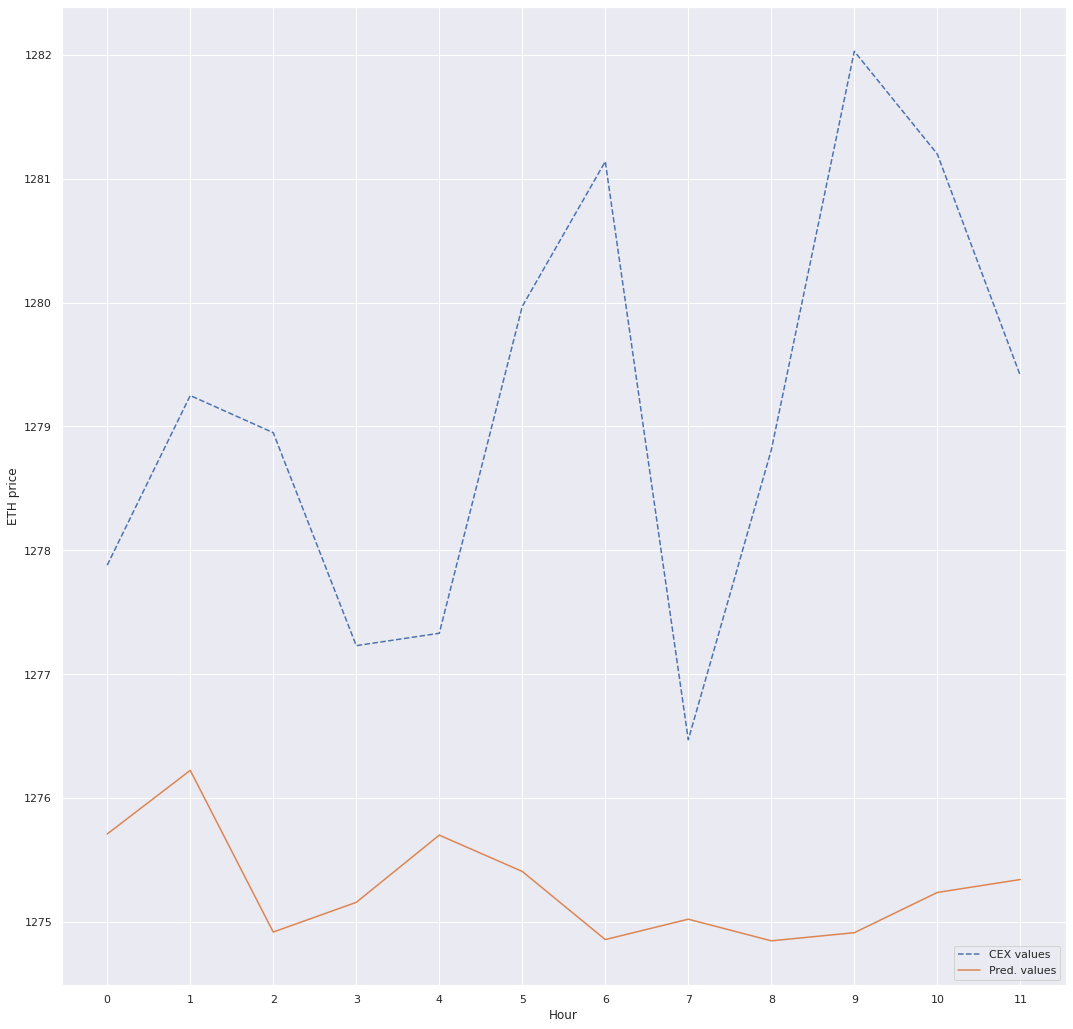

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/qgaacmqg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/5qr5tyww.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80044', 'data', 'file=/tmp/tmpmu0vbl24/qgaacmqg.json', 'init=/tmp/tmpmu0vbl24/5qr5tyww.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modeldp31fb57/prophet_model-20221212070522.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:05:22 - cmdstanpy - IN

16
NMSE = 7.611564053770339e-06


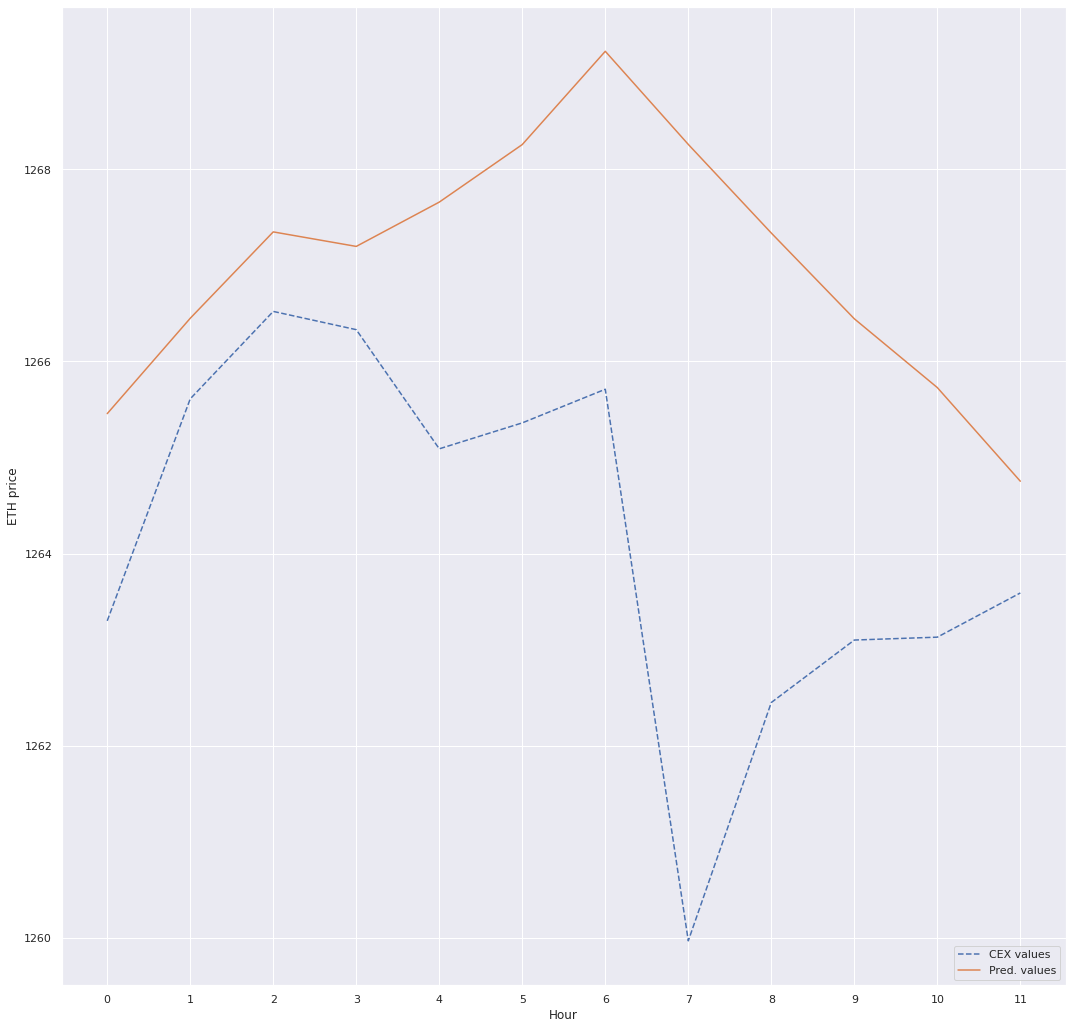

mean months nsme: 0.0002618819100292539


In [466]:
num_weeks = 1# 5 results in overfit
last_x_hours = 12
start_hour = math.ceil(24 * 7 * num_weeks) # this value doesn't matter too much

NSME_list = []

for i in range(len(multi_prop_weeks)-15, len(multi_prop_weeks)):
    print(i)
    w = multi_prop_weeks[i] 
#     print(w)
    last_x_hours = 12
    
    
    train_data = w.iloc[-last_x_hours-24:-last_x_hours,:]
    test_data = w.iloc[-last_x_hours:,:]
    model= Prophet() #weekly_seasonality
    for i in range(1,num_lags):
        model.add_regressor(f"{i * multiplier}_shift")
    model.fit(train_data)
    #Predict ETH values over the range of the test set
    forecast = model.predict(train_data)
    pred_vals_test = forecast.set_index('ds')['yhat'][-last_x_hours:].to_numpy()
    # now, we have predicted and actual values. Let's find error, and plot!
    cex_vals = test_data.y
    nmse = calc_nmse(cex_vals, pred_vals_test)
    print(f"NMSE = {nmse}")
    NSME_list.append(nmse)
    plot_prices(cex_vals, pred_vals_test,last_x_hours)
    
print("=" * 10)
print(f"mean months nsme: {np.mean(NSME_list)}")

In [408]:
multi_prop_data.tail(10)

y  12_shift  24_shift  36_shift  48_shift                  ds
21547  1268.82   1268.85   1268.15   1267.66   1267.09 2022-12-11 21:35:00
21548  1268.32   1268.82   1268.85   1268.15   1267.66 2022-12-11 21:40:00
21549  1265.05   1268.32   1268.82   1268.85   1268.15 2022-12-11 21:45:00
21550  1265.84   1265.05   1268.32   1268.82   1268.85 2022-12-11 21:50:00
21551  1264.99   1265.84   1265.05   1268.32   1268.82 2022-12-11 21:55:00
21552  1263.30   1264.99   1265.84   1265.05   1268.32 2022-12-11 22:00:00
21553  1265.61   1263.30   1264.99   1265.84   1265.05 2022-12-11 22:05:00
21554  1266.52   1265.61   1263.30   1264.99   1265.84 2022-12-11 22:10:00
21555  1266.33   1266.52   1265.61   1263.30   1264.99 2022-12-11 22:15:00
21556  1265.64   1266.33   1266.52   1265.61   1263.30 2022-12-11 22:20:00

In [467]:
def construct_future_lags(x):
    print(x)
    for i in range(1,num_lags):
        x[f"{i * multiplier}_shift"] = multi_prop_data.iloc[-(i * multiplier) + x.name]['y']
    return x

In [468]:
# fit model with all the available data
# Instantitae new prophet model
# model= Prophet(weekly_seasonality=True)
# for i in range(1,num_lags):
#     model.add_regressor(f"{i * multiplier}_shift")
# model.fit(multi_prop_data)

# generate dates for prediction (12 hours ahead of the latest datapoint in the data time)
future_dates = model.make_future_dataframe(periods=14, freq="h", include_history=False)

final = future_dates.apply(construct_future_lags,axis=1)

# predcit eth values on future_dates
forecast = model.predict(final)
pred_vals = forecast.set_index('ds')['yhat'].to_numpy()


ds   2022-12-11 22:55:00
Name: 0, dtype: datetime64[ns]
ds   2022-12-11 23:55:00
Name: 1, dtype: datetime64[ns]
ds   2022-12-12 00:55:00
Name: 2, dtype: datetime64[ns]
ds   2022-12-12 01:55:00
Name: 3, dtype: datetime64[ns]
ds   2022-12-12 02:55:00
Name: 4, dtype: datetime64[ns]
ds   2022-12-12 03:55:00
Name: 5, dtype: datetime64[ns]
ds   2022-12-12 04:55:00
Name: 6, dtype: datetime64[ns]
ds   2022-12-12 05:55:00
Name: 7, dtype: datetime64[ns]
ds   2022-12-12 06:55:00
Name: 8, dtype: datetime64[ns]
ds   2022-12-12 07:55:00
Name: 9, dtype: datetime64[ns]
ds   2022-12-12 08:55:00
Name: 10, dtype: datetime64[ns]
ds   2022-12-12 09:55:00
Name: 11, dtype: datetime64[ns]
ds   2022-12-12 10:55:00
Name: 12, dtype: datetime64[ns]
ds   2022-12-12 11:55:00
Name: 13, dtype: datetime64[ns]


<AxesSubplot: >

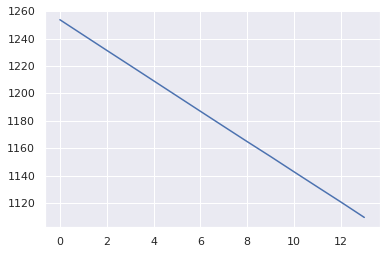

In [469]:
sns.lineplot(pred_vals)

# Try prophet with ochlv (Doesn't work as they aren't lagged features)


In [346]:
for idx,x in enumerate(cex_x):
    cur = cex_x[idx][0]
#     print(cex_x[idx][0])
#     print(type(cur))
    if(isinstance(cur, datetime.datetime)):
        continue
    cex_x[idx][0] = to_datetime(cex_x[idx][0]/1000)

ochlv_data = pd.DataFrame(data = cex_x, columns=["ds","open","y","high","low","volume"])
# ochlv_data.astype({'ds': 'datetime64[ns]'})
ochlv_data.head()

ds     open        y     high      low      volume
0 2022-08-21 00:00:00  1576.03  1596.29  1573.19  1576.79  36500.4563
1 2022-08-21 01:00:00  1576.80  1597.99  1576.01  1594.49  39962.5469
2 2022-08-21 02:00:00  1594.49  1604.23  1586.82  1594.90  28406.1445
3 2022-08-21 03:00:00  1594.91  1595.88  1581.13  1585.57  19836.1659
4 2022-08-21 04:00:00  1585.56  1595.41  1581.67  1583.42  17475.2018

In [252]:
num_weeks = 2# 5 results in overfit
last_x_hours = 12
start_hour = math.ceil(24 * 7 * num_weeks)


# use the last 12 hours of testing set, all the previous data is used as training
ochlv_train_data = ochlv_data.iloc[-last_x_hours-start_hour:-last_x_hours,:]
ochlv_test_data = ochlv_data.iloc[-last_x_hours:,:]

In [340]:


pro_regressor_5= Prophet()
pro_regressor_5.add_regressor('open')
pro_regressor_5.add_regressor('high')
pro_regressor_5.add_regressor('low')
pro_regressor_5.add_regressor('volume')



In [341]:
pro_regressor_5.fit(ochlv_train_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/ong5dzd_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/8l34jo24.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97461', 'data', 'file=/tmp/tmpmu0vbl24/ong5dzd_.json', 'init=/tmp/tmpmu0vbl24/8l34jo24.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model8xdytd97/prophet_model-20221212061957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:19:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06

In [257]:
#Predict ETH values over the range of the test set
forecast = pro_regressor_5.predict(ochlv_test_data)
pred_vals_test = forecast.set_index('ds')['yhat'][-last_x_hours:].to_numpy()

NMSE = 3.962773082471459e-08


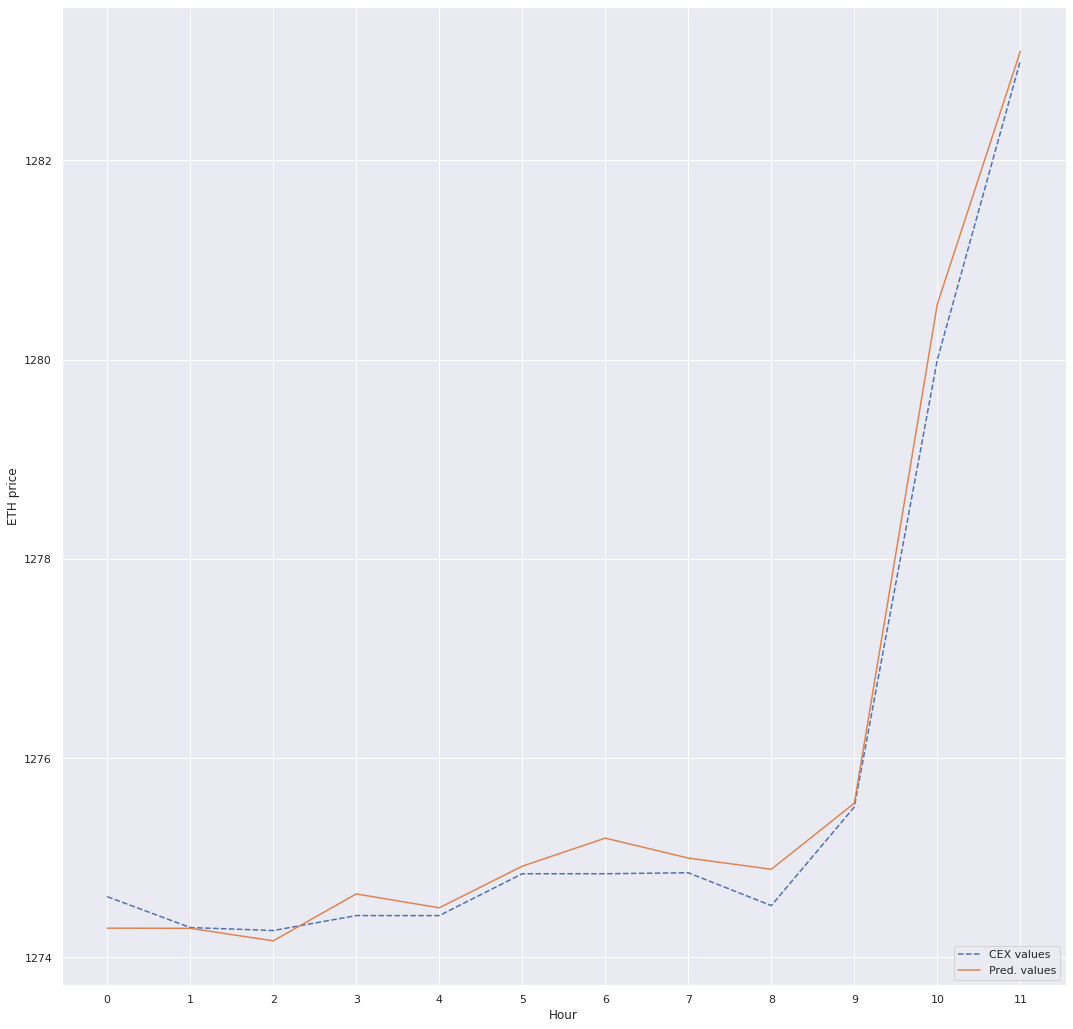

In [258]:
# now, we have predicted and actual values. Let's find error, and plot!
cex_vals = ochlv_test_data.y
nmse = calc_nmse(cex_vals, pred_vals_test)
print(f"NMSE = {nmse}")
plot_prices(cex_vals, pred_vals_test,last_x_hours)

In [342]:
# fit model with all the available data
pro_regressor_5 = Prophet()
pro_regressor_5.add_regressor('open')
pro_regressor_5.add_regressor('high')
pro_regressor_5.add_regressor('low')
pro_regressor_5.add_regressor('volume')
pro_regressor_5.fit(ochlv_data.iloc[-last_x_hours-start_hour:,:])

# generate dates for prediction (12 hours ahead of the latest datapoint in the data time)
future_dates = pro_regressor_5.make_future_dataframe(periods=17, freq="h", include_history=False)#.iloc[-12:]

# predcit eth values on future_dates
forecast = pro_regressor_5.predict(future_dates)
pred_vals = forecast.set_index('ds')['yhat'].to_numpy()


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/3iphqkeo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/ej7ome_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23562', 'data', 'file=/tmp/tmpmu0vbl24/3iphqkeo.json', 'init=/tmp/tmpmu0vbl24/ej7ome_0.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modeldxfxww36/prophet_model-20221212062007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:20:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06

ValueError: Regressor 'open' missing from dataframe

In [453]:
future_dates


ds
0  2022-12-11 23:55:00
1  2022-12-12 00:55:00
2  2022-12-12 01:55:00
3  2022-12-12 02:55:00
4  2022-12-12 03:55:00
5  2022-12-12 04:55:00
6  2022-12-12 05:55:00
7  2022-12-12 06:55:00
8  2022-12-12 07:55:00
9  2022-12-12 08:55:00
10 2022-12-12 09:55:00
11 2022-12-12 10:55:00
12 2022-12-12 11:55:00

<AxesSubplot: >

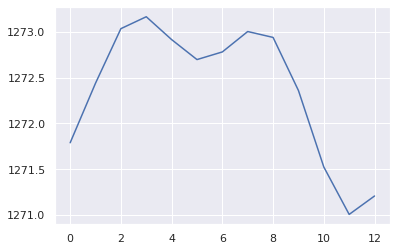

In [452]:
sns.lineplot(pred_vals)

In [259]:

ochlv_months = [g for n, g in ochlv_data.groupby(pd.Grouper(key='ds',freq='M'))]

In [262]:
ochlv_months.head()

AttributeError: 'list' object has no attribute 'head'

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/bcm85kix.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/glt57vji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40624', 'data', 'file=/tmp/tmpmu0vbl24/bcm85kix.json', 'init=/tmp/tmpmu0vbl24/glt57vji.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelp6_n_eiy/prophet_model-20221212034923.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:23 - cmdstanpy - IN

-7
NMSE = 0.002254204268408172


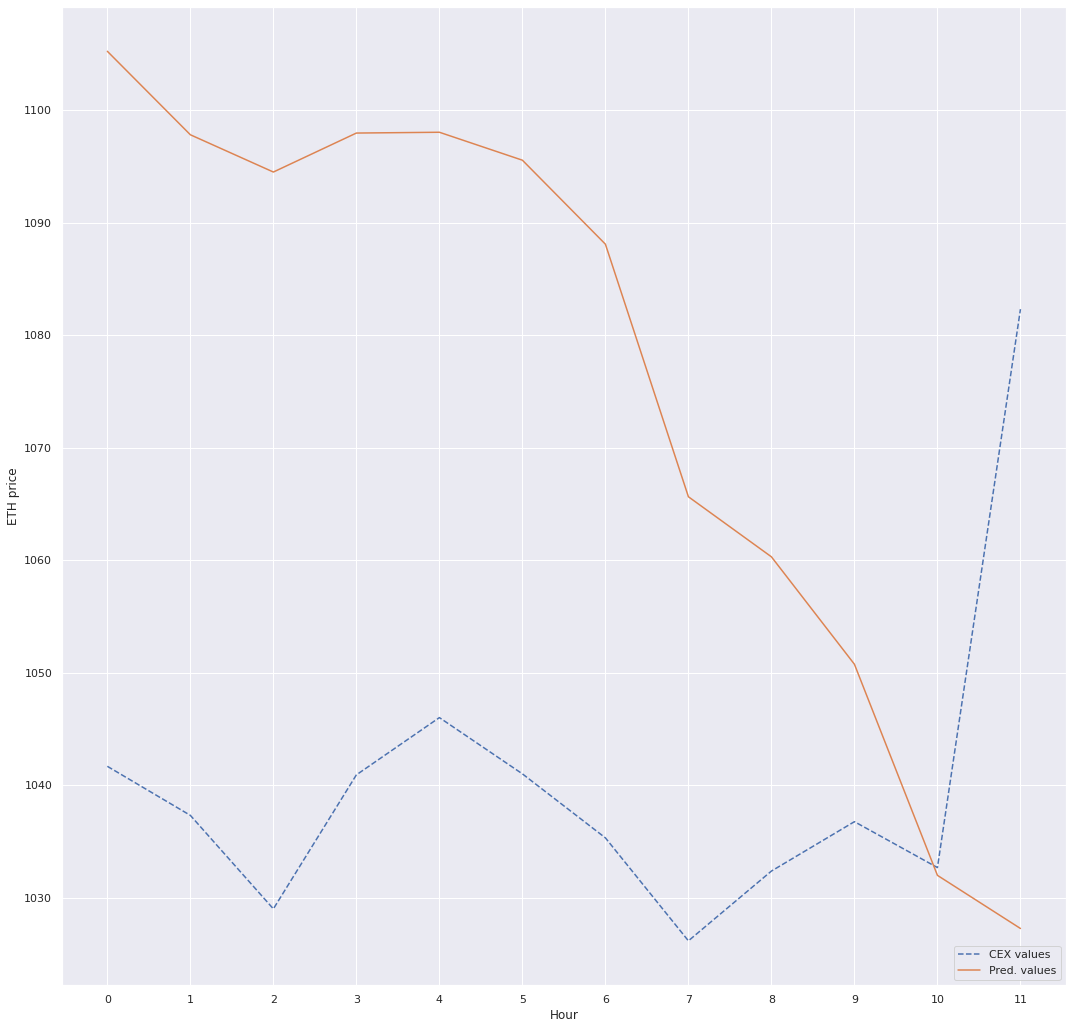

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/2yf3erbk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/9gzk8f4b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59129', 'data', 'file=/tmp/tmpmu0vbl24/2yf3erbk.json', 'init=/tmp/tmpmu0vbl24/9gzk8f4b.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model_uyozrkm/prophet_model-20221212034923.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:23 - cmdstanpy - IN

-6


03:49:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 7.322509610401012e-05


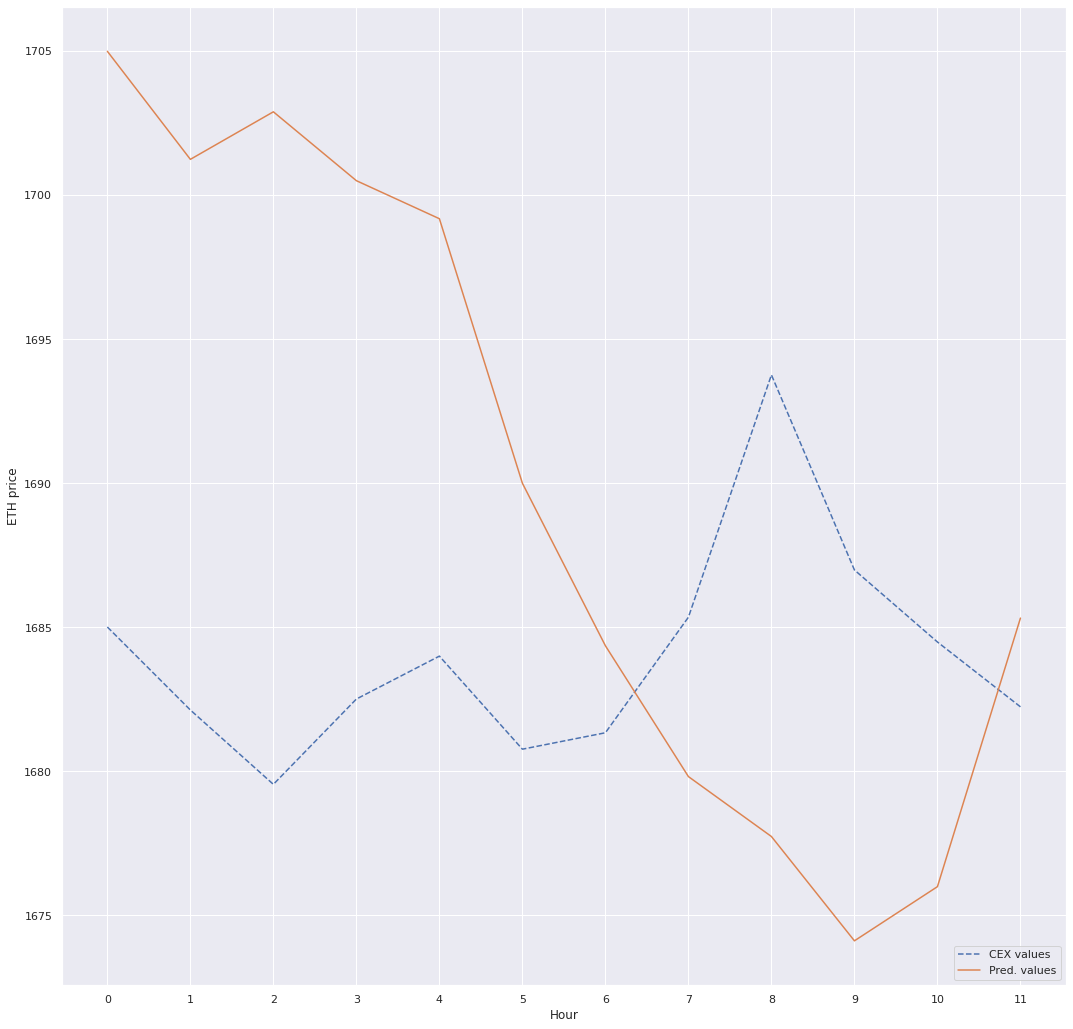

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/0zlrw867.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/9skrdf9u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57452', 'data', 'file=/tmp/tmpmu0vbl24/0zlrw867.json', 'init=/tmp/tmpmu0vbl24/9skrdf9u.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelaxswovc6/prophet_model-20221212034924.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:24 - cmdstanpy - IN

-5


03:49:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 8.088392380458427e-05


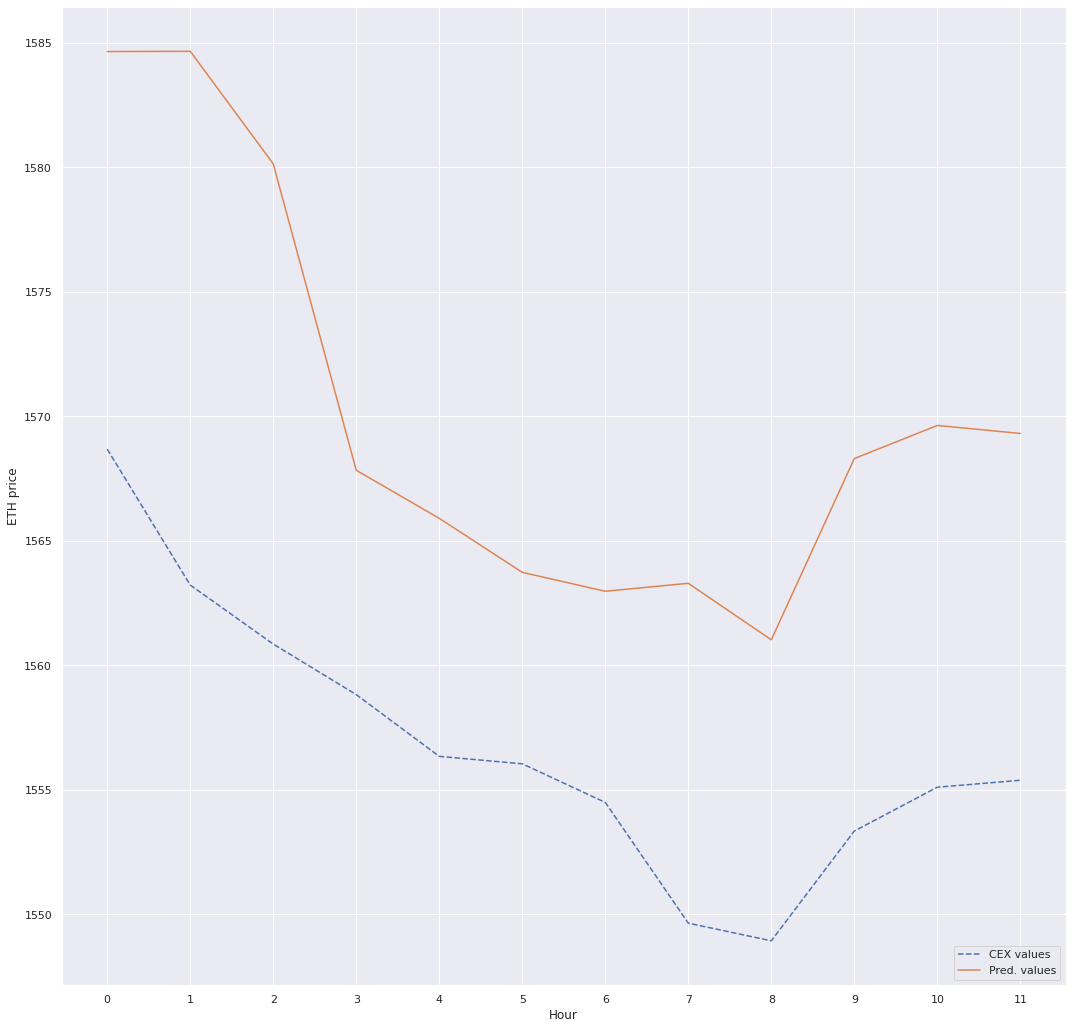

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/nw_znthb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/a__faapq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10309', 'data', 'file=/tmp/tmpmu0vbl24/nw_znthb.json', 'init=/tmp/tmpmu0vbl24/a__faapq.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelkmtvlrw6/prophet_model-20221212034924.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:24 - cmdstanpy - IN

-4


03:49:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 4.988298852168005e-06


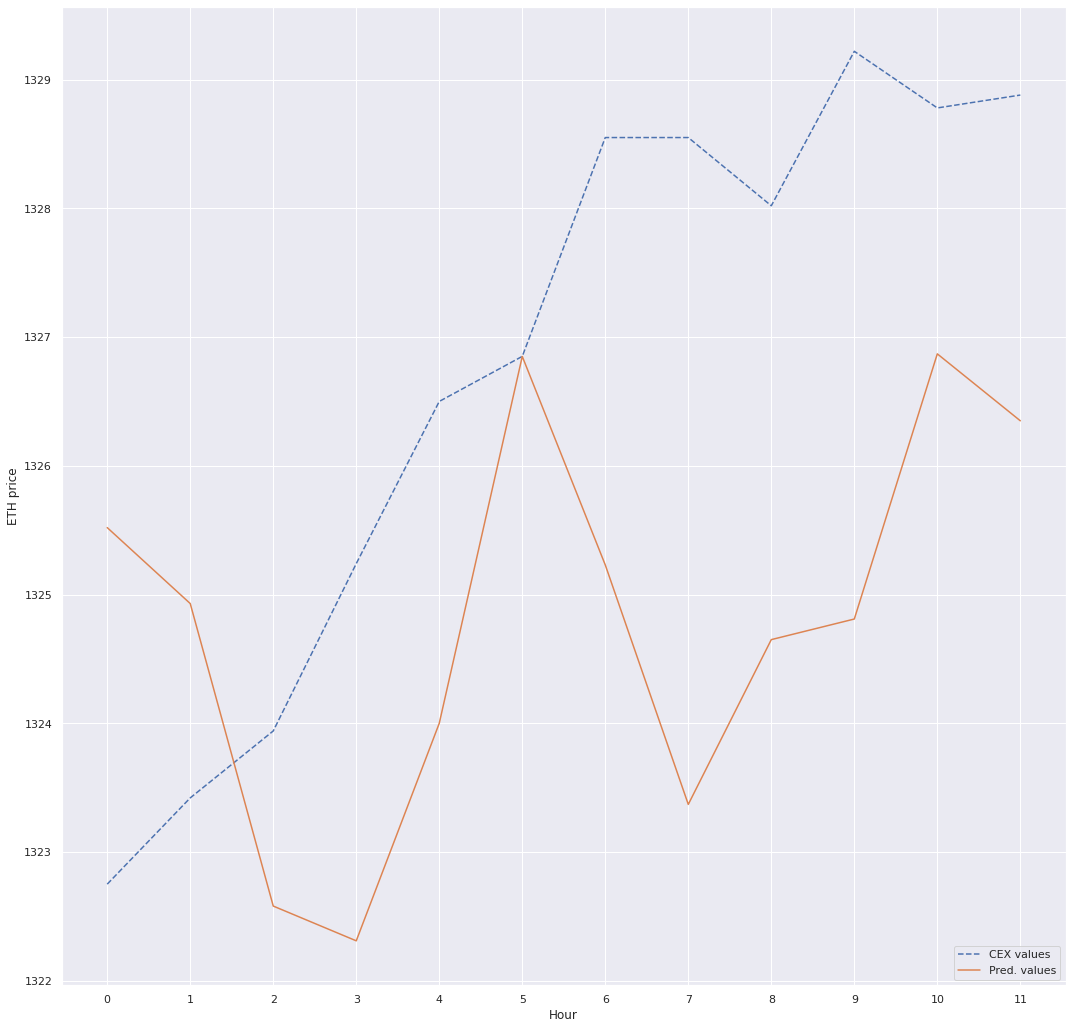

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/p6i_wtlb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/y43w2rtr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7782', 'data', 'file=/tmp/tmpmu0vbl24/p6i_wtlb.json', 'init=/tmp/tmpmu0vbl24/y43w2rtr.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelotymu704/prophet_model-20221212034925.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:25 - cmdstanpy - INF

-3
NMSE = 1.5380615095318943e-05


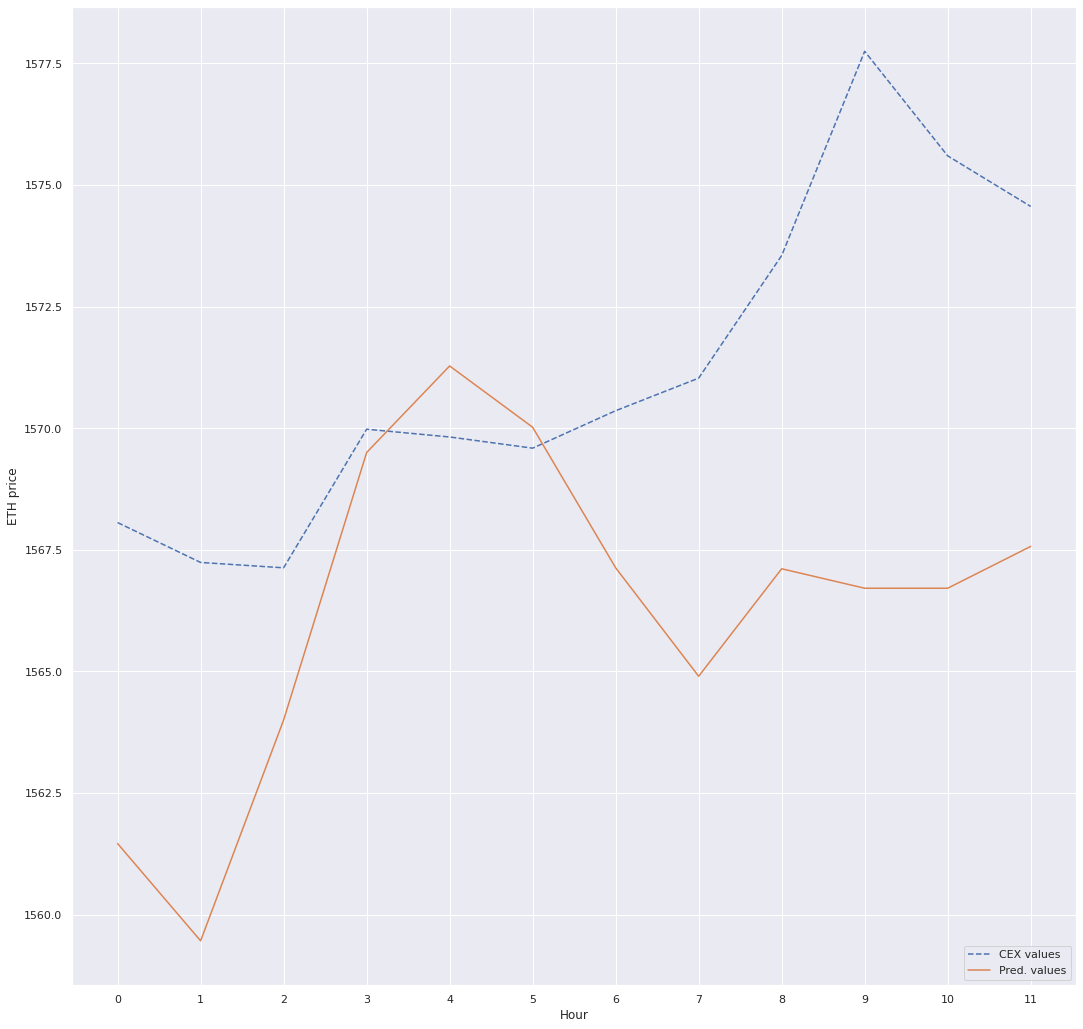

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/guh3qt78.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/hjlx9lxr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63588', 'data', 'file=/tmp/tmpmu0vbl24/guh3qt78.json', 'init=/tmp/tmpmu0vbl24/hjlx9lxr.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelw5mhft7y/prophet_model-20221212034926.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:26 - cmdstanpy - IN

-2


03:49:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 3.4881888518597646e-05


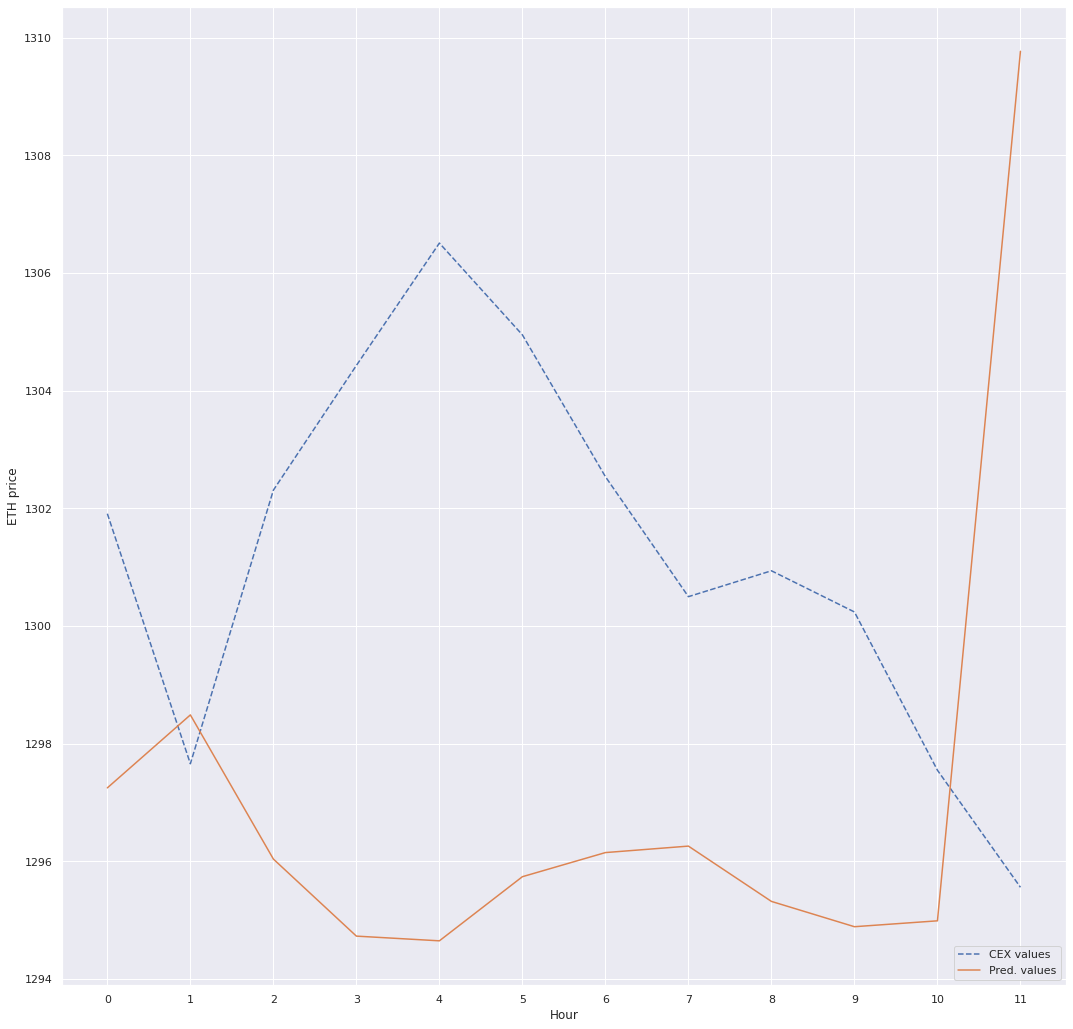

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/jsgopvxc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/kjlr6zcl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2620', 'data', 'file=/tmp/tmpmu0vbl24/jsgopvxc.json', 'init=/tmp/tmpmu0vbl24/kjlr6zcl.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model70d8q23_/prophet_model-20221212034927.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:27 - cmdstanpy - INF

-1


03:49:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 5.705873761052534e-06


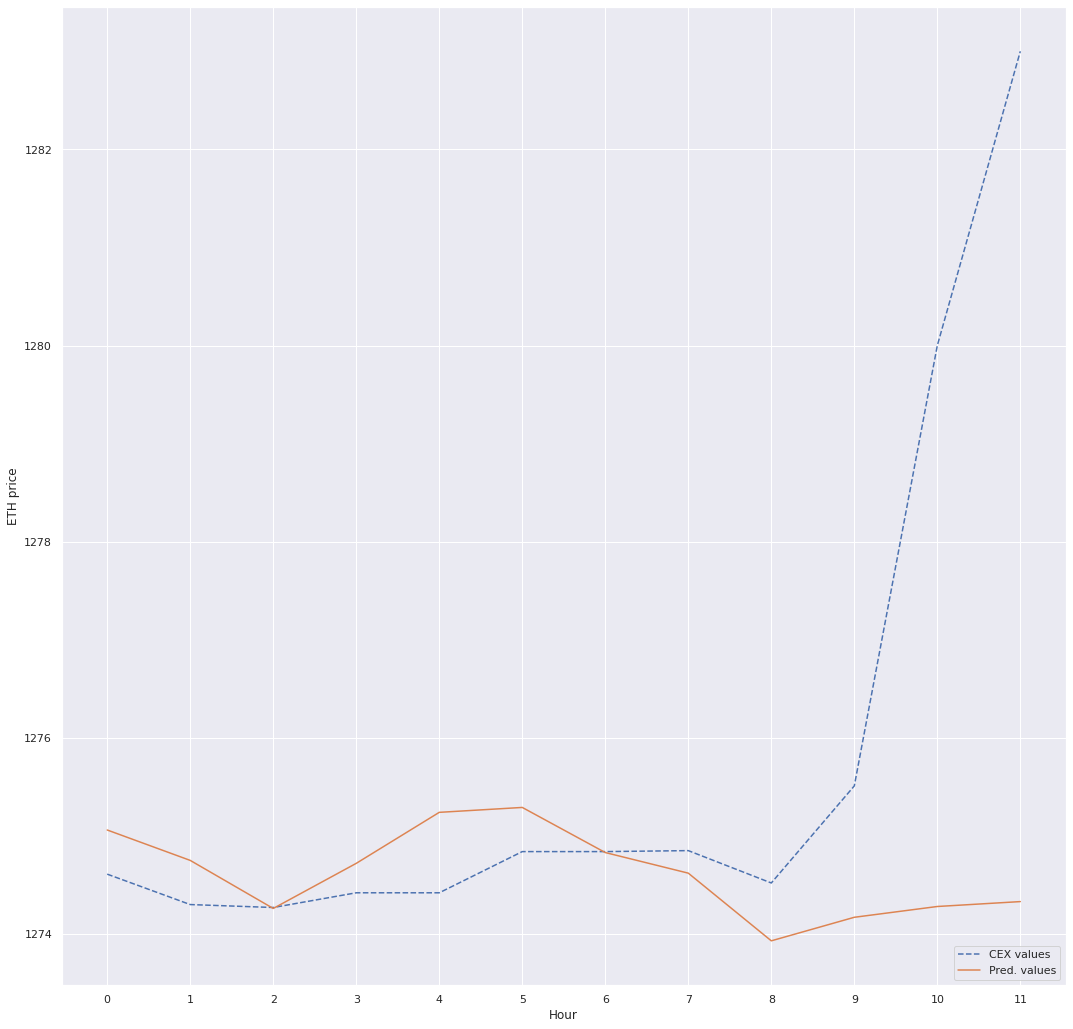

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/150p0ufj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/d77brtd4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1447', 'data', 'file=/tmp/tmpmu0vbl24/150p0ufj.json', 'init=/tmp/tmpmu0vbl24/d77brtd4.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modeltqqqx7al/prophet_model-20221212034928.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:28 - cmdstanpy - INF

0


03:49:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 0.00012849751865263398


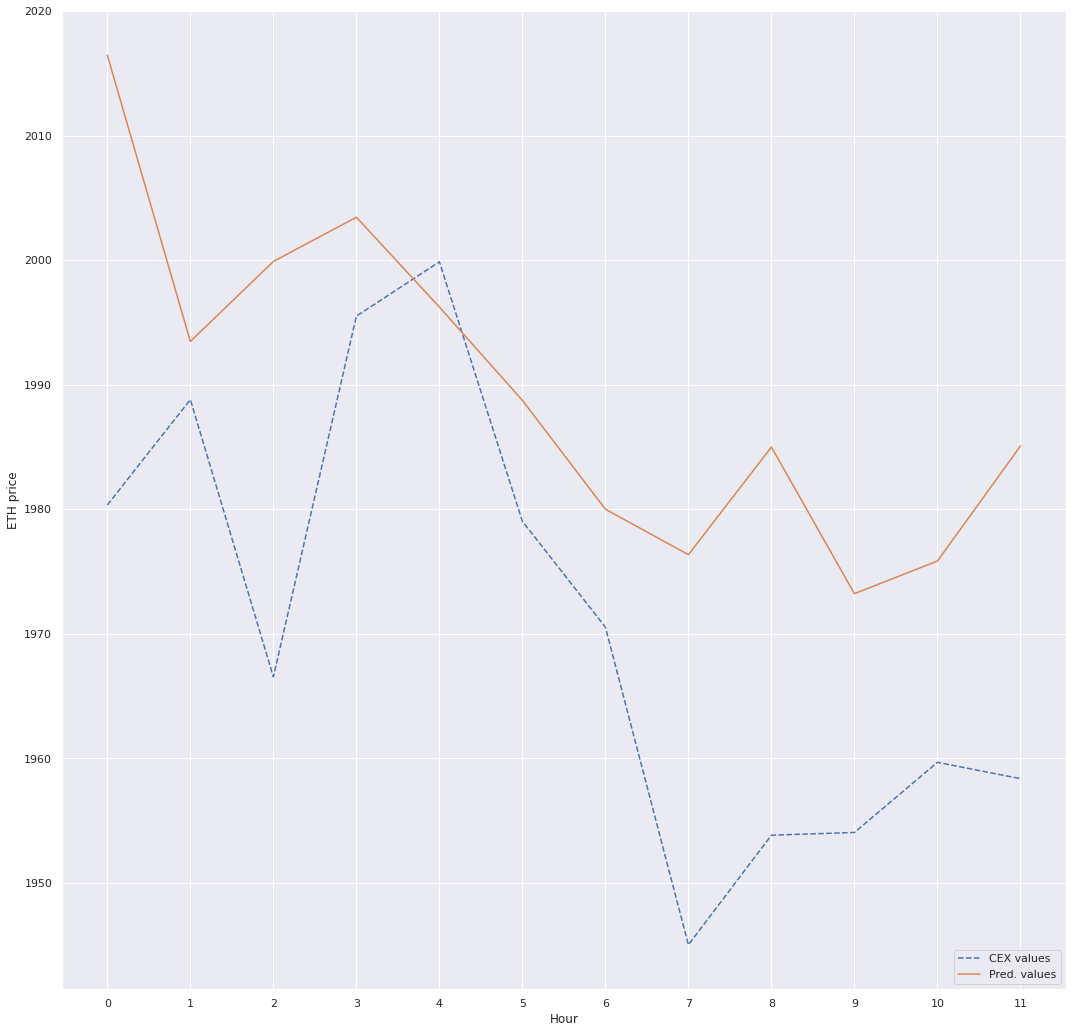

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/cw9_s1_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/t6rc50w8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12926', 'data', 'file=/tmp/tmpmu0vbl24/cw9_s1_a.json', 'init=/tmp/tmpmu0vbl24/t6rc50w8.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelvwylaelj/prophet_model-20221212034928.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:28 - cmdstanpy - IN

1
NMSE = 0.002254204268408172


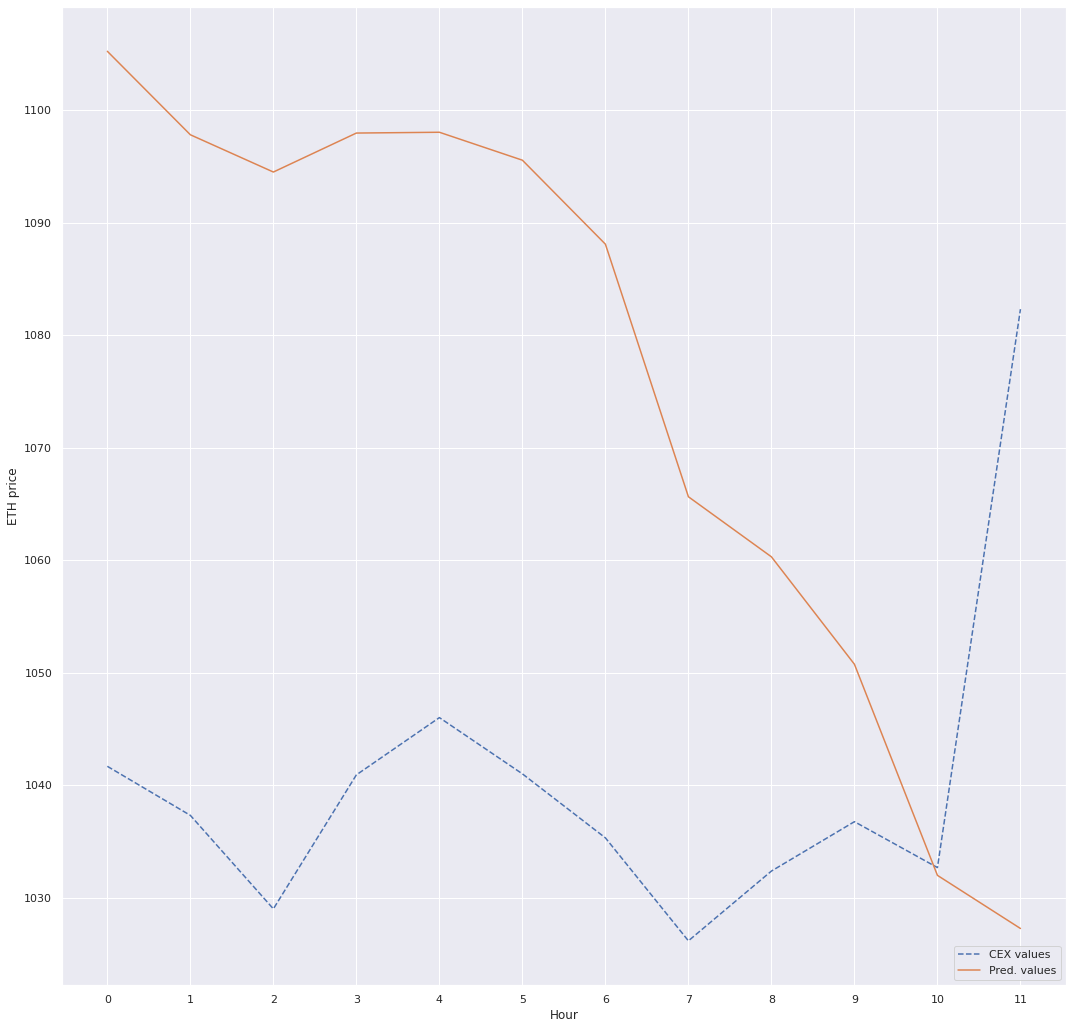

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/97n_vlcb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/x6mhcsc4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51330', 'data', 'file=/tmp/tmpmu0vbl24/97n_vlcb.json', 'init=/tmp/tmpmu0vbl24/x6mhcsc4.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelux0trveh/prophet_model-20221212034929.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:29 - cmdstanpy - IN

2


03:49:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 7.322509610401012e-05


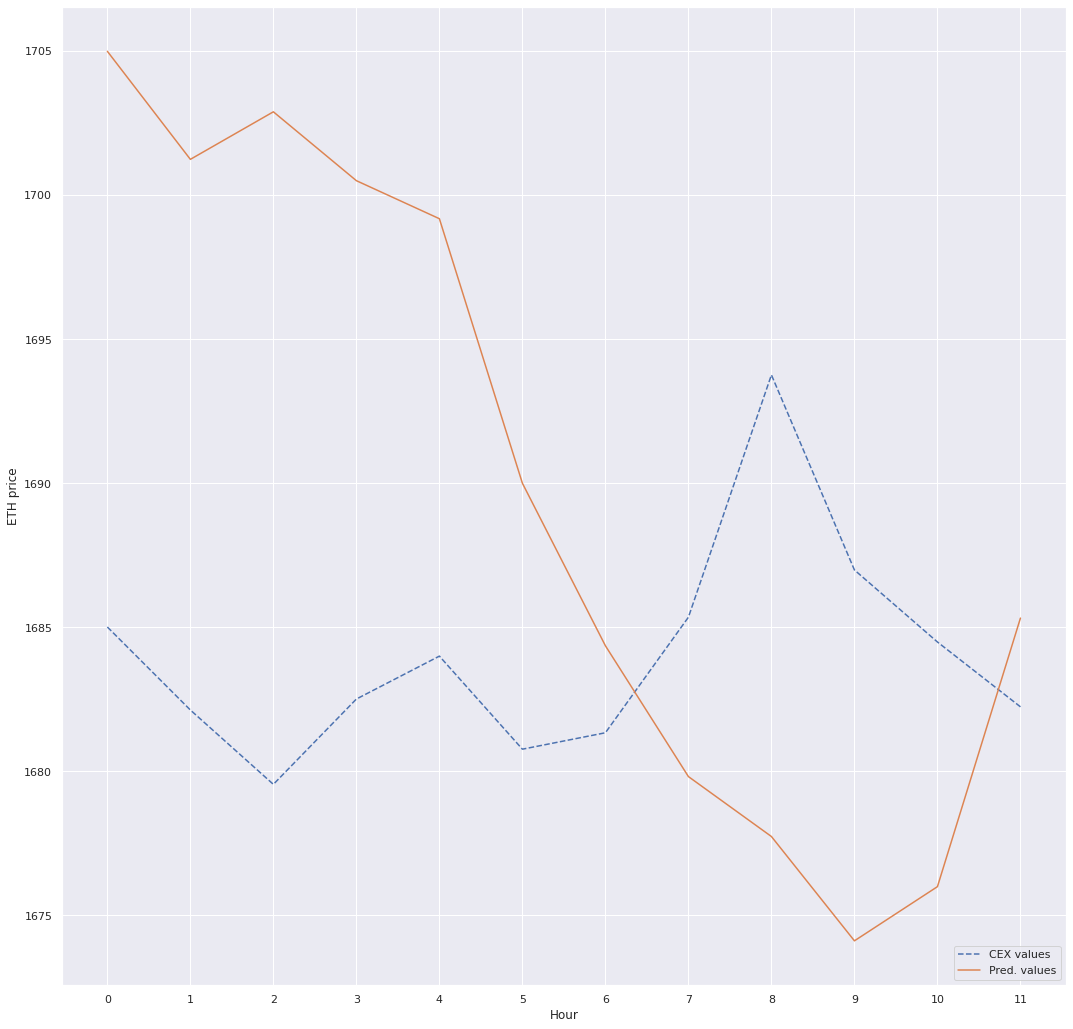

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/3nbi8ziq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/o6u_c743.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34494', 'data', 'file=/tmp/tmpmu0vbl24/3nbi8ziq.json', 'init=/tmp/tmpmu0vbl24/o6u_c743.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model6ptr7icg/prophet_model-20221212034930.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:30 - cmdstanpy - IN

3


03:49:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 8.088392380458427e-05


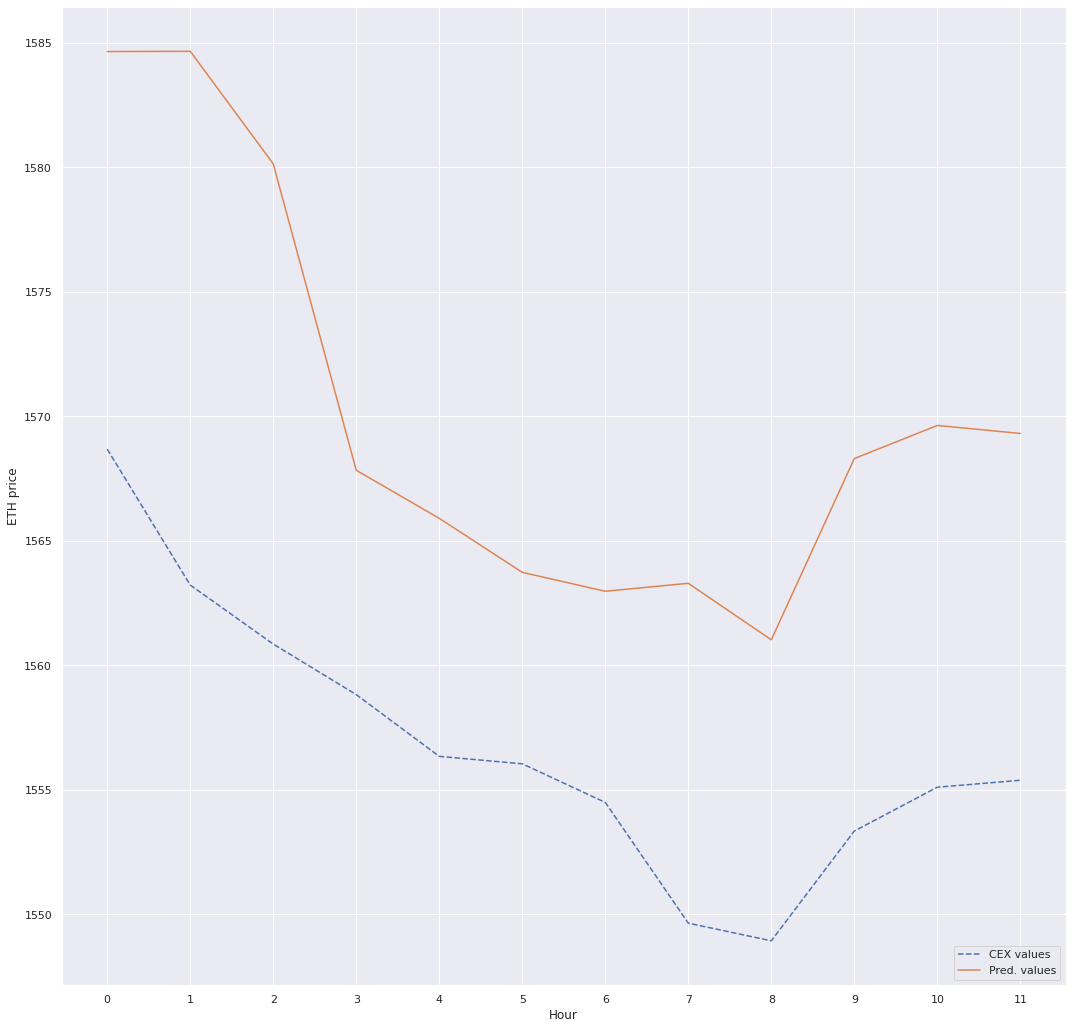

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/nt6ue2ro.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/h_e48cpy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77428', 'data', 'file=/tmp/tmpmu0vbl24/nt6ue2ro.json', 'init=/tmp/tmpmu0vbl24/h_e48cpy.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model_12ehobs/prophet_model-20221212034930.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:30 - cmdstanpy - IN

4


03:49:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 4.988298852168005e-06


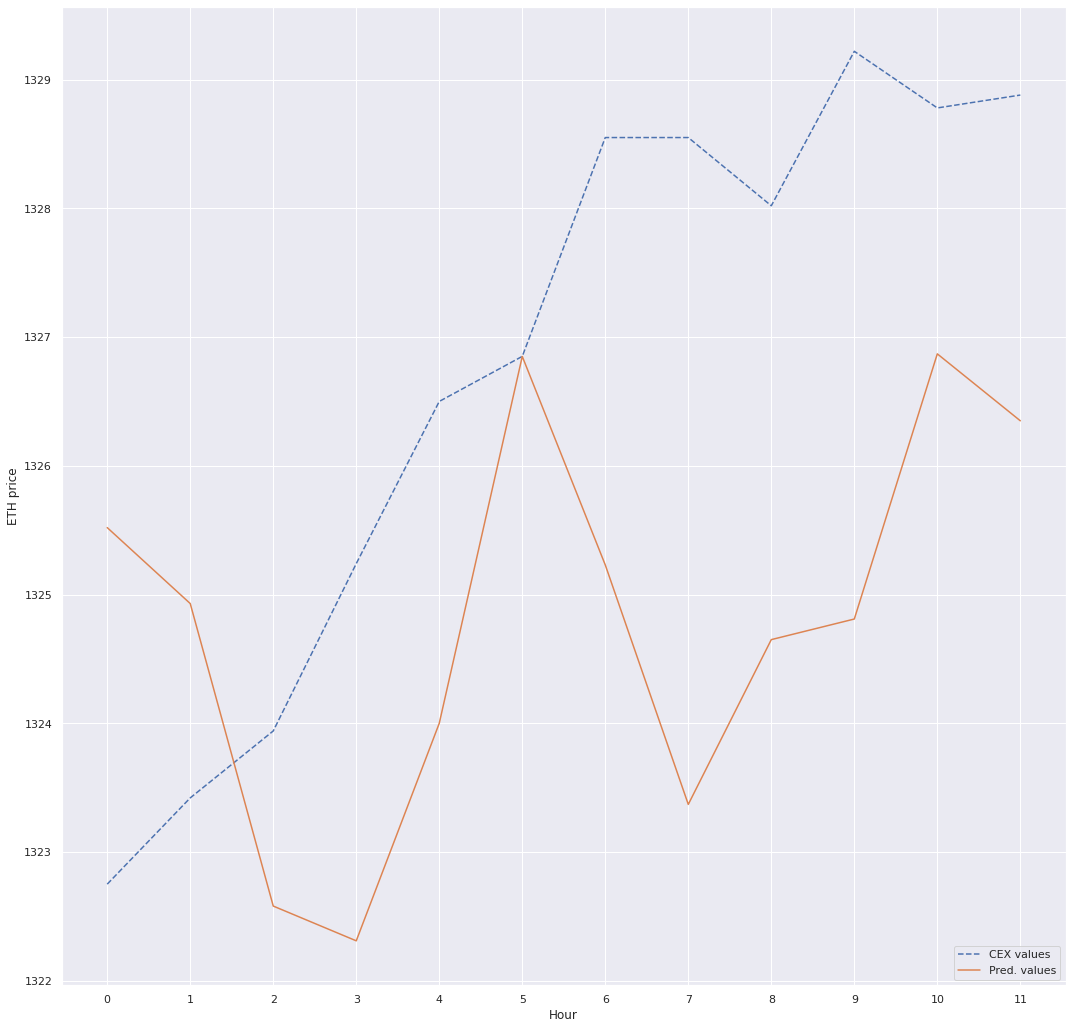

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/k71s8wyl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/o487ic1u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14474', 'data', 'file=/tmp/tmpmu0vbl24/k71s8wyl.json', 'init=/tmp/tmpmu0vbl24/o487ic1u.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelrkl2grpx/prophet_model-20221212034931.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:31 - cmdstanpy - IN

5
NMSE = 1.5380615095318943e-05


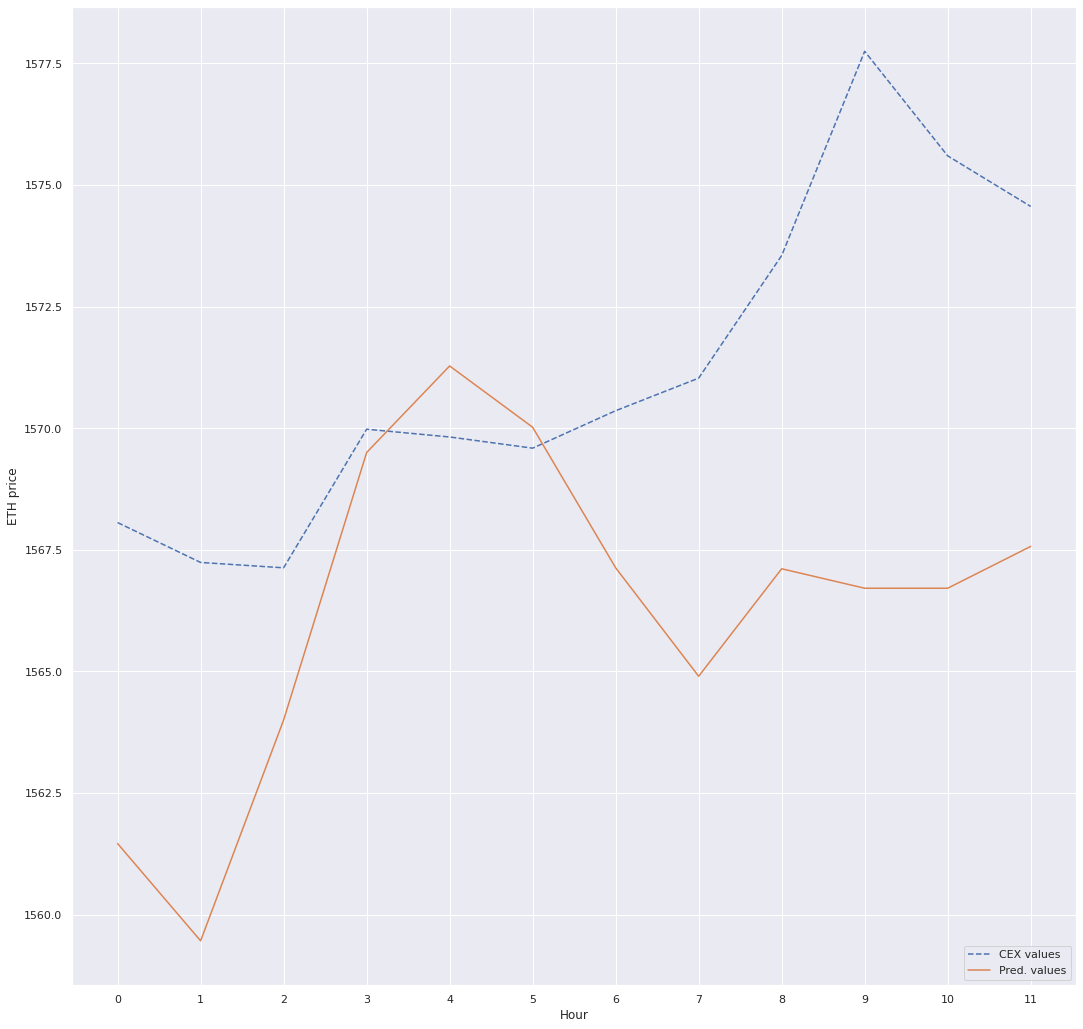

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/kj5yk8f_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/kfit8o4y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61887', 'data', 'file=/tmp/tmpmu0vbl24/kj5yk8f_.json', 'init=/tmp/tmpmu0vbl24/kfit8o4y.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_model6vailcb0/prophet_model-20221212034931.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:31 - cmdstanpy - IN

6


03:49:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 3.4881888518597646e-05


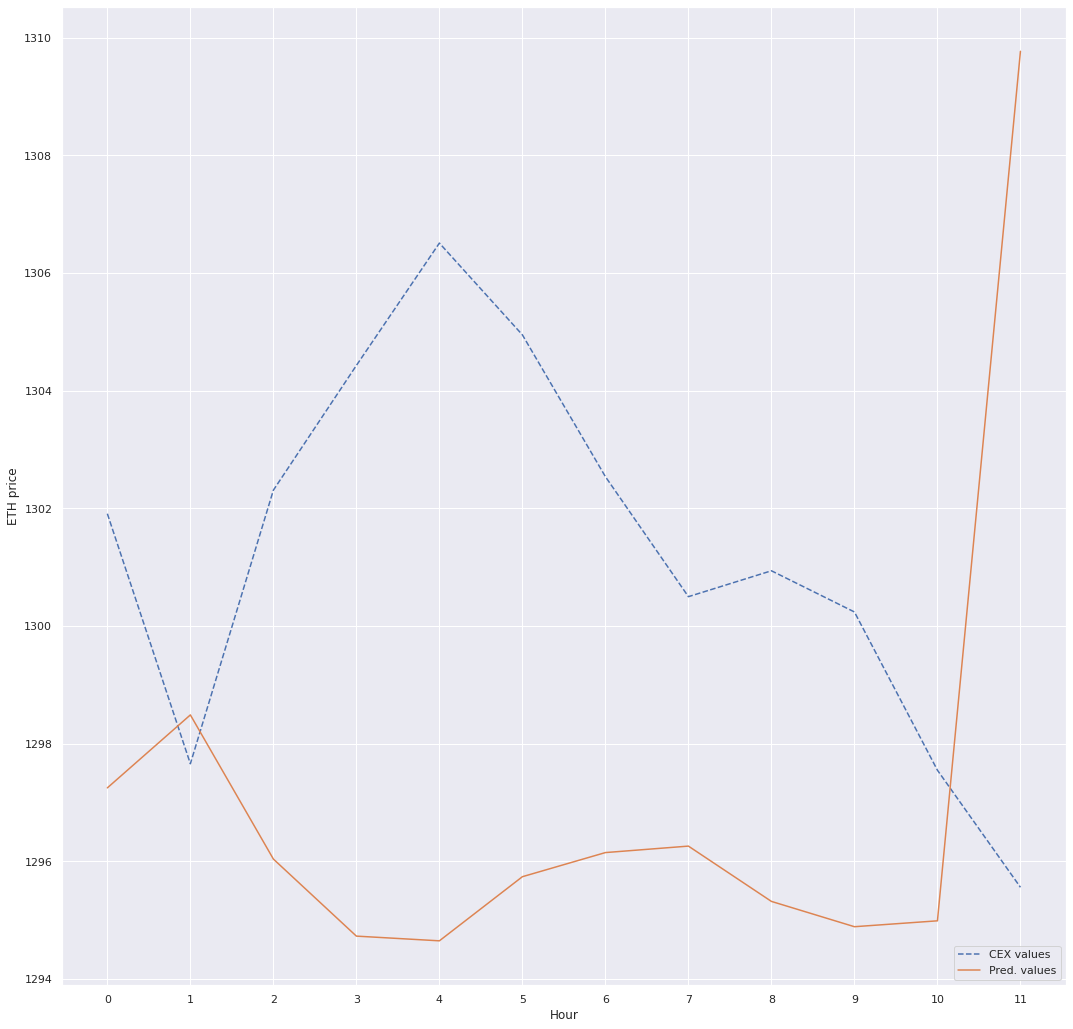

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/gygeqxc_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmu0vbl24/h3r110gr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63116', 'data', 'file=/tmp/tmpmu0vbl24/gygeqxc_.json', 'init=/tmp/tmpmu0vbl24/h3r110gr.json', 'output', 'file=/tmp/tmpmu0vbl24/prophet_modelidrc1eu4/prophet_model-20221212034932.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:49:32 - cmdstanpy - IN

7


03:49:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NMSE = 5.705873761052534e-06


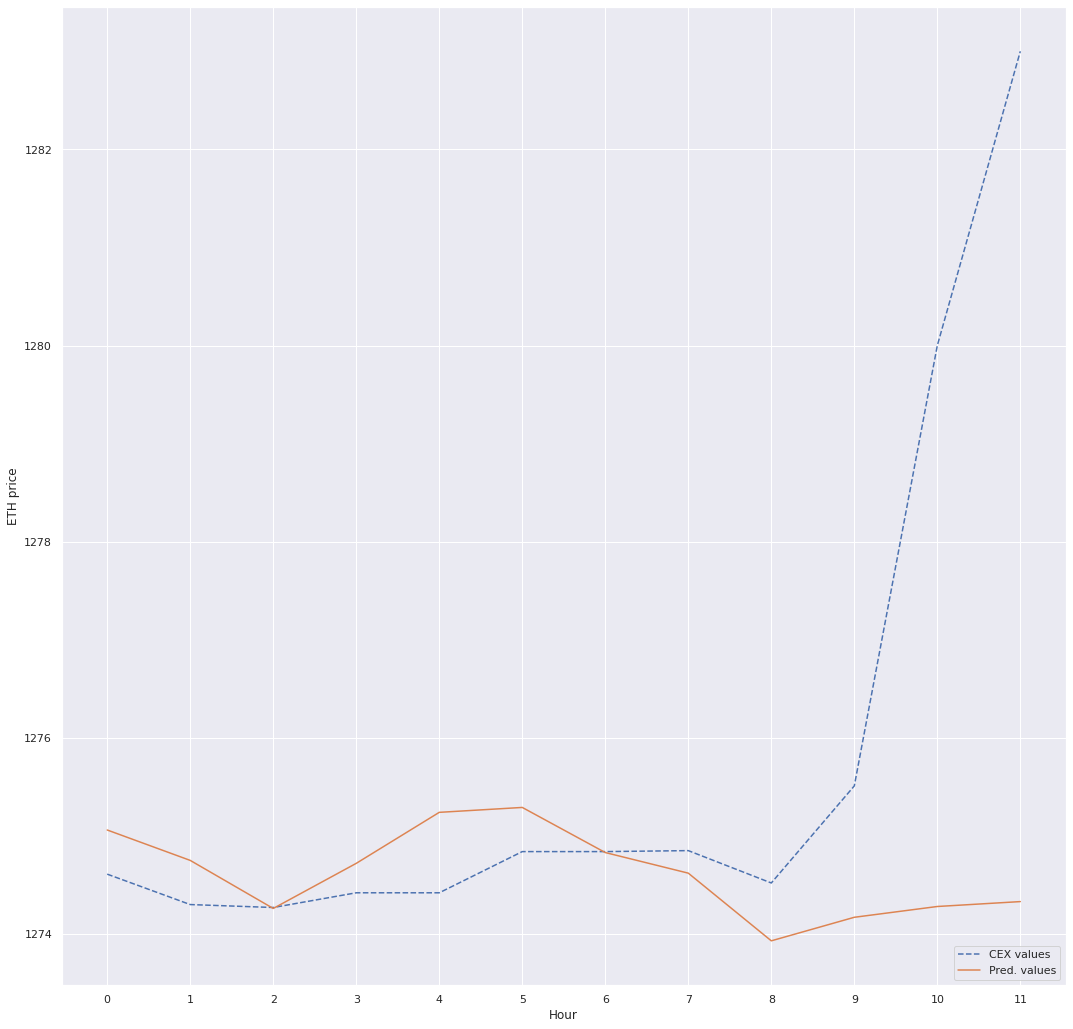

mean months nsme: 0.0003378024965160294


In [269]:
num_weeks = 1# 5 results in overfit
last_x_hours = 12
start_hour = math.ceil(24 * 7 * num_weeks) # this value doesn't matter too much

NSME_list = []

for i in range(len(ochlv_months)-15, len(ochlv_months)):
    print(i)
    w = ochlv_months[i] 
#     print(w)
    last_x_hours = 12
    
    
    train_data = w.iloc[-last_x_hours-24:-last_x_hours,:]
    test_data = w.iloc[-last_x_hours:,:]
    model= Prophet()
    model.add_regressor('open')
    model.add_regressor('high')
    model.add_regressor('low')
    model.add_regressor('volume')
    model.fit(train_data)
    #Predict ETH values over the range of the test set
    forecast = model.predict(train_data)
    pred_vals_test = forecast.set_index('ds')['yhat'][-last_x_hours:].to_numpy()
    # now, we have predicted and actual values. Let's find error, and plot!
    cex_vals = test_data.y
    nmse = calc_nmse(cex_vals, pred_vals_test)
    print(f"NMSE = {nmse}")
    NSME_list.append(nmse)
    plot_prices(cex_vals, pred_vals_test,last_x_hours)
    
print("=" * 10)
print(f"mean months nsme: {np.mean(NSME_list)}")

# Try auto arima

In [134]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.5 MB/s eta 0:00:000m eta 0:00:010:01
  Using cached Cython-0.29.32-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)


In [140]:
train_data.columns

Index(['ds', 'y'], dtype='object')

In [31]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

auto_arima_model = pm.auto_arima(train_data['y'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_arima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2822.526, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14395.668, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2813.829, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2809.876, Time=0.18 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=2798.053, Time=0.38 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=3795.262, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2802.959, Time=0.33 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=2801.681, Time=0.45 sec
 

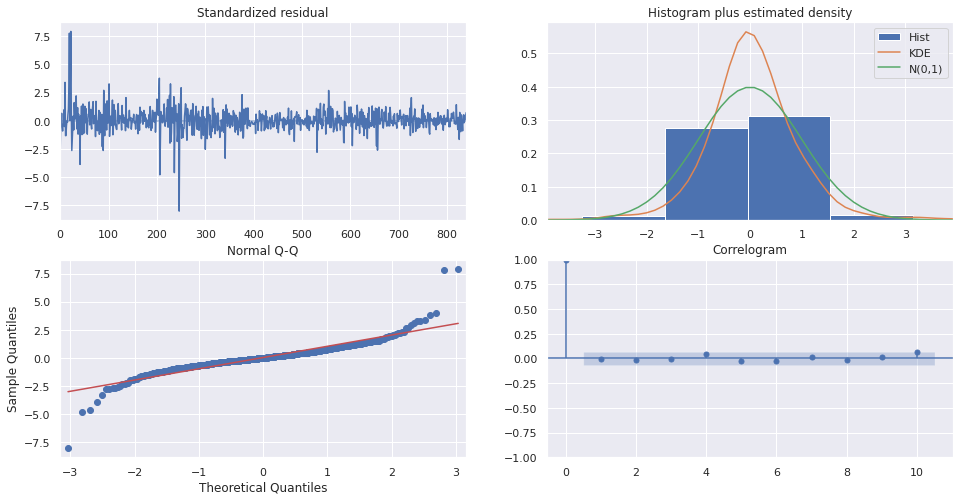

In [32]:


auto_arima_model.plot_diagnostics(figsize=(16,8))
plt.show()





So how to interpret the plot diagnostics?

    Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance between (-4, 4).

    Top Right: The density plot suggest normal distribution with mean zero.

    Bottom left: The most part of the blue dots are over the red line, so it seems that the distribution in very low skewed (not skewed for me).

    Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated.



In [41]:
test_data['y']

47990    1272.57
47991    1271.52
47992    1271.76
47993    1272.81
47994    1273.18
47995    1273.69
47996    1273.26
47997    1272.81
47998    1272.59
47999    1273.89
48000    1273.89
48001    1273.73
Name: y, dtype: float64

In [38]:
aa_predictions

47990    1272.661873
47991    1272.568219
47992    1272.628699
47993    1272.597306
47994    1272.566429
47995    1272.536059
47996    1272.506187
47997    1272.476806
47998    1272.447908
47999    1272.419484
48000    1272.391527
48001    1272.364029
dtype: float64

In [37]:
aa_predictions = auto_arima_model.predict(12)

NMSE = 5.445084325862161e-07


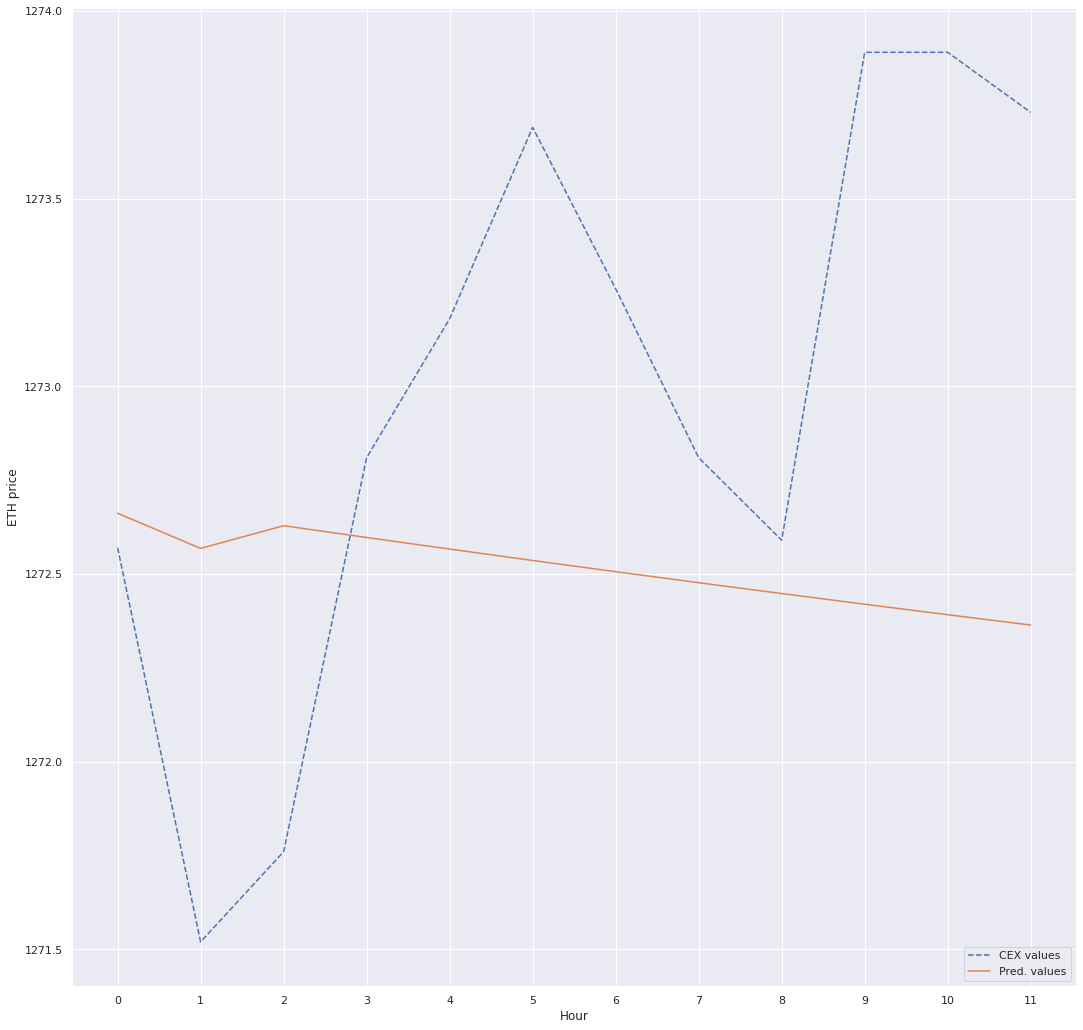

In [42]:
cex_vals = test_data.y
nmse = calc_nmse(cex_vals, aa_predictions)
print(f"NMSE = {nmse}")
plot_prices(cex_vals, aa_predictions,last_x_hours)

## LIGHTGBM

In [189]:
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.6 MB/s eta 0:00:00m eta 0:00:010:01:01


In [271]:
#ref https://www.kaggle.com/code/sugghi/training-3rd-place-solution
import lightgbm as lgb

In [272]:
lags = [60,300,900]

In [289]:

seed0 = 8586

params = {
    'early_stopping_rounds': 50,
    'objective': 'regression',
    'metric': 'rmse',
#     'metric': 'None',
    'boosting_type': 'gbdt',
    'max_depth': 5,
    'verbose': -1,
    'max_bin':600,
    'min_data_in_leaf':50,
    'learning_rate': 0.03,
    'subsample': 0.7,
    'subsample_freq': 1,
    'feature_fraction': 1,
    'lambda_l1': 0.5,
    'lambda_l2': 2,
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_fraction_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'extra_trees': True,
    'extra_seed': seed0,
    'zero_as_missing': True,
    "first_metric_only": True
         }



In [276]:
ochlv_data.columns

Index(['ds', 'open', 'y', 'high', 'low', 'volume'], dtype='object')

In [277]:
def lgb_get_features(df):   
    close_col = 'y'
    for lag in lags:
        df[f'log_close/mean_{lag}'] = np.log( np.array(df[close_col]) /  np.roll(np.append(np.convolve( np.array(df[close_col]), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1)  )
        df[f'log_return_{lag}']     = np.log( np.array(df[close_col]) /  np.roll(np.array(df[close_col]), lag)  )
    return df

In [319]:
ochlv_data_lgb = lgb_get_features(ochlv_data).drop(columns=["open","high","low","volume"])
ochlv_data_lgb.head()

ds        y  log_close/mean_60  log_return_60  \
0 2022-05-21 00:00:00  1973.95           7.587792       0.439336   
1 2022-05-21 01:00:00  1965.41           7.583456       0.435079   
2 2022-05-21 02:00:00  1962.57           7.582010       0.434270   
3 2022-05-21 03:00:00  1969.95           7.585763       0.438377   
4 2022-05-21 04:00:00  1969.43           7.585499       0.437610   

   log_close/mean_300  log_return_300  log_close/mean_900  log_return_900  
0            7.587792        0.440421            7.587792        0.454496  
1            7.583456        0.435740            7.583456        0.450352  
2            7.582010        0.434435            7.582010        0.450671  
3            7.585763        0.437245            7.585763        0.452994  
4            7.585499        0.437445            7.585499        0.452890

In [320]:
not_use_features_train = ['ds', 'y']
features = list(ochlv_data_lgb.columns.drop(not_use_features_train))

In [321]:
features

['log_close/mean_60',
 'log_return_60',
 'log_close/mean_300',
 'log_return_300',
 'log_close/mean_900',
 'log_return_900']

In [322]:
# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
# (used in nyanp's Optiver solution)
def plot_importance(importances, features_names = features, PLOT_TOP_N = 20, figsize=(10, 10)):
    importance_df = pd.DataFrame(data=importances, columns=features)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

In [323]:
n_fold = 7

# from: https://www.kaggle.com/code/nrcjea001/lgbm-embargocv-weightedpearson-lagtarget/
def get_time_series_cross_val_splits(data, cv = n_fold, embargo = 3750):
    all_train_timestamps = data['ds'].unique()
    len_split = len(all_train_timestamps) // cv
    test_splits = [all_train_timestamps[i * len_split:(i + 1) * len_split] for i in range(cv)]
    # fix the last test split to have all the last timestamps, in case the number of timestamps wasn't divisible by cv
    rem = len(all_train_timestamps) - len_split*cv
    if rem>0:
        test_splits[-1] = np.append(test_splits[-1], all_train_timestamps[-rem:])

    train_splits = []
    for test_split in test_splits:
        test_split_max = int(np.max(test_split))
        test_split_min = int(np.min(test_split))
        # get all of the timestamps that aren't in the test split
        train_split_not_embargoed = [e for e in all_train_timestamps if not (test_split_min <= int(e) <= test_split_max)]
        # embargo the train split so we have no leakage. Note timestamps are expressed in seconds, so multiply by 60
        embargo_sec = 60*embargo
        train_split = [e for e in train_split_not_embargoed if
                       abs(int(e) - test_split_max) > embargo_sec and abs(int(e) - test_split_min) > embargo_sec]
        train_splits.append(train_split)

    # convenient way to iterate over train and test splits
    train_test_zip = zip(train_splits, test_splits)
    return train_test_zip



doing split 1 out of 7
                      ds        y  log_close/mean_60  log_return_60  \
0    2022-05-21 00:00:00  1973.95           7.587792       0.439336   
1    2022-05-21 01:00:00  1965.41           7.583456       0.435079   
2    2022-05-21 02:00:00  1962.57           7.582010       0.434270   
3    2022-05-21 03:00:00  1969.95           7.585763       0.438377   
4    2022-05-21 04:00:00  1969.43           7.585499       0.437610   
...                  ...      ...                ...            ...   
6857 2022-07-21 22:40:00  1575.73           0.002152       0.018214   
6858 2022-07-21 22:45:00  1578.28           0.003402       0.022173   
6859 2022-07-21 22:50:00  1573.62           0.000055       0.023689   
6860 2022-07-21 22:55:00  1579.38           0.003270       0.026582   
6861 2022-07-21 23:00:00  1580.59           0.003594       0.026795   

      log_close/mean_300  log_return_300  log_close/mean_900  log_return_900  
0               7.587792        0.440421     

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


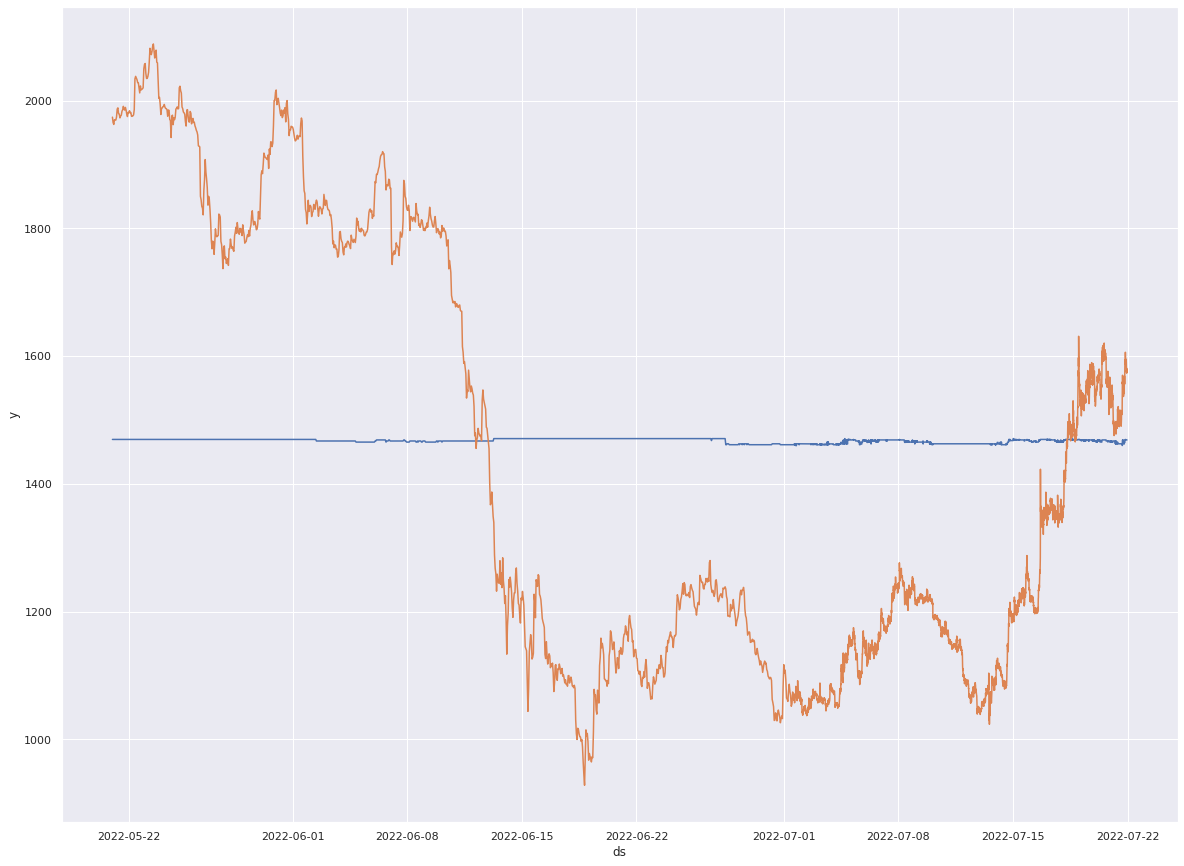

doing split 2 out of 7
                      ds        y  log_close/mean_60  log_return_60  \
0    2022-07-21 23:05:00  1582.00           0.004131       0.021384   
1    2022-07-21 23:10:00  1585.88           0.006162       0.025294   
2    2022-07-21 23:15:00  1582.96           0.003934       0.023263   
3    2022-07-21 23:20:00  1584.94           0.004770       0.025005   
4    2022-07-21 23:25:00  1588.99           0.006836       0.029415   
...                  ...      ...                ...            ...   
6858 2022-08-14 18:00:00  1925.44          -0.023751      -0.031487   
6859 2022-08-14 18:05:00  1923.25          -0.024353      -0.032413   
6860 2022-08-14 18:10:00  1923.48          -0.023714      -0.031402   
6861 2022-08-14 18:15:00  1922.58          -0.023671      -0.030958   
6862 2022-08-14 18:20:00  1923.29          -0.022799      -0.030362   

      log_close/mean_300  log_return_300  log_close/mean_900  log_return_900  
0               0.036665        0.021455     

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's rmse: 182.998	valid_1's rmse: 308.564
Early stopping, best iteration is:
[103]	training's rmse: 182.723	valid_1's rmse: 308.377
Evaluated only: rmse
Trained model was saved to 'trained_model_fold1.pkl'



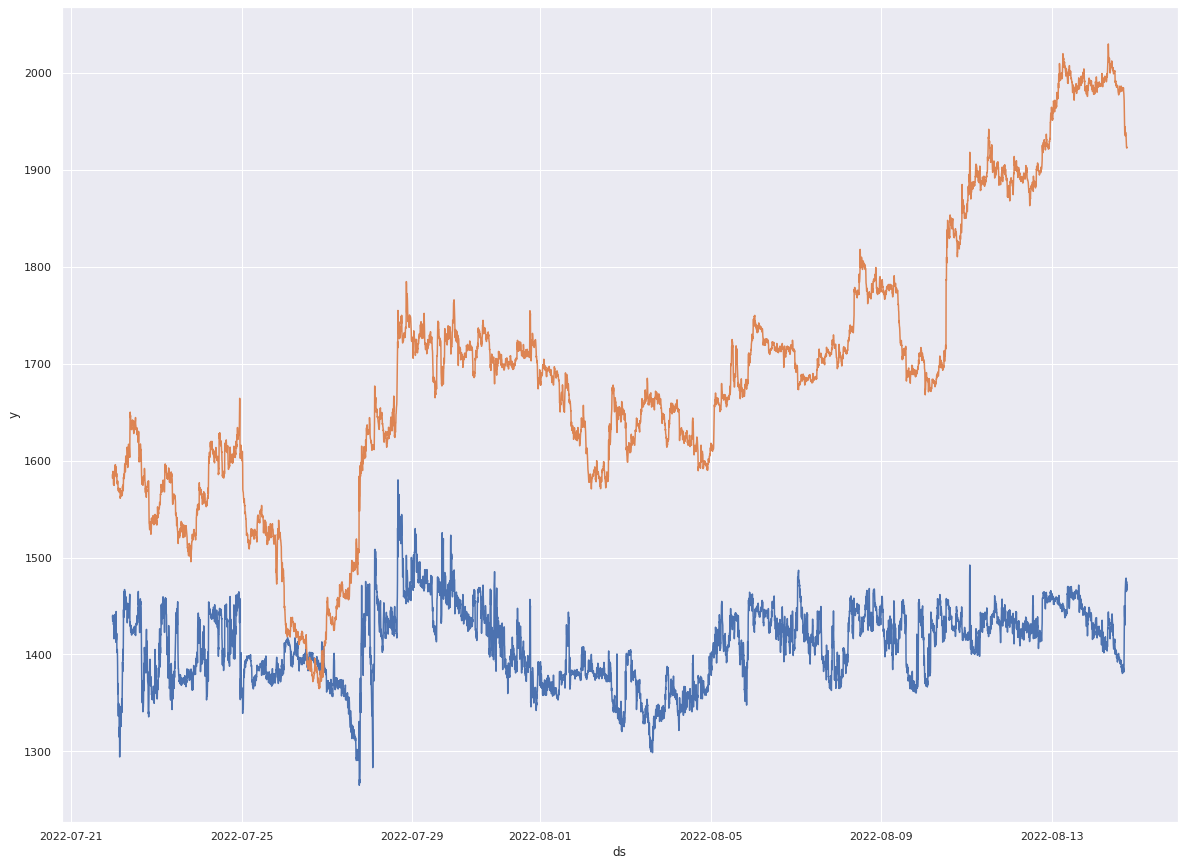

doing split 3 out of 7
                      ds        y  log_close/mean_60  log_return_60  \
0    2022-08-14 18:25:00  1928.29          -0.019766      -0.026393   
1    2022-08-14 18:30:00  1929.67          -0.018626      -0.025622   
2    2022-08-14 18:35:00  1932.45          -0.016796      -0.023530   
3    2022-08-14 18:40:00  1931.59          -0.016853      -0.023449   
4    2022-08-14 18:45:00  1930.54          -0.016955      -0.026579   
...                  ...      ...                ...            ...   
6858 2022-09-07 13:20:00  1538.16           0.012936       0.012594   
6859 2022-09-07 13:25:00  1537.00           0.011989       0.011497   
6860 2022-09-07 13:30:00  1542.95           0.015604       0.014769   
6861 2022-09-07 13:35:00  1547.70           0.018373       0.018112   
6862 2022-09-07 13:40:00  1550.00           0.019511       0.020650   

      log_close/mean_300  log_return_300  log_close/mean_900  log_return_900  
0              -0.030324       -0.033900     

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


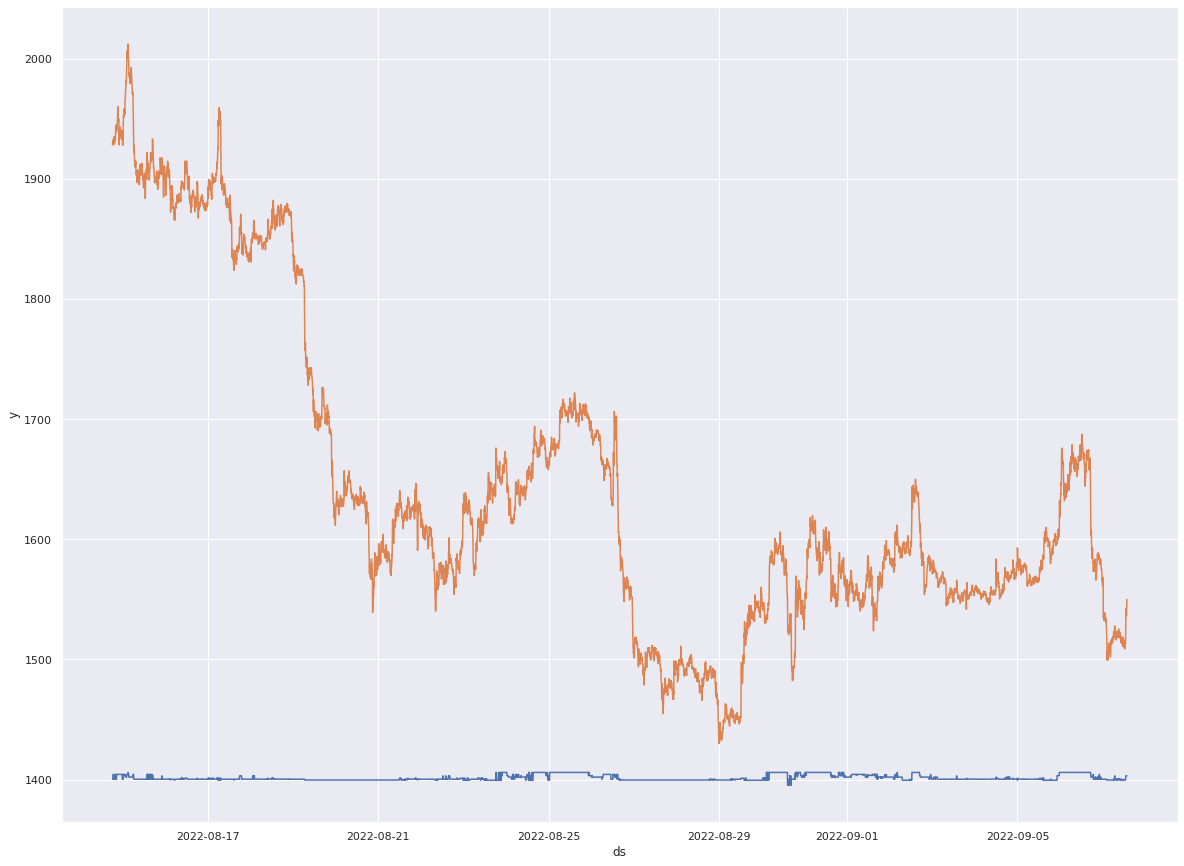

doing split 4 out of 7
                      ds        y  log_close/mean_60  log_return_60  \
0    2022-09-07 13:45:00  1546.42           0.016908       0.017252   
1    2022-09-07 13:50:00  1544.10           0.015160       0.014705   
2    2022-09-07 13:55:00  1542.42           0.013845       0.013492   
3    2022-09-07 14:00:00  1539.48           0.011781       0.009280   
4    2022-09-07 14:05:00  1543.07           0.013872       0.014235   
...                  ...      ...                ...            ...   
6858 2022-10-01 08:40:00  1332.58           0.002523       0.003044   
6859 2022-10-01 08:45:00  1332.38           0.002323       0.002984   
6860 2022-10-01 08:50:00  1332.43           0.002320       0.002420   
6861 2022-10-01 08:55:00  1331.89           0.001891       0.001420   
6862 2022-10-01 09:00:00  1332.54           0.002345       0.002051   

      log_close/mean_300  log_return_300  log_close/mean_900  log_return_900  
0              -0.010361       -0.080575     

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's rmse: 204.975	valid_1's rmse: 157.487
Early stopping, best iteration is:
[63]	training's rmse: 208.585	valid_1's rmse: 156.973
Evaluated only: rmse
Trained model was saved to 'trained_model_fold3.pkl'



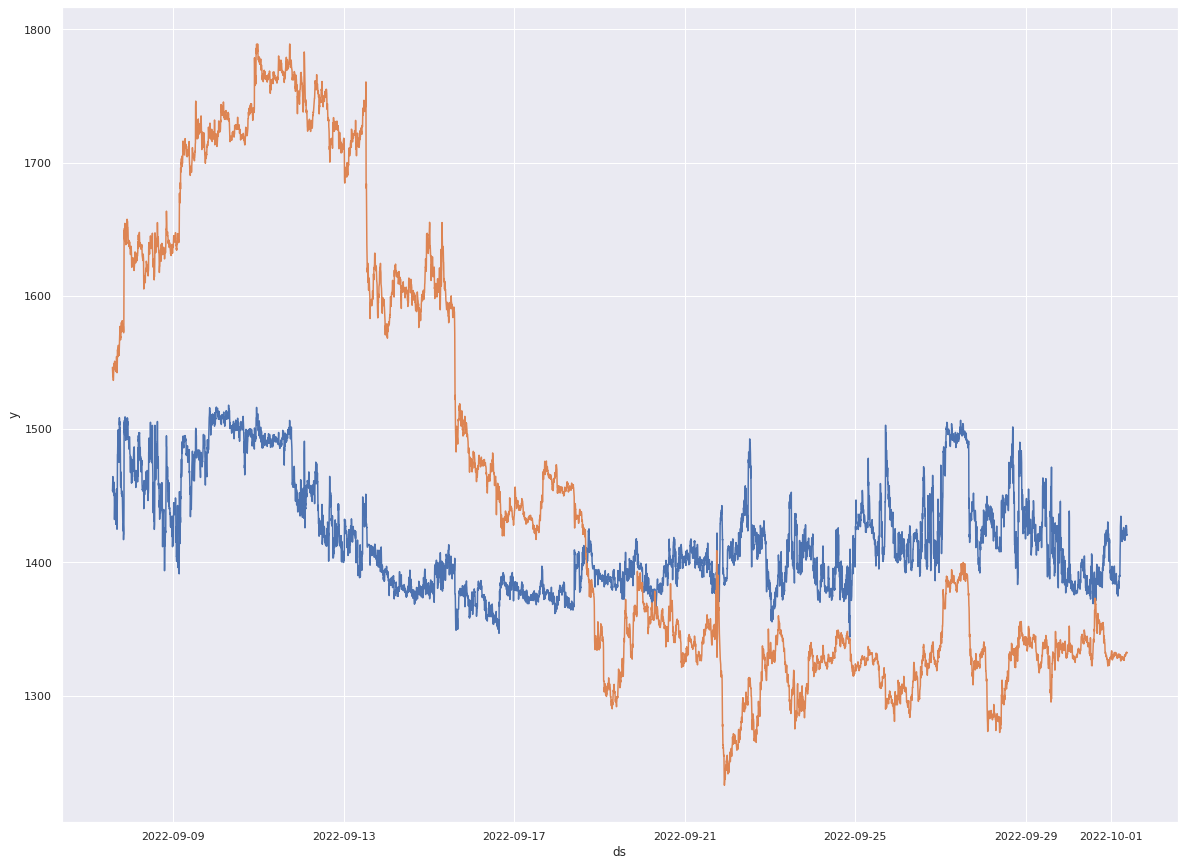

doing split 5 out of 7
                      ds        y  log_close/mean_60  log_return_60  \
0    2022-10-01 09:05:00  1333.00           0.002657       0.001952   
1    2022-10-01 09:10:00  1331.26           0.001352      -0.000038   
2    2022-10-01 09:15:00  1331.11           0.001239       0.000000   
3    2022-10-01 09:20:00  1330.97           0.001115       0.001165   
4    2022-10-01 09:25:00  1330.80           0.000961       0.001534   
...                  ...      ...                ...            ...   
6858 2022-10-25 04:00:00  1348.47           0.003849       0.001009   
6859 2022-10-25 04:05:00  1348.33           0.003714       0.001871   
6860 2022-10-25 04:10:00  1351.26           0.005817       0.004064   
6861 2022-10-25 04:15:00  1347.23           0.002806       0.001419   
6862 2022-10-25 04:20:00  1346.72           0.002409       0.001092   

      log_close/mean_300  log_return_300  log_close/mean_900  log_return_900  
0              -0.003314       -0.006327     

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's rmse: 208.437	valid_1's rmse: 138.184
Early stopping, best iteration is:
[63]	training's rmse: 212.559	valid_1's rmse: 136.66
Evaluated only: rmse
Trained model was saved to 'trained_model_fold4.pkl'



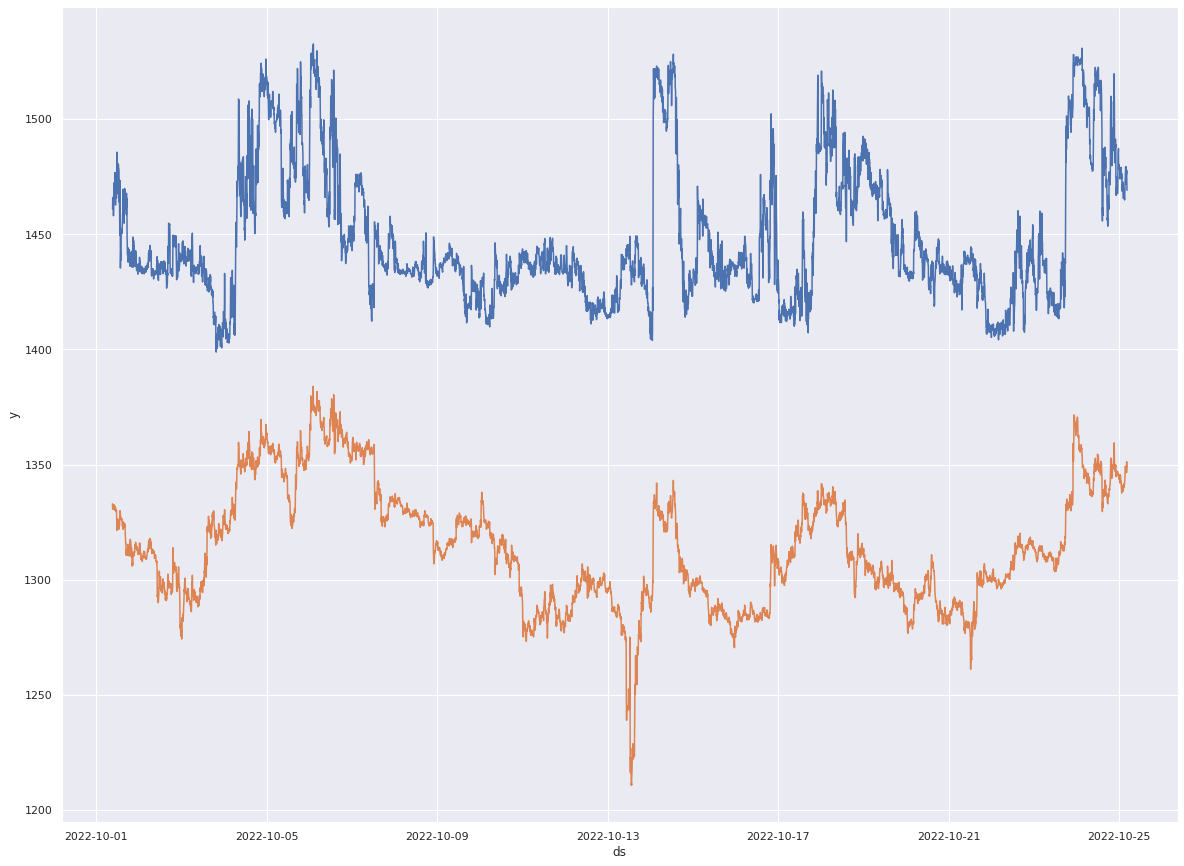

doing split 6 out of 7
                      ds        y  log_close/mean_60  log_return_60  \
0    2022-10-25 04:25:00  1346.30           0.002084       0.000803   
1    2022-10-25 04:30:00  1346.68           0.002357       0.000535   
2    2022-10-25 04:35:00  1346.22           0.002005       0.000624   
3    2022-10-25 04:40:00  1346.58           0.002250       0.001382   
4    2022-10-25 04:45:00  1346.55           0.002199       0.001710   
...                  ...      ...                ...            ...   
6858 2022-11-17 23:20:00  1202.50          -0.003884      -0.008183   
6859 2022-11-17 23:25:00  1201.50          -0.004587      -0.007702   
6860 2022-11-17 23:30:00  1202.00          -0.004050      -0.007261   
6861 2022-11-17 23:35:00  1201.21          -0.004539      -0.010122   
6862 2022-11-17 23:40:00  1201.67          -0.004005      -0.009088   

      log_close/mean_300  log_return_300  log_close/mean_900  log_return_900  
0               0.001688       -0.002396     

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's rmse: 206.441	valid_1's rmse: 142.109
Early stopping, best iteration is:
[122]	training's rmse: 204.745	valid_1's rmse: 141.72
Evaluated only: rmse
Trained model was saved to 'trained_model_fold5.pkl'



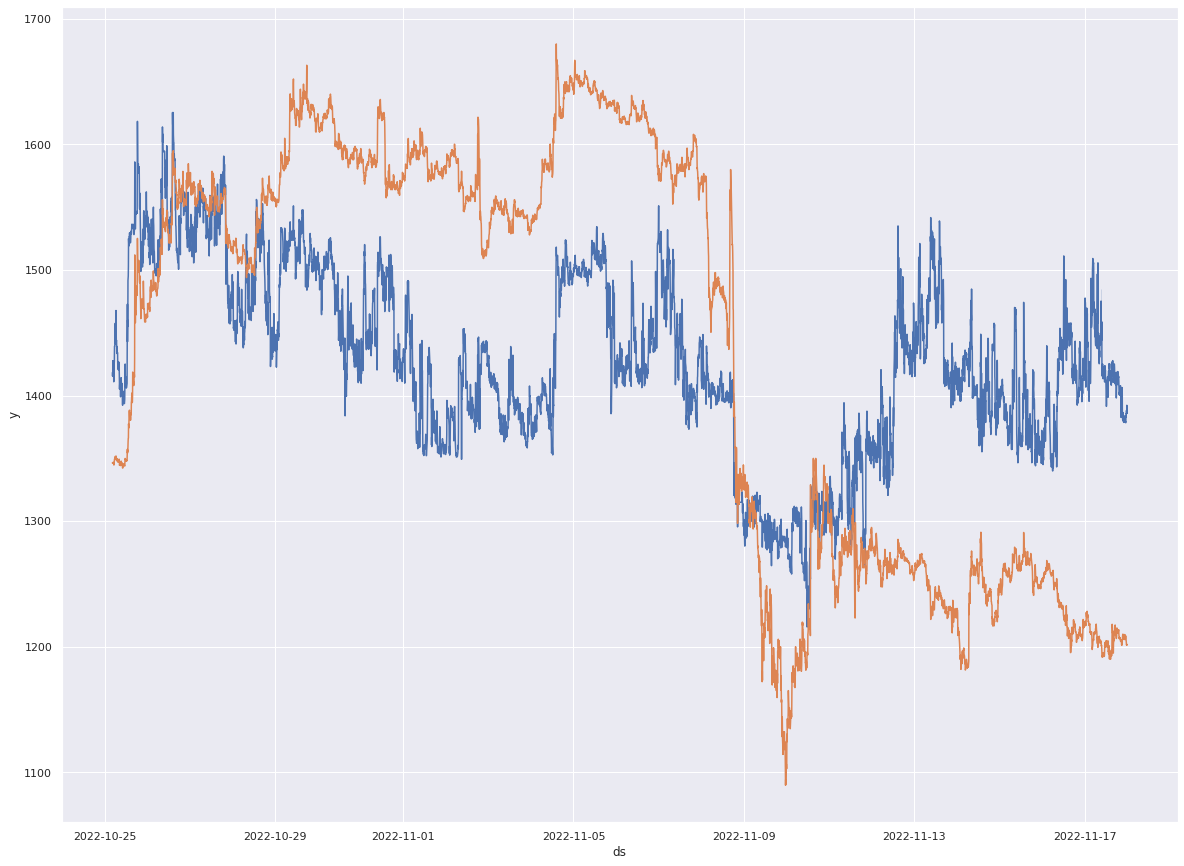

doing split 7 out of 7
                      ds        y  log_close/mean_60  log_return_60  \
0    2022-11-17 23:45:00  1201.64          -0.003873      -0.009409   
1    2022-11-17 23:50:00  1200.77          -0.004438      -0.009532   
2    2022-11-17 23:55:00  1201.37          -0.003780      -0.009527   
3    2022-11-18 00:00:00  1202.99          -0.002286      -0.008756   
4    2022-11-18 00:05:00  1203.25          -0.001973      -0.005784   
...                  ...      ...                ...            ...   
6858 2022-12-11 18:40:00  1274.85           0.001083       0.000486   
6859 2022-12-11 18:45:00  1274.52           0.000798       0.001563   
6860 2022-12-11 18:50:00  1275.51           0.001537       0.002229   
6861 2022-12-11 18:55:00  1280.00           0.004955       0.005743   
6862 2022-12-11 19:00:00  1283.00           0.007150       0.008776   

      log_close/mean_300  log_return_300  log_close/mean_900  log_return_900  
0              -0.004558       -0.010110     

/home/randell-crapy/miniconda3/envs/finance/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


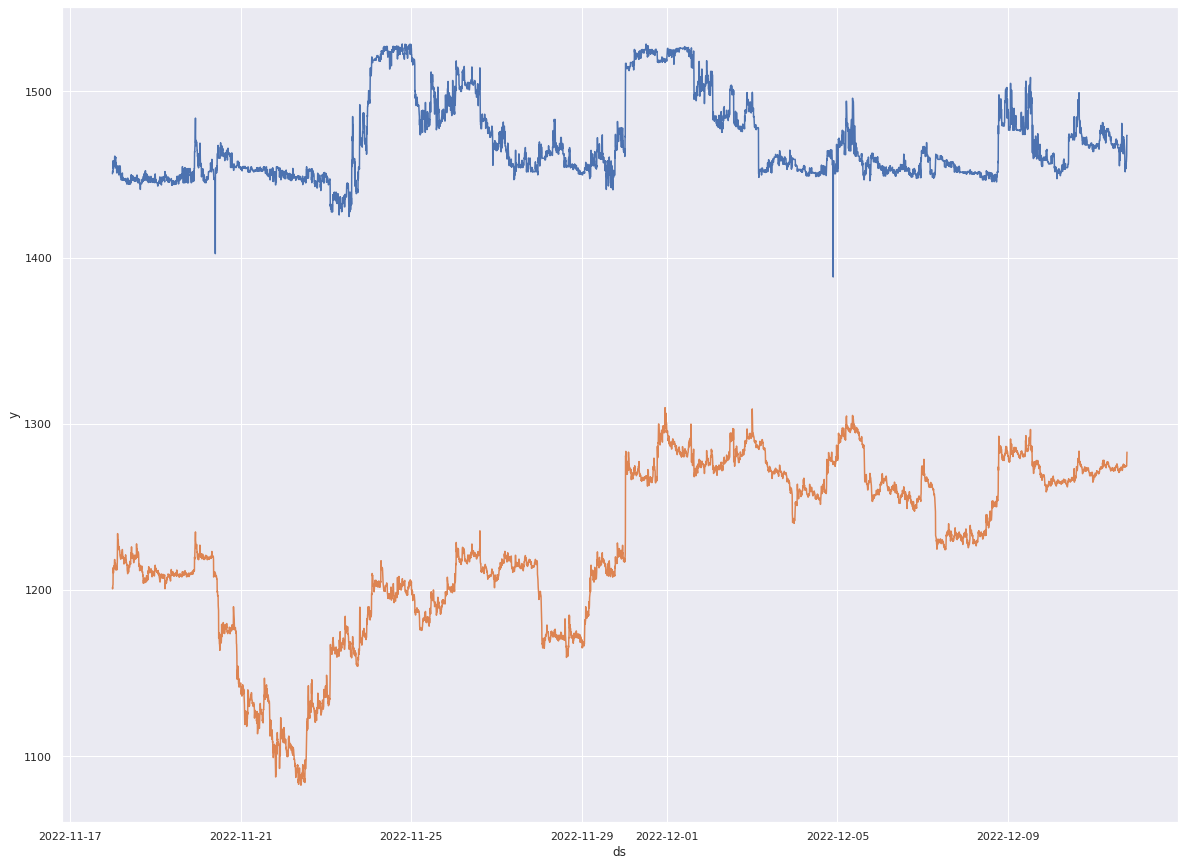

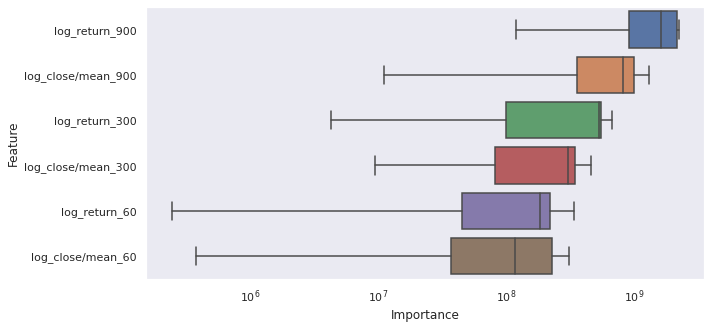

In [324]:
# EmbargoCV
df_proc = open
target_col = 'y'
train_test_zip = get_time_series_cross_val_splits(df_proc, cv = n_fold, embargo = 3750)

importances = []
oof_pred = []
oof_valid = [] 

for split, train_test_split in enumerate(train_test_zip):
    gc.collect()

    print(f"doing split {split+1} out of {n_fold}")
    train_split, test_split = train_test_split
    train_split_index = df_proc['ds'].isin(train_split)
    test_split_index = df_proc['ds'].isin(test_split)
    actual = df_proc.loc[test_split_index].reset_index(drop = True)
    print(actual)

    train_dataset = lgb.Dataset(df_proc.loc[train_split_index, features],
                                df_proc.loc[train_split_index, target_col].values, 
                                feature_name = features, 
                               )
    val_dataset = lgb.Dataset(df_proc.loc[test_split_index, features], 
                              df_proc.loc[test_split_index, target_col].values, 
                              feature_name = features, 
                             )
    
    print(f"number of train data: {len(df_proc.loc[train_split_index])}")
    print(f"number of val data:   {len(df_proc.loc[test_split_index])}")
#     print(df_proc.loc[test_split_index])
    model = lgb.train(params = params,
                      train_set = train_dataset, 
                      valid_sets=[train_dataset, val_dataset],
#                       valid_names=['tr', 'vl'],
                      num_boost_round = 5000,
                      verbose_eval = 100,   
                     )
    importances.append(model.feature_importance(importance_type='gain'))

    file = f'trained_model_fold{split}.pkl'
    pickle.dump(model, open(file, 'wb'))
    print(f"Trained model was saved to 'trained_model_fold{split}.pkl'")
    print("")
    fig, ax = plt.subplots(1,1,figsize=(20,15))
    
    prediction = model.predict(df_proc.loc[test_split_index, features]) 
    predict_df = pd.DataFrame(data={
        'ds': actual["ds"],
        'y':prediction
    })
    sns.lineplot(data=predict_df, x="ds", y='y', ax=ax)
    sns.lineplot(data=actual, x="ds", y='y',ax=ax)
    plt.show()
    
    oof_pred += list( prediction )
    oof_valid += list(   df_proc.loc[test_split_index, target_col].values    )
    
plot_importance(np.array(importances),features, PLOT_TOP_N = 20, figsize=(10, 5))


<AxesSubplot: >

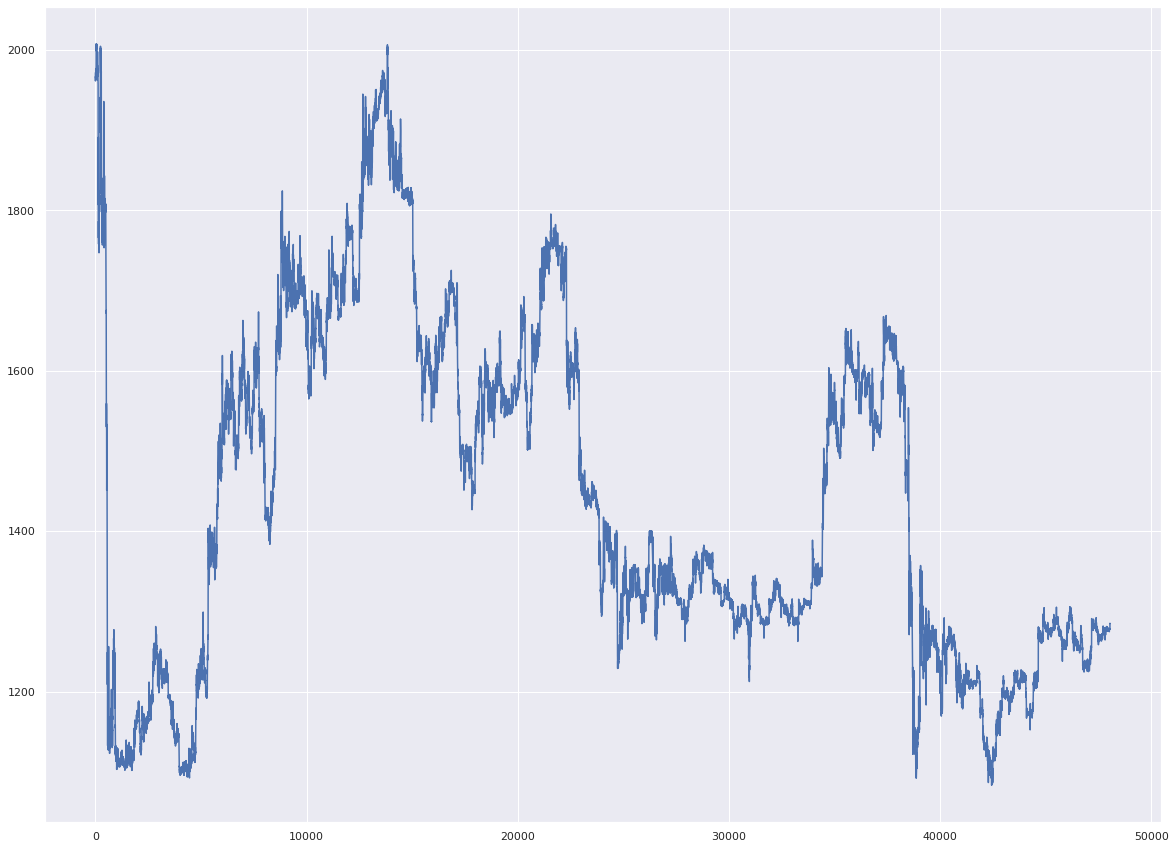

In [307]:

# fig, ax = plt.subplots(1,1,figsize=(20,15))
# w = weeks[i]
# # sns.lineplot(data=w, x="ds",y="y", ax=ax)
# sns.lineplot(data=oof_pred, ax=ax)

In [ ]:
# fit model with all the available data
model =lgb.load(filename = "trained_model_fold6.pkl")
# model.fit(data)

# generate dates for prediction (12 hours ahead of the latest datapoint in the data time)
future_dates = model.make_future_dataframe(periods=12, freq="h", include_history=False)

# predcit eth values on future_dates
forecast = model.predict(future_dates)
pred_vals = forecast.set_index('ds')['yhat'].to_numpy()


In [451]:
file_name = "/tmp/pred_vals.csv"
save_list(pred_vals, file_name)

In [24]:
from pybundlr import pybundlr
file_name = "/tmp/pred_vals.csv"
url = pybundlr.fund_and_upload(file_name, "matic", alice_wallet.private_key)
#e.g. url = "https://arweave.net/qctEbPb3CjvU8LmV3G_mynX74eCxo1domFQIlOBH1xU"
print(f"Your csv url: {url}")

NameError: name 'alice_wallet' is not defined

In [ ]:
name = "ETH predictions " + str(time.time()) #time for unique name
(data_nft, datatoken, asset) = ocean.assets.create_url_asset(name, url, alice_wallet, wait_for_aqua=False)
metadata_state = 5
data_nft.setMetaDataState(metadata_state, {"from":alice_wallet})
print(f"New asset created, with did={asset.did}, and datatoken.address={datatoken.address}")